In [3]:
%matplotlib inline
import re
import string
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import sys
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

In [4]:
dr_training_dataset = pd.read_csv('../Datasets/combined_training_dataset_cleaned.csv', 
                                                 encoding = "ISO-8859-1", dtype={"split": "string", "message": "string", "genre": "string"})

In [5]:
dr_test_dataset_unprocessed = pd.read_csv('../Datasets/disaster_response_messages_test_more_social_data_added.csv', 
                                                 encoding = "ISO-8859-1", dtype={"split": "string", "message": "string", "original": "string", "genre": "string"})
dr_validate_dataset_unprocessed = pd.read_csv('../Datasets/disaster_response_messages_validation.csv', 
                                                 encoding = "ISO-8859-1", dtype={"split": "string", "message": "string", "original": "string", "genre": "string"}) 

In [6]:
# converting any 0 to 2 (translates to no)
dr_test_dataset= dr_test_dataset_unprocessed.replace(2,0)
dr_validate_dataset= dr_validate_dataset_unprocessed.replace(2,0)

In [7]:
dr_test_dataset.head(10)

ï»¿id split                                            message  \
0    9.0  test  UN reports Leogane 80-90 destroyed. Only Hospi...   
1   39.0  test  We are at Gressier we needs assistance right a...   
2   49.0  test                     Delmas 33 in Silo, need water.   
3   79.0  test  SOS SOS, please provide police officers on the...   
4   99.0  test        I am a driver, a mechanic ,. I want to help   
5  119.0  test  We are at Fort Mercredi ( wednesday ) where ca...   
6  129.0  test  Our imcomprehensibley of 9 member was repatria...   
7  139.0  test  A cold front is on Cuba this morning. It could...   
8  149.0  test  Please Bo Gravel Vob Ta A 41 we are hungry. Ne...   
9  159.0  test  We are not located in one place, and i want yo...   

                                            original   genre  related  PII  \
0  UN reports Leogane 80-90 destroyed. Only Hospi...  direct        1    0   
1    Se gressier nou an difikilte tanpri vin ede nou  direct        1    0   
2                      Delma 33 silo gen problem dlo  direct        1    0   
3  EMGENCY EMGENCY SI POLIS LA TE KA BAY PREZANS ...  direct        1    0   
4  MWEN SE YON NMALIEN, CHOF, MEKANISYEN MWEN BEZ...  direct        1    0   
5  Nous sommes  Fort - Mercredi Ou on peux trouve...  direct        1    0   
6  asyon de 9 manb nou nan rapatriye zon la plan ...  direct        1    0   
7  Un front froid se retrouve sur Cuba ce matin. ...  direct        1    0   
8               SVP BO GRAVEL VOB TAA 41 NOU GRANGOU  direct        1    0   
9  ske se pa yon sel kote nou ye epi map fe nou k...  direct        1    0   

   request  offer  aid_related  ...  aid_centers  other_infrastructure  \
0        1      0            1  ...            0                     0   
1        1      0            1  ...            0                     0   
2        1      0            1  ...            0                     0   
3        1      0            1  ...            0                     0   
4        0      1            0  ...            0                     0   
5        1      0            1  ...            0                     0   
6        0      0            0  ...            0                     0   
7        0      0            0  ...            0                     0   
8        1      0            1  ...            0                     0   
9        0      0            1  ...            0                     0   

   weather_related  floods  storm  fire  earthquake  cold  other_weather  \
0                0       0      0     0           0     0              0   
1                1       1      0     0           0     0              0   
2                0       0      0     0           0     0              0   
3                0       0      0     0           0     0              0   
4                0       0      0     0           0     0              0   
5                0       0      0     0           0     0              0   
6                0       0      0     0           0     0              0   
7                1       0      1     0           0     1              0   
8                0       0      0     0           0     0              0   
9                0       0      0     0           0     0              0   

   direct_report  
0              0  
1              1  
2              1  
3              1  
4              0  
5              1  
6              0  
7              0  
8              1  
9              1  

[10 rows x 42 columns]

In [8]:
dr_training_dataset.shape

(32060, 40)

In [9]:
dr_training_dataset['genre'].unique()

<StringArray>
['direct', 'social', 'news']
Length: 3, dtype: string

In [10]:
dr_training_dataset['related'].value_counts()

1    16793
0    15267
Name: related, dtype: int64

In [11]:
dr_test_dataset['related'].value_counts()

1    2210
0    1420
Name: related, dtype: int64

In [12]:
dr_training_dataset['genre'].value_counts()

social    17772
news       8472
direct     5816
Name: genre, dtype: Int64

In [13]:
dr_training_dataset.dtypes

split                     string
message                   string
genre                     string
related                    int64
PII                        int64
request                    int64
offer                      int64
aid_related                int64
medical_help               int64
medical_products           int64
search_and_rescue          int64
security                   int64
military                   int64
child_alone                int64
water                      int64
food                       int64
shelter                    int64
clothing                   int64
money                      int64
missing_people             int64
refugees                   int64
death                      int64
other_aid                  int64
infrastructure_related     int64
transport                  int64
buildings                  int64
electricity                int64
tools                      int64
hospitals                  int64
shops                      int64
aid_center

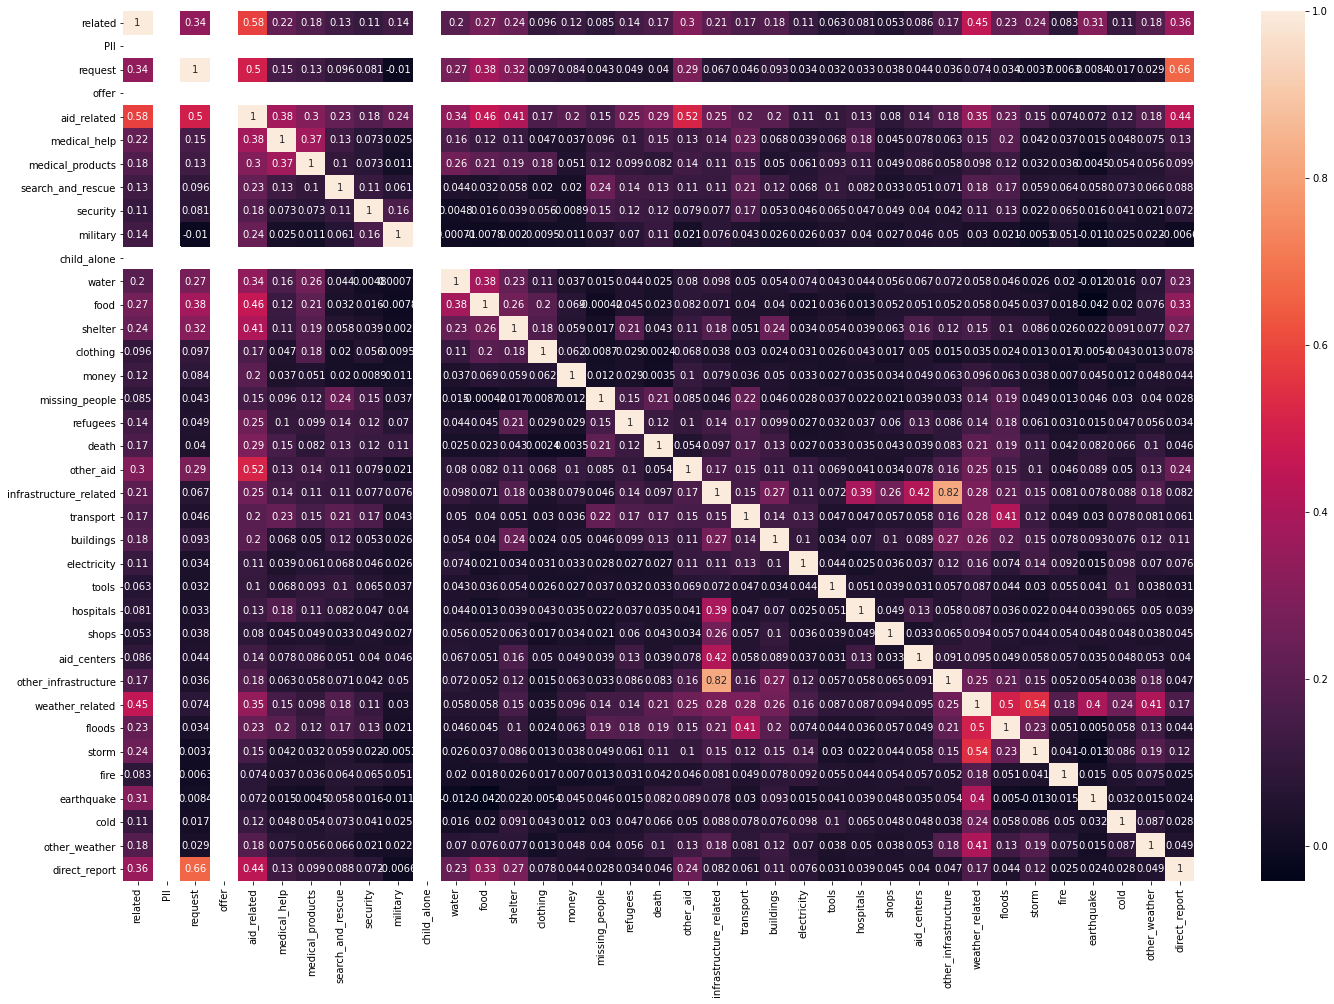

In [14]:
# use high correlations to identfiy tags that can be removed
# can remove weather_related, other_infrastructure, other_aid, other_weather 
# also removing PII, split, original, genre
dr_training_dataset_corr = dr_training_dataset.corr()
fig, ax = plt.subplots(figsize=(24,16))

sns.heatmap(dr_training_dataset_corr, annot=True)

In [15]:
# minimising the training dataset for R&I
dr_training_dataset.drop(dr_training_dataset.columns.difference(['message', 'related', 'cold','earthquake', 'fire', 'storm', 'medical_help','water','food','shelter','electricity','missing_people','infrastructure_related','hospitals']), 1, inplace=True)

In [16]:
# minimising the test dataset for R&I
dr_test_dataset.drop(dr_test_dataset.columns.difference(['message', 'related', 'cold','earthquake', 'fire', 'storm', 'medical_help','water','food','shelter','electricity','missing_people','infrastructure_related','hospitals']), 1, inplace=True)

In [17]:
# minimising the validate dataset for R&I
dr_validate_dataset.drop(dr_test_dataset.columns.difference(['message', 'related', 'cold','earthquake', 'fire', 'storm', 'medical_help','water','food','shelter','electricity','missing_people','infrastructure_related','hospitals']), 1, inplace=True)

In [18]:
dr_training_dataset.head()

message  related  medical_help  \
0  Weather update - a cold front from Cuba that c...        1             0   
1            Is the Hurricane over or is it not over        1             0   
2  says: west side of Haiti, rest of the country ...        1             0   
3                     Storm at sacred heart of jesus        1             0   
4  Please, we need tents and water. We are in Sil...        1             0   

   water  food  shelter  missing_people  infrastructure_related  electricity  \
0      0     0        0               0                       0            0   
1      0     0        0               0                       0            0   
2      0     0        0               0                       0            0   
3      0     0        0               0                       0            0   
4      1     0        1               0                       0            0   

   hospitals  storm  fire  earthquake  cold  
0          0      0     0           0     0  
1          0      1     0           0     0  
2          0      0     0           0     0  
3          0      1     0           0     0  
4          0      0     0           0     0

In [19]:
# Identifying the number of comments in each category (disaster related & weather related)
dr_tags = dr_training_dataset.drop(['message'], axis=1)
counts = []
categories = list(dr_tags.columns.values)
for i in categories:
    #if (categories == 1):
    counts.append((i, dr_tags[i].sum()))
dr_tags_stats = pd.DataFrame(counts, columns=['category', 'number_of_messages'])

In [20]:
# number of comments in each category
dr_tags_stats

category  number_of_messages
0                  related               16793
1             medical_help                1654
2                    water                1321
3                     food                2329
4                  shelter                1878
5           missing_people                 252
6   infrastructure_related                1438
7              electricity                 449
8                hospitals                 228
9                    storm                1973
10                    fire                 239
11              earthquake                2977
12                    cold                 425

In [21]:
# total number of rows in each category (about 1/4 are weather related and 3/4 are disaster related)
dr_tags.count()

related                   32060
medical_help              32060
water                     32060
food                      32060
shelter                   32060
missing_people            32060
infrastructure_related    32060
electricity               32060
hospitals                 32060
storm                     32060
fire                      32060
earthquake                32060
cold                      32060
dtype: int64

Text(0.5, 0, 'category')

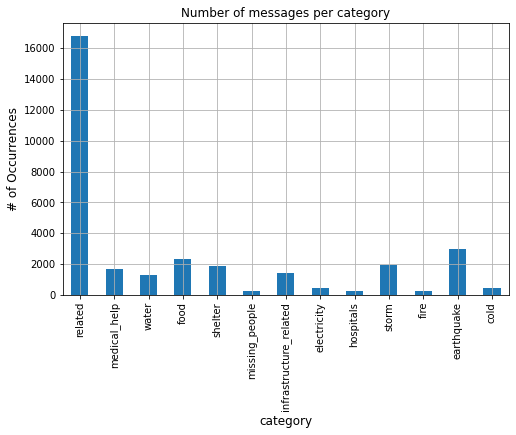

In [22]:
# visualising the categories
dr_tags_stats.plot(x='category', y='number_of_messages', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of messages per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

Text(0.5, 0, '# of categories')

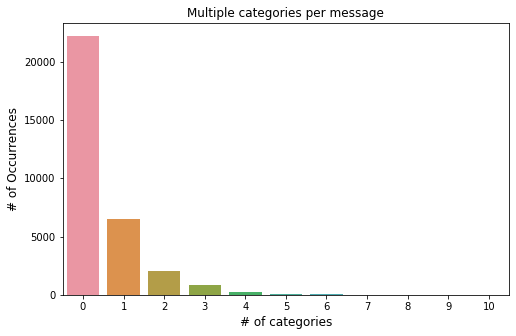

In [23]:
# How many comments have multi labels?
rowsums = dr_training_dataset.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per message")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [24]:
dr_training_dataset['related'].unique()

array([1, 0])

In [25]:
# 24% of messages aren't labelled 
#print('Percentage of messages that are not labelled:')
#print(len(dr_training_dataset[(dr_training_dataset['related']==0) & (dr_training_dataset['weather_related']==0)]) / len(dr_training_dataset))

In [26]:
len(dr_training_dataset)/4

8015.0

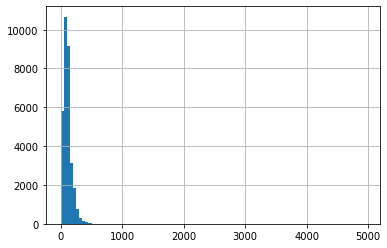

In [27]:
# distribution of the number of words: nothing above 600
lens = dr_training_dataset.message.str.len()
lens.hist(bins = np.arange(0,5000,50))
# ylabel # of messages'
# xlabel # of characters'

In [28]:
print('Number of missing messages in message text:')
dr_training_dataset['message'].isnull().sum()

Number of missing messages in message text:


0

In [29]:
# having apeek at the first message
dr_training_dataset['message'][0]

'Weather update - a cold front from Cuba that could pass over Haiti'

In [30]:
# function to clean the data
def clean_text(text):
    # make all text lowercase
    text = text.lower()
    # substitute common abbreviations
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    # removes any leading spaces at the beginning and trailing spaces at the end
    text = text.strip(' ')
    # new bit
    # remove punctuations
    words = text.split()
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in words]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    # stemming of words
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in words]
    seperator = " "
    text = seperator.join(words)
    print(words)
    print("---")
    return text

In [31]:
dr_training_dataset['message'] = dr_training_dataset['message'].map(lambda com : clean_text(com))
dr_test_dataset['message'] = dr_test_dataset['message'].map(lambda com : clean_text(com))
dr_validate_dataset['message'] = dr_test_dataset['message'].map(lambda com : clean_text(com))
#dr_training_dataset['message'][0]

['weather', 'update', 'cold', 'front', 'cuba', 'could', 'pass', 'haiti']
---
['hurricane']
---
['says', 'west', 'side', 'haiti', 'rest', 'country', 'today', 'tonight']
---
['storm', 'sacred', 'heart', 'jesus']
---
['please', 'need', 'tents', 'water', 'silo', 'thank']
---
['nothing', 'eat', 'water', 'starving', 'thirsty']
---
['thomassin', 'number', 'area', 'named', 'pyron', 'would', 'like', 'water', 'thank', 'god', 'fine', 'desperately', 'need', 'water', 'thanks']
---
['let', 'together', 'need', 'food', 'delma', 'didine', 'area']
---
['information', 'number', 'order', 'participate', 'see', 'use']
---
['comitee', 'delmas', 'rue', 'street', 'janvier', 'impasse', 'charite', 'people', 'temporary', 'shelter', 'dire', 'need', 'water', 'food', 'medications', 'tents', 'clothes', 'please', 'stop', 'see', 'us']
---
['need', 'food', 'water', 'klecin', 'dying', 'hunger', 'impasse', 'chretien', 'klecin', 'extended', 'extension', 'hungry', 'sick']
---
['would', 'like', 'know', 'earthquake', 'thanks'

['survivors', 'lalue', 'near', 'olympic', 'market']
---
['us', 'people', 'matye', 'grand', 'rivye', 'seksyon', 'leoganne', 'waiting', 'help', 'bringing', 'us', 'patiently', 'cause', 'wait', 'anymore']
---
['alot', 'problems', 'money', 'people']
---
['need', 'help', 'seguineau', 'road', 'corner', 'nazon', 'bertholy', 'really', 'need', 'water']
---
['friend', 'heard', 'nothing', 'lot', 'problems', 'u', 'give', 'take', 'jeremi', 'want', 'u', 'help']
---
['silence', 'bus', 'hv', 'food', 'water', 'alot', 'things', 'please', 'come']
---
['people', 'sleeping', 'street', 'please', 'help', 'us', 'find', 'tent', 'food']
---
['need', 'water', 'carrefour', 'bertin']
---
['please', 'everything', 'possible', 'thanks', 'god', 'bless']
---
['town', 'les', 'cayes', 'needs', 'food', 'items', 'assure', 'message', 'incomplete']
---
['aid', 'reach', 'victims', 'outside', 'city', 'p', 'au', 'p', 'gonaives', 'u', 'get', 'message']
---
['sos', 'water', 'food', 'need', 'find', 'adress', 'located']
---
['need',

['people', 'coming', 'department', 'coming', 'port', 'au', 'prince', 'baks', 'open', 'serve']
---
['im', 'port', 'au', 'prince', 'house', 'destroyed', 'im', 'fine', 'family']
---
['panamerican', 'street', 'cannot', 'count', 'amount', 'victims', 'since', 'energy', 'gas', 'area', 'needs', 'mostly', 'cooked', 'food', 'drinkable', 'water']
---
['please', 'alone', 'would', 'like', 'know', 'somebody', 'would', 'like', 'adopt', 'adolescent', 'please', 'adopt']
---
['need', 'water', 'food', 'please', 'help', 'us', 'help', 'clercine']
---
['carrefour', 'feuilles', 'slum', 'west', 'port', 'au', 'prince', 'rest', 'message', 'make', 'sense']
---
['bonsoir', 'est', 'bon', 'repos', 'aprs', 'la', 'compagnie', 'teleko', 'sur', 'la', 'route', 'droite', 'de', 'l', 'impasse', 'roger', 'colas', 'aprs', 'la', 'maison', 'sur', 'la', 'main', 'droite', 'de', 'la', 'rue', 'est', 'environ', 'personnes', 'sur', 'un']
---
['student', 'group', 'port', 'au', 'prince', 'arrived', 'port', 'de', 'paix', 'save', 'anyth

['food', 'distribution', 'area', 'live']
---
['please', 'number', 'call', 'get', 'information']
---
['law', 'student', 'place', 'stay', 'home', 'destroyed', 'received', 'aid', 'foreigners', 'sent']
---
['kan', 'people', 'stationed', 'riboncy', 'street', 'honorat', 'nazon', 'area', 'water', 'tent', 'please', 'help', 'us']
---
['calboi', 'place', 'need', 'food', 'water']
---
['need', 'help', 'please', 'ar', 'carrefour', 'pernier', 'please', 'verify', 'location']
---
['dear', 'friends', 'say', 'something', 'lot', 'problems', 'mom', 'dad', 'brother', 'sister', 'gone', 'one', 'call', 'please', 'help']
---
['need', 'rescue', 'team', 'need', 'help', 'delmas', 'thank']
---
['starving', 'food', 'located', 'carrefour']
---
['group', 'people', 'living', 'tabarre', 'dying', 'food', 'please', 'help']
---
['countryside', 'getting', 'overcrowded', 'need', 'help', 'miragoane']
---
['homeless', 'need', 'tent', 'kids']
---
['location', 'gov', 'officials', 'showed', 'see', 'us', 'kids', 'message', 'trunc

['live', 'riviere', 'froide', 'lot', 'people', 'lost', 'house', 'water', 'food', 'suffering', 'sleeping', 'rain', 'sheets']
---
['requesting', 'govement', 'set', 'solar', 'panel', 'energy', 'communication', 'clear', 'trouble']
---
['friends', 'asking', 'water', 'food']
---
['know', 'else', 'getting', 'best', 'cap', 'haitian', 'still', 'sleep', 'inside', 'house', 'sleep', 'public', 'square', 'boday', 'wants']
---
['inhabitants', 'zone', 'bel', 'air', 'especially', 'docteur', 'aubry', 'street', 'macajoux', 'street', 'rue', 'street', 'cesars', 'pitiful', 'state', 'truncated', 'please', 'someone', 'better', 'handle', 'pap', 'geography', 'check', 'sure', 'coords', 'right']
---
['food', 'left', 'looking', 'help', 'food', 'clothing', 'issues', 'water', 'food', 'left', 'incomplete']
---
['could', 'us', 'thanks', 'advance', 'incomplete', 'end', 'message']
---
['sleep', 'baby', 'thanks', 'advance', 'help', 'bring', 'us', 'incomplete']
---
['sos', 'cour', 'watson', 'situated', 'bolosse', 'avenue'

['good', 'evening', 'say', 'earthquake', 'going', 'saturday', 'scale']
---
['please', 'dnt', 'foget', 'provinces', 'lot', 'people', 'went', 'care', 'suffering', 'also', 'prisoner', 'escaped', 'went', 'gonaives', 'saint', 'marc']
---
['want', 'know', 'precaution', 'take', 'house', 'sleep', 'streets']
---
['areas', 'outside', 'city', 'hit', 'could', 'feel', 'aftershocks', 'students']
---
['people', 'plaisance', 'north', 'country', 'problems', 'houses', 'people', 'came', 'pap', 'anything', 'eat', 'time', 'need', 'help']
---
['son', 'would', 'hurt', 'took', 'away', 'treatment', 'know', 'hospital']
---
['evening', 'true', 'aftershake', 'first', 'one']
---
['lot', 'people', 'saying', 'take', 'govt', 'buses', 'go', 'provinces', 'able', 'come', 'back', 'port', 'au', 'prince', 'true']
---
['would', 'like', 'know', 'aftershocks', 'going', 'end', 'thank', 'willy']
---
['child', 'would', 'like', 'foreigners', 'adopt', 'take', 'care']
---
['basically', 'said', 'unemployment', 'hunger', 'anymore', '

['hello', 'zone', 'williamson', 'need', 'help', 'famine', 'take', 'need', 'food', 'need', 'water', 'eating', 'whatever', 'find']
---
['would', 'like', 'information', 'please']
---
['would', 'like', 'information', 'earthquake']
---
['many', 'family', 'members', 'victims', 'earthquake', 'pap', 'jan', 'need', 'food', 'st', 'marc', 'chemin']
---
['starving', 'death', 'without', 'anything', 'please', 'bring', 'us', 'water', 'food', 'tents', 'temporary', 'home', 'sheets', 'medical', 'products', 'electricity', 'lilavwa']
---
['hello', 'would', 'like', 'know', 'wether', 'someone', 'know', 'saint', 'domingue', 'still', 'alive']
---
['people', 'supposed', 'leave', 'january', 'family', 'died', 'earthquake', 'cousin', 'france', 'give', 'chance', 'go', 'join', 'passport']
---
['one', 'talked', 'homes', 'destroyed', 'kenscoff']
---
['hello', 'people', 'pleading', 'find', 'way', 'bring', 'little', 'water', 'us', 'near', 'mais', 'gate', 'thank']
---
['true', 'another', 'earthquake', 'stronger', 'one']

['every', 'hours', 'ask', 'grace', 'forgiveness', 'mercy', 'haiti', 'faith', 'go', 'take', 'us', 'send', 'message', 'people']
---
['need', 'work', 'please', 'lot']
---
['undammaged', 'haitel', 'stores', 'already', 'open']
---
['would', 'like', 'information', 'last', 'disaster']
---
['would', 'like', 'find', 'information', 'earthquake', 'happened', 'country', 'information']
---
['would', 'like', 'known', 'many', 'people', 'died', 'natural', 'disaster', 'school', 'open', 'would', 'like', 'americans', 'gain', 'control', 'country', 'put', 'order']
---
['goupe', 'women', 'shada', 'need', 'help', 'shada']
---
['heard', 'creole', 'service', 'broadcast', 'voice', 'america', 'evidently', 'port', 'au', 'prince', 'house', 'demolished', 'god', 'killed', 'children', 'nothing']
---
['send', 'list', 'universities', 'faculties', 'collapsed', 'im', 'waiting', 'answer', 'thank']
---
['truck', 'fell', 'men', 'wondering', 'happen', 'us', 'zemich', 'carrefour']
---
['hello', 'student', 'want', 'information

['live', 'diquini', 'seminary', 'school', 'food', 'problems', 'please', 'send', 'something', 'us']
---
['lot', 'problems', 'since', 'thursday', 'eat', 'much', 'shocked', 'used', 'live', 'destroyed', 'save', 'anything']
---
['please', 'give', 'us', 'info', 'aftershocks', 'felt']
---
['good', 'evening', 'dificul', 'moment', 'would', 'like', 'go', 'canada', 'family', 'go']
---
['need', 'help', 'cabaret', 'sleeping', 'street', 'need', 'shelter']
---
['la', 'gonave', 'ten', 'days', 'desaster', 'needs', 'afraid', 'sleep', 'house', 'need', 'food', 'water', 'medecine', 'please', 'thinks', 'la', 'gonave']
---
['hello', 'house', 'destroyed', 'get', 'help', 'please']
---
['ojvr', 'organisation', 'jeunes', 'victimes', 'sou', 'raille', 'digicel', 'organisation', 'young', 'victims', 'sou', 'ray', 'name', 'main', 'road', 'closest', 'sea', 'carrefour', 'bunch', 'people', 'victims', 'catastrophe', 'tuesday', 'january']
---
['port', 'au', 'prince', 'west', 'people', 'family', 'live', 'house', 'gone', 'o

['family', 'montreal', 'papers', 'would', 'like', 'go', 'find']
---
['strong', 'rescuers', 'good', 'lord', 'help', 'us']
---
['whole', 'bunch', 'mangonese', 'road', 'christ', 'roi', 'port', 'au', 'prince', 'need', 'water', 'food', 'medical', 'assistance']
---
['moleard', 'adventist', 'church', 'morija', 'community', 'great', 'risk', 'need', 'tents', 'food', 'water', 'people']
---
['days', 'since', 'people', 'butte', 'boyer', 'food', 'would', 'like', 'know', 'people', 'butte', 'boyer', 'clercine', 'find', 'food', 'relief']
---
['husband', 'needs', 'rice', 'water']
---
['people', 'coeur', 'unis', 'guessing', 'church', 'also', 'hunger', 'killing', 'yesterday', 'pushed', 'recieve', 'food', 'fontamara', 'need', 'security', 'many', 'fights']
---
['congratulations', 'work', 'thanks']
---
['requesting', 'specialist', 'earthquake', 'finished']
---
['asking', 'aid', 'recieve', 'anything', 'platali']
---
['never', 'seen', 'one', 'police', 'circulating', 'matisan', 'thank']
---
['go', 'find', 'hel

['cold', 'front', 'cuba', 'morning', 'could', 'cross', 'haiti', 'tomorrow', 'isolated', 'rain', 'showers', 'still', 'targeted', 'region', 'evening']
---
['good', 'evening', 'commune', 'thomazeau', 'first', 'section', 'trou', 'caiman', 'things', 'good', 'little', 'rice', 'see', 'us', 'au', 'revoir']
---
['good', 'evening', 'please', 'help', 'us', 'croix', 'des', 'bouquests', 'fort', 'drago', 'street', 'dont']
---
['done', 'stop', 'sleeping', 'street', 'thank']
---
['would', 'like', 'know', 'house', 'collapsed', 'january']
---
['homeless', 'live', 'carrefour', 'feuilles', 'need', 'help']
---
['please', 'bring', 'rescue', 'people', 'leogane', 'realize', 'aide', 'separated', 'leogane', 'really', 'needs', 'help', 'gotten', 'anything']
---
['good', 'evening', 'need', 'information', 'please']
---
['esdras', 'address', 'solidarit', 'village', 'toussain', 'louverture', 'street']
---
['hello', 'writing', 'letter', 'ask', 'couple', 'things', 'rice', 'water', 'etc', 'address', 'corossole', 'rue', 

['leogane', 'badly', 'damaged', 'needs', 'tents', 'asap']
---
['delmas', 'tell', 'closest', 'food', 'distribution', 'place', 'around']
---
['need', 'help', 'bizoton', 'next', 'la', 'belle', 'etoile', 'please', 'depend', 'thank', 'advance']
---
['help', 'needed', 'food', 'milk', 'kids', 'lamentin', 'aurelle', 'st', 'received', 'help', 'since', 'quake', 'hungry']
---
['survivor', 'goanaives', 'need', 'help', 'help']
---
['us', 'gros', 'morne', 'artibonite', 'need', 'medical', 'assistance', 'never', 'send', 'us', 'anything', 'send', 'doctors', 'us']
---
['crisis', 'people', 'gwo', 'mon']
---
['community', 'cite', 'soleil', 'needs', 'helps', 'like', 'water', 'food', 'tents', 'thank']
---
['gonaives', 'need', 'help', 'food', 'urgent']
---
['petit', 'goave', 'needs', 'food', 'sleep', 'please', 'asking', 'take', 'years', 'survive']
---
['thought', 'gave', 'number', 'serious', 'meanwhile', 'today', 'days', 'still', 'gotten', 'anything']
---
['thought', 'gave', 'number', 'serious', 'meanwhile',

['ine', 'danger', 'days', 'thanks']
---
['many', 'people', 'came', 'capital', 'port', 'de', 'paix', 'never', 'knew', 'place', 'need', 'food', 'water', 'shelter']
---
['would', 'like', 'know', 'government', 'going', 'collapsed', 'houses', 'sleeping', 'streets', 'south', 'southeast', 'cayes', 'jacmel']
---
['road', 'ducoste', 'behind', 'plaza', 'people', 'water', 'food', 'please', 'help']
---
['end', 'word', 'live', 'pap']
---
['streets', 'stand', 'anymore', 'please', 'help']
---
['penyen', 'commune', 'l', 'est']
---
['hello', 'victim', 'forced', 'leave', 'capital', 'home', 'province', 'jean', 'rabel', 'lost', 'everything']
---
['need', 'two', 'plz', 'wife', 'delivered', 'baby', 'anything', 'money', 'food', 'plz', 'make', 'package', 'call', 'number']
---
['friends', 'miragoane', 'need', 'help', 'street', 'cold', 'hungry']
---
['people', 'petit', 'goaves', 'need', 'medical', 'assistance', 'well', 'please', 'aware', 'well']
---
['good', 'evening', 'carrefour', 'binou', 'ti', 'goave', 'plac

['need', 'help', 'earthquake', 'killing', 'us', 'tarps', 'tents']
---
['tell', 'many', 'people', 'died', 'event']
---
['help', 'us', 'la', 'gonave', 'need', 'food']
---
['wants', 'information', 'renewing', 'passport', 'expired', 'since']
---
['good', 'morning', 'please', 'provide', 'us', 'food', 'fond', 'michel', 'locality', 'name']
---
['thought', 'possible', 'help', 'would', 'come', 'forreigners', 'leogane', 'route']
---
['want', 'know', 'find', 'food', 'water', 'tents', 'brothers', 'sisters']
---
['people', 'city', 'castro', 'area', 'mais', 'gate', 'field', 'asking', 'humanitarian', 'organisations', 'look', 'way', 'would', 'suggest', 'organisations', 'alos', 'put', 'office']
---
['people', 'neighborhood', 'montana', 'road', 'bresilienne', 'arriving', 'denard', 'ask', 'institute', 'forgere', 'jacques']
---
['miragoane', 'many', 'houses', 'destroyed']
---
['redcross', 'live', 'torcel', 'tabar', 'impasse', 'des', 'laurierset', 'tulipes', 'numer', 'place', 'nothing', 'eat', 'need', 'foo

['would', 'like', 'participate', 'service']
---
['salute', 'staff', 'need', 'help', 'find', 'food', 'sent', 'message', 'get', 'response', 'find', 'way', 'respond', 'children', 'good', 'lord']
---
['hour', 'two', 'ask', 'grace', 'god', 'forgiveness', 'deliverance', 'haiti', 'alone', 'lift', 'us', 'situation', 'send', 'message']
---
['widow', 'working', 'years', 'ministry', 'gonaives', 'men']
---
['may', 'concern', 'please', 'need', 'food', 'water', 'live', 'leogane', 'carrefour', 'dufort', 'coraille', 'lemaire', 'please', 'help', 'us']
---
['would', 'like', 'know', 'help', 'coming', 'bainet']
---
['artibonite', 'saw', 'nothing', 'coming', 'please', 'send', 'sms', 'konw', 'something', 'survivors']
---
['hours', 'time', 'ask', 'forgiveness', 'haiti', 'faith', 'god', 'take', 'us', 'situation', 'send', 'message', 'tp', 'people']
---
['anymore', 'help', 'us', 'please']
---
['people', 'tent', 'impasse', 'lillavois', 'area', 'bon', 'repos', 'lot', 'problems', 'need', 'food', 'ans', 'water', 't

['would', 'like', 'find', 'information', 'earthquake']
---
['give', 'last', 'information', 'regarding', 'earthquake']
---
['need', 'help', 'carrefour', 'canne', 'sucre', 'impasse', 'vainqueur']
---
['help', 'us', 'please', 'living', 'condition', 'good']
---
['since', 'cyber', 'cafes', 'damaged', 'one', 'internet']
---
['hello', 'need', 'shelter', 'need', 'mobile', 'health', 'service', 'need', 'food', 'water', 'nobody', 'came', 'see', 'us', 'neighbors', 'helping', 'us']
---
['sms', 'please', 'hello', 'side', 'center', 'corner', 'house', 'broken', 'family', 'need', 'help', 'would', 'like', 'call', 'card', 'give']
---
['live', 'leogane', 'family', 'street', 'even', 'appropriate', 'shelter', 'asking', 'authorities', 'take', 'charge', 'rest', 'sentence', 'cut']
---
['disaster', 'stricken', 'port', 'au', 'prince', 'trans', 'know', 'going', 'live', 'help', 'digicel', 'company']
---
['earthquake', 'happened', 'evening', 'night']
---
['cabaret', 'lot', 'victims', 'need', 'information', 'food', 

['haitian', 'people', 'people', 'need', 'courage', 'resist', 'lot', 'people', 'lost', 'love', 'ones']
---
['heard', 'ocean', 'invade', 'part', 'haiti', 'truth']
---
['avenue', 'magloire', 'ambroise', 'far', 'sister', 'compound', 'never', 'found', 'food', 'found', 'water']
---
['brothers', 'coumpound', 'freres', 'leogane', 'need', 'tarpaulin', 'canvas', 'food', 'drinking', 'water']
---
['school', 'going', 'te', 'reopen']
---
['people', 'provinces', 'go', 'port', 'au', 'prince', 'without', 'problems']
---
['send', 'little', 'aid', 'us', 'franswa', 'section', 'bel', 'vi', 'mountain']
---
['find', 'food', 'water', 'tent', 'sleep', 'kids', 'please', 'come', 'help', 'us']
---
['people', 'section', 'la', 'gonave', 'island', 'dying', 'hunger']
---
['la', 'gonave', 'residents', 'many', 'difficulties', 'food', 'harder', 'first', 'section', 'palma', 'listen', 'voice', 'suffuring', 'please']
---
['please', 'could', 'tell', 'get', 'card', 'get', 'food', 'giving']
---
['brothers', 'leogane', 'school

['hungry', 'one']
---
['would', 'like', 'know', 'house', 'destroyed', 'get', 'back', 'house']
---
['would', 'like', 'job', 'january', 'disaster']
---
['sos', 'thieves', 'issue', 'rue', 'nord', 'alexis', 'avenue', 'poupelard', 'breaking', 'damage', 'houses', 'broad', 'day', 'light']
---
['story', 'building', 'ruelle', 'chretien', 'summit', 'hill', 'please', 'destroyed', 'may', 'kill', 'several', 'whenever', 'falls', 'one']
---
['would', 'like', 'know', 'get', 'card', 'pam', 'distributing', 'get', 'bag', 'rice']
---
['information', 'needed', 'vaccination']
---
['watch', 'eyes', 'suffer', 'water', 'wo', 'kill', 'us']
---
['injured', 'home', 'destroyed', 'even', 'receiving', 'water']
---
['group', 'women', 'twitye', 'carrefour', 'would', 'like', 'know', 'get', 'coupons', 'cards', 'receive', 'food']
---
['gouvernement', 'help', 'us', 'rebuild', 'house', 'want', 'believe']
---
['earth', 'shaking', 'please', 'give', 'information']
---
['want', 'go', 'country', 'side', 'find', 'bus']
---
['gor

['hello', 'goverment', 'looking', 'places', 'put', 'put', 'evrybody', 'department', 'latibonite', 'place', 'many', 'people', 'go']
---
['people', 'provinces', 'need', 'tents', 'shelter', 'also', 'thank']
---
['live', 'carrefour', 'feuilles', 'rue', 'sicot', 'shelter', 'food', 'water']
---
['people', 'santo', 'needs', 'food', 'water', 'thank']
---
['notes', 'asking', 'earthquakes']
---
['people', 'gressier', 'santo', 'area', 'enpas', 'des', 'arbres', 'launched', 'sos', 'suffering', 'lack', 'shelter', 'water', 'food', 'please', 'help']
---
['medical', 'student', 'would', 'like', 'get', 'job', 'helping', 'sick']
---
['people', 'croix', 'des', 'missioons', 'never', 'got', 'anything', 'la', 'plaine', 'especially']
---
['notes', 'wanting', 'know', 'many', 'people', 'died', 'earthquake', 'pap']
---
['never', 'found', 'tents', 'live', 'tie', 'sheets', 'stay']
---
['port', 'au', 'prince', 'needs', 'much', 'mathieu', 'logane', 'need', 'much', 'thank', 'collaboration', 'foreign', 'countries', 'wo

['haitians', 'still', 'going', 'senegal']
---
['bit', 'disturb', 'situation', 'haiti', 'please', 'advise', 'days', 'come']
---
['wehre', 'send', 'help', 'pay', 'money', 'either', 'every', 'month', 'every', 'two', 'weeks']
---
['ciab', 'group', 'coordination', 'inter', 'active', 'de', 'bande', 'du', 'nord', 'asking', 'aid', 'people', 'zone', 'rear', 'neighbourhood', 'tifenty', 'tivoteney', 'people', 'alone', 'difficult', 'moment']
---
['live', 'petit', 'goave', 'lot', 'problems', 'please', 'help', 'give', 'little', 'help', 'economically', 'please', 'please', 'please']
---
['united', 'nation', 'said', 'keep', 'garbages', 'next', 'water', 'springs']
---
['need', 'shelter', 'raining']
---
['need', 'tarps', 'tents', 'food', 'water', 'health', 'care']
---
['good', 'morning', 'live', 'place', 'de', 'la', 'paix', 'get', 'food']
---
['many', 'people', 'getting', 'crazy', 'streets', 'plateau', 'central', 'dangerous']
---
['please', 'please', 'help', 'need', 'food', 'water', 'tent']
---
['need', 

['cyclone', 'need', 'information', 'please']
---
['dont', 'know', 'let', 'go', 'missionaries', 'scandal', 'happy', 'others', 'come', 'save', 'lives', 'babies']
---
['lost', 'identification', 'paper', 'school', 'earthquake', 'sure', 'already', 'left', 'pap']
---
['would', 'like', 'find', 'one', 'coupons', 'distributed', 'population', 'bon', 'repos']
---
['morne', 'cabrits', 'fire', 'every', 'night', 'morne', 'cabrits', 'one', 'seems', 'mention', 'take', 'look', 'sms', 'text', 'message', 'thank']
---
['notes', 'jerk', 'haitians', 'dont', 'anything', 'eat', 'ordering', 'days', 'without', 'food', 'like', 'support', 'without', 'food', 'http', 'welcome', 'topuertorico', 'org', 'government', 'shtml']
---
['sos', 'delmas', 'lebrun', 'street', 'lots', 'smelling', 'dirts', 'hurry', 'please']
---
['avoid', 'epidemic']
---
['receive', 'either', 'food', 'tents']
---
['quake', 'happened', 'elevated', 'level', 'houses', 'cracked']
---
['food', 'distribution', 'poorly', 'done', 'carrefour', 'even', 'g

---
['hungry', 'received', 'anything']
---
['would', 'like', 'know', 'cash', 'work', 'arrive', 'petionville']
---
['would', 'like', 'information', 'please']
---
['good', 'morning', 'would', 'like', 'information', 'ngos']
---
['earthquake']
---
['would', 'like', 'find', 'informations', 'questions', 'asked']
---
['would', 'like', 'find', 'informations', 'questions', 'asked']
---
['dont', 'find', 'help', 'since', 'quake', 'house', 'brocken']
---
['would', 'know', 'going', 'rebuild', 'country']
---
['help', 'others']
---
['good', 'evening', 'pile', 'undisposed', 'waste', 'lycee', 'carrefour', 'right', 'entry', 'doctors', 'without', 'borders', 'remove', 'please']
---
['hello', 'area', 'need', 'assistance', 'water', 'nutritional', 'products', 'tents', 'things', 'emessage', 'cut']
---
['want', 'one', 'member', 'governement', 'visit', 'one', 'bergman', 'center', 'closed', 'flomboyant', 'hotel']
---
['want', 'know', 'waht', 'going', 'brothers']
---
['want', 'know', 'get', 'info', 'going', 'coun

['hello', 'front', 'house', 'tied', 'sheets', 'participated', 'help']
---
['croix', 'de', 'bouquets', 'commune', 'need', 'tents', 'coupons']
---
['living', 'camp', 'without', 'water', 'food', 'bring', 'us', 'food']
---
['imigration', 'restarts', 'make', 'pass', 'port', 'people', 'pass', 'port']
---
['still', 'found', 'ashelter', 'sleeping', 'sheet']
---
['good', 'afternoon', 'people', 'clercine', 'next', 'village', 'theodatee', 'yelling', 'agony', 'tents', 'food', 'please']
---
['live', 'petit', 'goave', 'would', 'love', 'know', 'pre', 'caution', 'take', 'survive', 'literally', 'manage', 'head', 'thank']
---
['raining', 'season', 'cant', 'every', 'one', 'tent', 'protect']
---
['rainy', 'season', 'people', 'get', 'tents', 'get', 'wet', 'tent']
---
['kindle', 'small', 'lamp']
---
['survivor', 'pap', 'lost', 'everything', 'need', 'food', 'water']
---
['hello', 'thank', 'work', 'performing', 'country', 'village', 'de', 'la', 'paix', 'zone', 'waaf', 'jeremie', 'find', 'aid', 'come', 'countr

['hearthquake', 'amplitude', 'hard', 'january', 'next', 'day']
---
['need', 'food', 'please', 'please', 'ong']
---
['make', 'something', 'us', 'ong', 'answer']
---
['maryani', 'ent', 'maybe', 'think', 'area', 'anything']
---
['tarp', 'sleep', 'street', 'near', 'beach']
---
['need', 'information', 'earthquake', 'morning']
---
['jacket', 'impasse', 'alfred', 'vieux', 'tarps']
---
['carrefour', 'new', 'york', 'never', 'gotten', 'food']
---
['information', 'request', 'send', 'answer', 'wonder', 'school', 'open']
---
['notes', 'important', 'nation', 'find', 'medical', 'helps']
---
['personally', 'receive', 'shelter', 'yet']
---
['arrange', 'shelter', 'shelter', 'live', 'rain', 'need', 'one']
---
['good', 'evening', 'need', 'card', 'take', 'rice', 'please', 'since', 'distributed', 'rice', 'find']
---
['since', 'january', 'find', 'water', 'shelter', 'rice']
---
['good', 'afternoon', 'please', 'sisters', 'brothers', 'need', 'one', 'sack', 'rice', 'live', 'jirado']
---
['ai', 'shelter', 'really

['find', 'assistance', 'aid', 'support', 'give', 'reference', 'please']
---
['contact', 'suppose', 'obtain', 'information']
---
['informations', 'eartquake']
---
['good', 'morning', 'would', 'like', 'know', 'find', 'doctor', 'sick']
---
['need', 'get', 'information', 'help', 'assistance', 'haiti', 'received', 'things', 'procure', 'please']
---
['need', 'tent', 'sleep', 'beautiful', 'star', 'pass', 'ngo']
---
['plan', 'takes', 'place', 'lost', 'house', 'cousin', 'waiting', 'answer', 'thank']
---
['house', 'distroying', 'must', 'many', 'people', 'living', 'port', 'au', 'prince', 'goes', 'countryside', 'time', 'find', 'help', 'advive', 'delivered', 'held', 'people', 'outside', 'capital']
---
['residence', 'house', 'cracked']
---
['lyer', 'moment', 'nothing', 'want', 'lend', 'services', 'un', 'volunteer']
---
['girl', 'would', 'like', 'know', 'way', 'please']
---
['person', 'lost', 'father', 'mother']
---
['paticipate', 'law', 'reorganizations']
---
['lose', 'house', 'mon', 'repos']
---
['

['would', 'like', 'know', 'treat', 'water', 'coal', 'would', 'water', 'treated', 'please', 'answer']
---
['earthquake', 'destroyed', 'digicel', 'building']
---
['goodness', 'everybody', 'getting', 'food', 'carrefour', 'getting', 'anything', 'please', 'send', 'us', 'something']
---
['help', 'us', 'get', 'mosquito', 'nets']
---
['like', 'know', 'people', 'made', 'appraises', 'houses']
---
['need', 'job', 'whateverong', 'find', 'help', 'areawout', 'frecitypetionville', 'ask', 'water', 'responsable', 'decid', 'bought']
---
['find', 'tent', 'family', 'rainning', 'fall']
---
['find', 'medicin', 'resting', 'die', 'find']
---
['find', 'medicin', 'resting', 'die', 'find']
---
['im', 'never', 'find', 'anything', 'im', 'sleeping', 'street', 'children', 'im', 'sicking', 'water', 'itis', 'life', 'thanks', 'get', 'ong']
---
['xr']
---
['anything', 'afrerese', 'specially', 'area', 'boben']
---
['street', 'find', 'aquatable']
---
['food', 'tent', 'waiting']
---
['wich', 'quantity', 'clorox', 'must', '

['sleeping', 'outside', 'could', 'give', 'tent', 'please']
---
['would', 'like', 'send', 'information']
---
['bad', 'weather', 'make', 'us', 'feel', 'cool', 'need', 'sweaters', 'please']
---
['body', 'eat', 'stay', 'rainning', 'tent', 'identify', 'card', 'lost', 'go', 'bank', 'could', 'would', 'like', 'know', 'possibility', 'identification', 'card', 'mine', 'lost']
---
['would', 'like', 'know', 'risk']
---
['problem', 'since', 'earthquake', 'help', 'see', 'psychologist', 'please']
---
['hope', 'job', 'nothing', 'something', 'think', 'much', 'job', 'cannot', 'find', 'let', 'know', 'help']
---
['dady', 'dead', 'long', 'time', 'ago', 'lose', 'mom', 'three', 'brothers', 'earthquake', 'every', 'time', 'think', 'support', 'head', 'headache', 'situation', 'important']
---
['would', 'like', 'know', 'earthquake', 'stop', 'live', 'well']
---
['hurricane', 'month']
---
['grand', 'father', 'one', 'hundred', 'one', 'years', 'old', 'united', 'nations', 'help']
---
['council', 'disasters', 'foood', '

['activities', 'class', 'especially', 'petit', 'goave']
---
['send', 'name', 'cyclone', 'happend', 'country', 'please']
---
['would', 'like', 'know', 'possibility', 'tsunami', 'haiti']
---
['incident', 'venezuela', 'people', 'says', 'tsunamie', 'please', 'answer', 'right']
---
['let', 'us', 'know', 'sea', 'rise', 'tsunami']
---
['people', 'live', 'bristou', 'petion', 'vill', 'need', 'food', 'water', 'please']
---
['everything', 'united', 'nations', 'make', 'nothing', 'us']
---
['informations', 'know', 'country', 'earthquake']
---
['notes', 'important', 'people', 'attrap', 'virus', 'careless']
---
['notes', 'message', 'important', 'work']
---
['dream', 'finish', 'high', 'school', 'enter', 'university', 'earthquake', 'destroyed', 'dream', 'know', 'country', 'rebuilds']
---
['notes', 'message', 'work']
---
['good', 'evening', 'would', 'like', 'know', 'opening', 'school']
---
['good', 'evening', 'would', 'like', 'know', 'us', 'send', 'messages', 'email', 'job', 'government', 'ong', 'need',

['would', 'like', 'information', 'reopening', 'universite', 'unasmoh', 'important', 'student']
---
['leader', 'work', 'commune', 'promotion', 'people', 'live', 'arquin', 'enought', 'resource', 'make', 'proof', 'us', 'act', 'transparency', 'everyrhing', 'realize']
---
['possible', 'way', 'find', 'documents', 'lost', 'moment', 'earthquake']
---
['reconstruction', 'haiti', 'wo', 'possible', 'kind', 'leader', 'new', 'haiti', 'honest', 'people']
---
['help', 'camp', 'need', 'mobil', 'clinical', 'pregnant', 'women', 'child', 'need', 'care']
---
['project', 'construction', 'center', 'support', 'members', 'parent', 'pupill', 'comity']
---
['request', 'united', 'nations', 'give', 'gift']
---
['cyclone', 'cyclonecyclone', 'cyclone']
---
['receive', 'week', 'summ', 'peace', 'joy', 'fidelity', 'love', 'health', 'grace', 'combat', 'problems', 'crafts', 'devil', 'nice', 'day']
---
['water', 'camp', 'serve', 'person', 'find', 'person', 'get', 'job', 'ong', 'go', 'thank']
---
['actually', 'persons', '

['predicted', 'earthquake', 'may', 'last', 'longer']
---
['much', 'hurricane', 'forecast', 'haiti', 'year']
---
['im', 'asking', 'help', 'country', 'god', 'everything', 'trust']
---
['period', 'cyclone']
---
['earthaquake', 'going', 'happen']
---
['informations', 'port', 'au', 'prince']
---
['want', 'know', 'possible', 'find', 'earthquake', 'tsunami', 'nord', 'department']
---
['information', 'find', 'upcoming', 'cyclon']
---
['one', 'never', 'gives', 'us', 'food', 'cayes', 'jacmel', 'locality', 'raymond', 'population', 'dies', 'hunger']
---
['asked', 'information', 'found', 'answer', 'regarding', 'birth', 'certificate', 'national', 'identification', 'cards', 'lost', 'disaster', 'yet', 'find']
---
['profesional', 'would', 'like', 'find', 'job', 'may', 'contact']
---
['help', 'earthquake', 'victims', 'haiti']
---
['thanks', 'message', 'got', 'two', 'kids', 'running', 'every', 'day', 'help', 'find', 'tent', 'safe', 'please']
---
['hi', 'im', 'israel', 'nprecaution', 'take', 'tsunami', 't

['mahotiere', 'need', 'nourishment', 'water', 'health', 'care']
---
['need', 'get', 'information', 'weather', 'day']
---
['really', 'earthquake', 'happens', 'tomorrow']
---
['done', 'relocalisation', 'poeple', 'provisional', 'shleter', 'champs', 'de', 'mars', 'done', 'protect', 'hurricane', 'season']
---
['good', 'evninng', 'would', 'love', 'know', 'true', 'problem', 'occure', 'days', 'cause', 'oblige', 'return', 'back', 'sleeping', 'side', 'house', 'cause', 'tent', 'wood', 'sheet', 'metal', 'construct', 'house', 'meney', 'four', 'deaf', 'mute', 'people', 'side', 'thief', 'snaper']
---
['protect', 'oneself', 'earthquake']
---
['say', 'hurrican', 'would', 'stared', 'rain']
---
['earthquake', 'coix', 'bouquets', 'today', 'hr']
---
['cap', 'haitian', 'say', 'ther', 'hurricane', 'true']
---
['heard', 'say', 'school', 'closed', 'monday', 'true']
---
['rains', 'everyday', 'north', 'information', 'people', 'north']
---
['sunamia', 'rainig', 'time']
---
['hurricane', 'cap', 'often', 'rains']
-

['people', 'could', 'sleep', 'inside', 'house']
---
['reply', 'earthquake', 'ground', 'almost', 'lost', 'head']
---
['good', 'morning', 'said', 'regarding', 'tsunami', 'warning', 'anonce']
---
['earthquake', 'northern', 'haiti', 'toll', 'remains', 'unknown']
---
['begin', 'vbkm', 'version', 'title', 'digicel', 'live', 'ha', 'url', 'http', 'php', 'begin', 'env', 'x', 'irmc', 'urlquoted', 'printable', 'internetshortcut', 'urlhttp', 'php', 'end', 'env', 'end', 'vbkm']
---
['earthquake', 'passed', 'north', 'haiti', 'le', 'balance', 'sheet', 'unknown']
---
['notes', 'message', 'concern', 'task']
---
['earthquake', 'cap', 'haitien', 'anorth', 'haiti', 'assessment', 'rest', 'unknown']
---
['earthquake', 'happen', 'north', 'haiti', 'year', 'result', 'unknow']
---
['obvious', 'say', 'truth', 'way', 'emergency', 'emergency', 'reward', 'smaller', 'one', 'god', 'thank']
---
['north', 'risk', 'earthquake', 'tsunami', 'today']
---
['need', 'trust', 'zone', 'delmas']
---
['everybody', 'needs', 'delma

['photos', 'aftermath', 'haiti', 'earthquake', 'myfoxdc', 'http', 'tinyurl', 'com']
---
['rt', 'paipibat', 'rt', 'teelek', 'flickr', 'paipibat', 'flickr', 'http', 'bit', 'ly', 'haiti', 'earthquake']
---
['say', 'prayer', 'earthquake', 'victims', 'smh', 'absolutely', 'horrible', 'devastation']
---
['funsizetatz', 'wat', 'happened', 'haiti', 'jus', 'got', 'home', 'lt', 'lt', 'earthquake']
---
['haiti', 'earthquake', 'one', 'local', 'reaction', 'video', 'webcastr', 'com', 'http', 'bit', 'ly']
---
['new', 'blog', 'post', 'tsunami', 'fears', 'haiti', 'earthquake', 'http', 'tinyurl', 'com']
---
['rt', 'cnn', 'find', 'help', 'make', 'difference', 'haiti', 'earthquake', 'victims', 'please', 'visit', 'cnn', 'com', 'impact']
---
['pictures', 'haiti', 'earthquake', 'heartbreaking']
---
['rt', 'savethechildren', 'pls', 'rt', 'major', 'earthquake', 'hits', 'haiti', 'savethechildren', 'ground', 'working', 'help', 'emergency', 'aid', 'http', 'bit', 'ly']
---
['god', 'save', 'us', 'another', 'snow', '

['poor', 'people', 'haiti', 'suffered', 'enough', 'dictatorship', 'poverty', 'military', 'invasion', 'devastating', 'earthquake', 'need', 'help']
---
['world', 'vision', 'haiti', 'earthquake', 'relief', 'http', 'bit', 'ly', 'via', 'addthis']
---
['rt', 'cnnbrk', 'latest', 'developments', 'earthquake', 'haiti', 'follow', 'breaking', 'news', 'twitter', 'list', 'http', 'twitter', 'com', 'cnnbrk', 'haiti']
---
['romanian', 'cops', 'uninjured', 'earthquake', 'haiti', 'http', 'bit', 'ly']
---
['look', 'piscture', 'earthquake', 'haiti', 'http', 'noticias', 'terra', 'com', 'br', 'mundo', 'fotos']
---
['rt', 'ktshy', 'list', 'websites', 'donate', 'haitian', 'earthquake', 'victims', 'please', 'retweet', 'http', 'tinyurl', 'com']
---
['earthquake', 'la', 'la', 'brea', 'tar', 'pits', 'bubble', 'kill', 'like', 'movie', 'volcano', 'yall', 'geologist']
---
['prayer', 'go', 'haitiens', 'suffered', 'terrible', 'earthquake', 'pray']
---
['attempt', 'get', 'work', 'failed', 'cuppa', 'seeing', 'trains', '

['rt', 'msnbc', 'breaking', 'news', 'magnitude', 'earthquake', 'hits', 'near', 'haiti', 'coast', 'usgs', 'reports', 'http', 'bit', 'ly']
---
['latimes', 'compiled', 'list', 'tweeps', 'reporting', 'haiti', 'following', 'massive', 'earthquake', 'http', 'bit', 'ly']
---
['rt', 'thinkbusiness', 'haiti', 'earthquake', 'dozens', 'feared', 'dead', 'buildings', 'collapse', 'http', 'qtwt', 'us']
---
['powerful', 'quake', 'strikes', 'haiti', 'thousands', 'feared', 'dead', 'powerful', 'magnitude', 'earthquake', 'struck', 'haiti', 'tuesday', 'http', 'bit', 'ly']
---
['worst', 'quake', 'centuries', 'hits', 'haiti', 'earthquake', 'magnitude', 'struck', 'haiti', 'tuesday', 'afternoon', 'da', 'http', 'bit', 'ly']
---
['haiti', 'earthquake', 'feared', 'killed', 'hundreds', 'http', 'tinyurl', 'com']
---
['rt', 'zitig', 'earthquake', 'haiti', 'http', 'bit', 'ly']
---
['massive', 'magnitude', 'earthquake', 'rocked', 'haiti', 'tuesday', 'leaving', 'port', 'au', 'prince', 'nation', 'capital', 'ruins']
---
[

['computer', 'engineer', 'help', 'people', 'recover', 'data', 'computers', 'damaged', 'flood', 'water']
---
['clean', 'tools', 'medication', 'clothes']
---
['nyc', 'consulting', 'firm', 'looking', 'donate', 'non', 'perishables', 'supplies']
---
['cooking', 'shlepping', 'cleaning', 'distributing', 'food', 'going', 'door', 'door']
---
['havs', 'plenty', 'clothes', 'also', 'bring', 'canned', 'items', 'could', 'make', 'bring', 'food']
---
['would', 'say', 'expert', 'area', 'would', 'willing', 'help', 'man', 'food', 'water', 'supplies', 'distribution', 'organize', 'supplies', 'distribution', 'would', 'willing', 'help', 'clear', 'debris', 'clean']
---
['give', 'several', 'gallons', 'bottled', 'water']
---
['non', 'perishable', 'food', 'carry', 'afford']
---
['still', 'need', 'baby', 'food', 'women', 'shoes', 'grocery', 'type', 'food']
---
['case', 'hurricane', 'buy', 'much', 'junk', 'food', 'possible', 'shoprite', 'http', 'co', 'ghnoahrc']
---
['bb', 'scouting', 'team', 'move', 'fdr', 'flood

['oh', 'know', 'getting', 'ready', 'frankenstorm', 'wine', 'check', 'candles', 'check', 'wine', 'check', 'sounds', 'good']
---
['run', 'worker', 'coop', 'grocery', 'store', 'providence', 'would', 'live', 'help', 'bring', 'fresh', 'vegetables', 'also', 'order', 'essentially', 'natural', 'foods', 'need', 'large', 'bags', 'grains', 'nuts', 'etc', 'bulk', 'peanut', 'butter', 'coffee', 'beans', 'whole', 'ground', 'really', 'anything', 'could', 'give', 'us', 'list', 'deliver', 'begun', 'collecting', 'donations', 'register', 'anticipate', 'ready', 'receive', 'gift', 'providence', 'please', 'give', 'call', 'time', 'arrange', 'also', 'may', 'able', 'bring', 'pre', 'made', 'sandwich', 'wraps', 'heck', 'even', 'luxury', 'like', 'wine', 'bring', 'let', 'us', 'know', 'need', 'best', 'luck', 'blessings']
---
['jimgaffigan', 'sandy', 'proves', 'nothing', 'american', 'buying', 'tons', 'food', 'raining']
---
['psychological', 'services', 'phd', 'psychology', 'lead', 'games', 'kids', 'donate', 'food']
-

['made', 'enough', 'food', 'keep', 'full', 'till', 'storm', 'stops', 'trapped', 'driveway', 'either', 'way']
---
['approximately', 'cans', 'vegetables', 'carrots', 'green', 'beans', 'peas', 'corn']
---
['gon', 'na', 'stock', 'aaa', 'batteries', 'going', 'need', 'whip', 'flip', 'cam', 'storm']
---
['would', 'love', 'help', 'deliver', 'food', 'gather', 'food', 'need', 'willing', 'help', 'way', 'possible', 'able', 'get', 'city', 'would', 'love', 'help']
---
['life', 'homie', 'decide', 'hurricane', 'sandy', 'bring']
---
['help', 'clean', 'food', 'service']
---
['back', 'normal', 'tomorrow', 'sandy', 'finally']
---
['tomorrow', 'bringing', 'pot', 'rice', 'pot', 'soup', 'lasagne', 'muffins', 'hope', 'works', 'prepared', 'things', 'tonight', 'hopefully', 'reheat', 'location', 'bring', 'stock', 'pot', 'crock', 'pot', 'general', 'kitchen', 'supplies', 'prepared', 'cook']
---
['nothing', 'makes', 'idea', 'boyfriend', 'appealing', 'moving', 'hurricane']
---
['id', 'like', 'serve', 'food', 'organi

['know', 'sandy', 'hits']
---
['working', 'hurricane', 'shelter', 'city', 'puts', 'money', 'table', 'taking']
---
['would', 'like', 'donate', 'clothing', 'non', 'perishable', 'food', 'items', 'baby', 'items', 'collect', 'community', 'also', 'may', 'available', 'volunteer', 'shelter', 'thanksgiving', 'weekend', 'november', 'physically', 'big', 'strong', 'help', 'ways']
---
['definitely', 'ate', 'emergency', 'food', 'hurricane', 'sandy', 'would', 'never', 'survive', 'major', 'disaster']
---
['collected', 'bottled', 'water', 'baby', 'supplies', 'blankets', 'jackets', 'clothes', 'cleaning', 'supplies', 'hygiene', 'products', 'plan', 'bringing', 'saturday']
---
['men', 'clothes', 'women', 'clothes', 'maternity', 'clothes', 'newborn', 'baby', 'girl', 'clothes', 'baby', 'related', 'supplies', 'food', 'home', 'goods', 'hygiene', 'products', 'please', 'let', 'us', 'know', 'help']
---
['help', 'administrative', 'duties', 'distributing', 'food', 'supplies']
---
['bring', 'baby', 'supplies', 'non'

['non', 'perishable', 'food', 'men', 'women', 'clothing', 'hygiene', 'products', 'donate', 'live', 'upper', 'east', 'side', 'please', 'let', 'know', 'get']
---
['general', 'volunteering', 'nothing', 'skilled', 'painting', 'building', 'food', 'relief', 'etc']
---
['trying', 'stock', 'food', 'storm', 'alerted', 'fact', 'categorically', 'like', 'foods', 'need', 'refrigerated']
---
['food', 'food', 'distribution', 'communications', 'help', 'marketing', 'etc', 'needed']
---
['phone', 'calls', 'serving', 'food', 'etc']
---
['church', 'collected', 'large', 'number', 'items', 'donated', 'need', 'staten', 'island', 'please', 'contact', 'asap', 'trying', 'organize', 'drop', 'aid', 'site', 'community', 'center', 'ever', 'needed', 'blankets', 'baby', 'items', 'coats', 'gloves', 'hats', 'toiletries', 'advil', 'tylenol']
---
['spent', 'food', 'alone', 'prep', 'frankenstorm', 'looks', 'like', 'cooking', 'parties', 'store', 'next', 'days']
---
['lights', 'flickering', 'hoping', 'electricity', 'stays',

['atiasdelrio', 'interseismic', 'strain', 'accumulation', 'measured', 'gps', 'seismic', 'gap', 'nbetween', 'constituciã', 'â', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'â', 'ã', 'â', 'ã', 'â', 'â', 'n', 'concepciã', 'â', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'â', 'ã', 'â', 'ã', 'â', 'â', 'n', 'chile']
---
['attention', 'help', 'live', 'del', 'valle', 'city', 'near', 'santiago', 'need', 'urgent', 'food', 'water', 'msf', 'chile', 'help']
---
['http', 'twitvid', 'com', 'people', 'santiago', 'lining', 'get', 'gas', 'crazy']
---
['wakeningaimee', 'omg', 'friends', 'call', 'gangs', 'ready', 'assault', 'several', 'neighborhoods', 'santiago']
---
['http', 'twitvid', 'com', 'people', 'santiago', 'lining', 'get', 'gas', 'crazy']
---
['rt', 'ubatron', 'family', 'members', 'chile', 'well', 'safe', 'zero', 'damage', 'home', 'santiago', 'whew']
---
['bcworld', 'chile', 'curfew', 'concepcion', 'city', 'gets', 'wipped', 'riots', 'people', 'first', 'lotting', 'shops', 'burn']
---
['ljcsupt', 'uploaded', 'videos

['arrived', 'santiago', 'chile', 'airport', 'today', 'snap', 'get', 'customs', 'major', 'hassles', 'scl', 'back', 'normal', 'next', 'week']
---
['anyta', 'interseismic', 'strain', 'accumulation', 'measured', 'gps', 'seismic', 'gap', 'constituciã', 'â', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'â', 'ã', 'â', 'ã', 'â', 'â', 'n', 'concepciã', 'â', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'â', 'ã', 'â', 'ã', 'â', 'â', 'n', 'chile']
---
['continued', 'aftershock', 'santiago']
---
['http', 'twitpic', 'com', 'beautiful', 'view', 'curanipe', 'beach', 'place', 'disappeared', 'due', 'earthquake']
---
['hola', 'back', 'home', 'concepcion', 'days', 'coya', 'relax', 'head', 'family', 'face', 'quake', 'feel', 'fear']
---
['wow', 'concepcion', 'city', 'meters', 'west', 'earthquake', 'santiago', 'city', 'moved', 'cm', 'toward', 'west']
---
['everusrocks', 'thanks', 'ok', 'santiago', 'lot', 'damage', 'south']
---
['internship', 'tv', 'news', 'reporter', 'sent', 'stories', 'constituciã', 'â', 'â', 'ã', 'â', 'ã', 'â

['hmre', 'vilage', 'kachipul', 'men', 'flood', 'ne', 'bht', 'nuksan', 'kiya', 'hmra', 'crop', 'hmre', 'ghr', 'aur', 'hmra', 'rozgar', 'sbkch', 'khtm', 'hogya', 'mgr', 'govt', 'ne', 'abi', 'tk', 'hmri', 'koi', 'help', 'nhn', 'ki']
---
['village', 'kachipul', 'flood', 'affected', 'drastically', 'flood', 'destroys', 'crops', 'houses', 'belongings', 'govt', 'yet', 'taken', 'steps', 'help', 'us']
---
['flood', 'done', 'lot', 'damage', 'village', 'kachipul', 'crop', 'homes', 'business', 'everything', 'gone', 'still', 'government', 'provided', 'us', 'help']
---
['flood', 'ruined', 'village', 'kachipul', 'crops', 'home', 'business', 'destroyed', 'government', 'provide', 'help', 'give', 'watan', 'card', 'father']
---
['flood', 'done', 'much', 'destruction', 'village', 'kachipul', 'lost', 'house', 'crop', 'employment', 'government', 'given', 'help', 'till', 'day', 'get', 'awatan', 'card', 'even', 'neither', 'abu', 'got']
---
['hmre', 'vilage', 'kachipul', 'men', 'flood', 'ne', 'bht', 'nuksan', '

['food', 'required', 'karora', 'dist', 'shangla']
---
['reaching', 'hyderabad', 'flood', 'relief', 'heading', 'towards', 'sukkur', 'live', 'tracking', 'progress', 'http', 'teeth', 'com', 'pk', 'blog']
---
['request', 'investigation', 'food', 'delivery']
---
['required', 'canes', 'mineral', 'water', 'slrc', 'relief', 'camp']
---
['saed', 'khan', 'rakh', 'azmt', 'wala', 'tahsel', 'jampy', 'dss', 'rajanpur', 'punjab']
---
['saed', 'tah', 'jampr', 'dss', 'rajnpr', 'help', 'available']
---
['saed', 'tahsil', 'jampur', 'district', 'rajanpur', 'received', 'donation', 'relief', 'fund']
---
['saed', 'tah', 'jampr', 'dss', 'rajnpr', 'help', 'received']
---
['sailab', 'zadgan', 'waiting', 'u', 'rajan', 'pur', 'tahseel', 'jampur']
---
['ghulam', 'ali', 'zardari', 'village', 'qurban', 'ali', 'zardari', 'taluka', 'sujawal', 'district', 'thatta', 'sindh']
---
['sajid', 'ullah', 'khan', 'faiz', 'ullah', 'khan']
---
['sajid', 'ullah', 'khan', 'ofaiz', 'ullah', 'khan']
---
['sajjad', 'ali', 'son', 'ghul

['clam', 'storm', 'hurricane', 'shop', 'hurricanesandy', 'new', 'york', 'city', 'http', 'co']
---
['car', 'stay', 'outside', 'storm', 'grandma', 'hides', 'car', 'garage', 'repo', 'people', 'tf']
---
['getting', 'home', 'plan', 'leaving', 'storm']
---
['getting', 'emergency', 'provisions', 'sandy', 'growler', 'station', 'http', 'co', 'sandy', 'lmfaoooo', 'http', 'co', 'bpucatjf']
---
['even', 'hurricane', 'season', 'allsitting', 'carrollpark', 'mocha', 'latte', 'smithcanteen', 'enjoying', 'calm', 'storm', 'sandyeveryone', 'please', 'stay', 'inside', 'safe', 'hurricane', 'praying', 'us', 'ct', 'ny', 'nj', 'keep', 'pets', 'safe', 'sandy']
---
['running', 'away', 'sandy', 'john', 'f', 'kennedy', 'international', 'airport', 'jfk', 'w', 'others', 'pic', 'http', 'co']
---
['sooo', 'cold', 'hurricanes', 'suppose', 'tropical', 'things']
---
['mass', 'transit', 'suspended', 'starting', 'tonight', 'schools', 'closed', 'tomo', 'etc', 'stay', 'safe', 'everyone', 'hoping', 'sandy', 'eases', 'time', 

['romneystormtips', 'keep', 'gov', 'christie', 'water', 'keep', 'storm', 'surge', 'fighting', 'storm', 'one', 'brave', 'birdy', 'mi', 'casa', 'http', 'co']
---
['sandy', 'update', 'rain', 'wind', 'increasing', 'slightly', 'lights', 'flickered', 'upper', 'east', 'side', 'maintaining', 'normalcy']
---
['ready', 'sandy', 'stormofthecentury', 'survivalkit', 'cacapoopoopeepee', 'shire', 'http', 'co', 'stormsandy', 'jackson', 'full', 'dope', 'heads', 'probably', 'even', 'realize', 'storm', 'ã', 'â', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'â', 'ã', 'â', 'hahhahahaahhahblow', 'bitch', 'blow', 'hurricane', 'sandy', 'manhattan', 'wards', 'islands', 'across', 'east', 'river', 'view', 'astoria', 'queens', 'http', 'co', 'tree', 'casualty', 'neighborhood', 'sandy', 'new', 'http', 'co', 'antocurcio', 'power', 'already', 'r', 'u', 'kidding', 'house', 'power', 'irene', 'snow', 'storm', 'wtf', 'nopower', 'fucksandyã', 'â', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'â', 'ã', 'â', 'nooo', 'msdtermined', 'lower', 'ea

['hurricane', 'sandy', 'popsicles', 'bk', 'grand', 'army', 'plaza', 'http', 'co', 'sandy', 'hope', 'u', 'blew', 'school']
---
['oogiep', 'hope', 'u', 'ur', 'family', 'safe', 'hurricane', 'new', 'york', 'city', 'bad', 'heresandy', 'wack', 'rather', 'go', 'w', 'spongebob', 'lmao']
---
['goodbye', 'sandy', 'come', 'back', 'ã', 'â', 'ã', 'â']
---
['raining', 'hard', 'wind', 'gusts', 'storm', 'crazy']
---
['even', 'trees', 'trying', 'get', 'inside', 'cover', 'last', 'night', 'sandy', 'bk', 'prospect', 'pl', 'http', 'co', 'ydmspuoqwith', 'dad', 'venturing', 'get', 'food', 'sandy']
---
['rather', 'home', 'power', 'school', 'w', 'power', 'sandy', 'willyp']
---
['fuck', 'nothing', 'sucks', 'worse', 'trying', 'entertain', 'old', 'power', 'hurricaneproblems', 'sandyisabitch']
---
['horrible', 'aftermath', 'sandy', 'harlem', 'nyc', 'http', 'co']
---
['harlem', 'worst', 'see', 'lucky', 'sandy', 'http', 'co']
---
['malwayscookin', 'swear', 'playing', 'like', 'morning', 'bitch', 'sandy', 'gone', 'soo

['eeceecoya', 'oo', 'u', 'get', 'effected', 'sandy', 'wut', 'u', 'mean']
---
['prob', 'missed', 'first', 'seen', 'paddle', 'wheel', 'boat', 'somers', 'pt', 'washed', 'aground', 'wow', 'sandy', 'acpress', 'http', 'co', 'qynubqlp']
---
['shower', 'dark', 'bc', 'shit', 'hurricane', 'ok', 'coolclifton', 'schools', 'still', 'without', 'power', 'closed', 'thursday', 'northjersey', 'com', 'http', 'co', 'clifton', 'nj', 'new', 'poll', 'race', 'broad', 'positive', 'response', 'obama', 'storm', 'could', 'sandy', 'save', 'obama']
---
['tir', 'crazy', 'new', 'hunker', 'hurricane', 'sandylook', 'window', 'view', 'sandy', 'every', 'thing', 'looks', 'normal', 'downtown', 'different', 'story', 'http', 'co', 'dnsgrsmtdrinking', 'candle', 'light', 'get', 'boweryelectric', 'frankenstorm', 'bowery', 'electric', 'http', 'co']
---
['power', 'water', 'glad', 'safe', 'sound', 'uptown', 'hurricanesandy']
---
['nyer', 'w', 'power', 'tells', 'dismay', 'going', 'con', 'ed', 'page', 'update', 'seeing', 'pic', 'two

['local', 'businesses', 'like', 'lloyd', 'carrot', 'cake', 'stay', 'hopeful', 'things', 'pick', 'storm', 'riverdalepress', 'sandybronx', 'http', 'co', 'qkyitalx']
---
['afternoon', 'brief', 'recovery', 'efforts', 'red', 'cross', 'hurricane', 'sandy', 'ny', 'redcrossphilly', 'keithalvey', 'redcross', 'http', 'co', 'rzcptorycan', 'anyone', 'confirm', 'crammed', 'right', 'around', 'info', 'sandycommute', 'brooklyn', 'greenpoint', 'help']
---
['saw', 'pictures', 'breezy', 'house', 'lost', 'fuckyousandy', 'wantlifebacm']
---
['best', 'businessweek', 'cover', 'ever', 'globalwarming', 'sandy', 'lovenyc', 'tbwa', 'worldwide', 'floor', 'http', 'co', 'hiddenhoboken', 'spread', 'word', 'malibu', 'diner', 'running', 'hobokensandy', 'hobokenpowerthis', 'snow', 'storm', 'better', 'sexy', 'burnt', 'exhausted', 'work', 'result', 'hurricane', 'sandy', 'staten', 'island', 'back', 'far', 'rockaway', 'tomorrow', 'tlcsandyrelief', 'help', 'centre', 'st', 'christtab', 'thelegacycenter']
---
['icktaglienti',

['number', 'injured', 'stayed', 'people', 'reported', 'missing', 'dropped', 'one', 'sunday', 'figure', 'magnitude', 'quake', 'jolted', 'southwestern', 'sichuan', 'province', 'neighboring', 'regions', 'may']
---
['heavy', 'rain', 'across', 'much', 'southern', 'china', 'last', 'week', 'killed', 'least', 'people', 'left', 'missing', 'rivers', 'broke', 'banks', 'landslides', 'severed', 'road', 'rail', 'links', 'ministry', 'civil', 'affairs', 'said']
---
['wearing', 'blue', 'jeans', 'sweater', 'across', 'shoulders', 'stopped', 'talk', 'enthusiastic', 'group', 'volunteer', 'nurses', 'heading', 'flooded', 'centre', 'country']
---
['excessive', 'snow', 'melt', 'rains', 'eastern', 'kazakhstan', 'resulted', 'heavy', 'flooding', 'kurchum', 'buhktarma', 'uba', 'ulba', 'rivers', 'affecting', 'rayons', 'ust', 'kamenogorsk', 'city', 'capital', 'eastern', 'kazakhstan']
---
['local', 'charity', 'groups', 'private', 'donors', 'blood', 'donor', 'group', 'saneyaungso', 'charity', 'organization', 'also', '

['santa', 'barbara', 'ca', 'response', 'tsunami', 'triggered', 'strong', 'undersea', 'earthquake', 'coast', 'indonesia', 'java', 'island', 'monday', 'killed', 'least', 'people', 'direct', 'relief', 'international', 'contacted', 'local', 'partner', 'networks', 'advise', 'available', 'inventories', 'medical', 'supplies', 'offer', 'direct', 'relief', 'disaster', 'response', 'capabilities']
---
['icrc', 'supported', 'dprk', 'rc', 'establishing', 'orthopaedic', 'workshop', 'songrim', 'providing', 'modern', 'prostheses', 'amputees', 'well', 'training', 'orthopaedic', 'surgeons', 'modern', 'amputation', 'techniques']
---
['north', 'india', 'isolated', 'rain', 'thundershowers', 'jammu', 'kashmir', 'himachal', 'pradesh', 'uttaranchal']
---
['two', 'weeks', 'devastating', 'earthquake', 'struck', 'gujarat', 'indian', 'red', 'cross', 'society', 'ircs', 'federation', 'successfully', 'set', 'red', 'cross', 'compound', 'bhuj', 'logistics', 'base', 'ahmadabad', 'fully', 'operational', 'week']
---
['me

['third', 'flood', 'crest', 'formed', 'july', 'torrential', 'rains', 'pelted', 'yangtze', 'river', 'valley', 'passed', 'jingjiang', 'hubei', 'province', 'thursday', 'evening', 'pressing', 'towards', 'wuhan', 'home', 'million', 'people', 'xinhua', 'news', 'agency', 'said']
---
['tornadoes', 'violently', 'rotating', 'storms', 'small', 'diameter', 'produced', 'severe', 'thunderstorm']
---
['due', 'severe', 'droughts', 'poor', 'harvests', 'rising', 'food', 'prices', 'across', 'region']
---
['spokesman', 'shanghai', 'municipal', 'weather', 'observatory', 'said', 'excessive', 'rain', 'caused', 'mainly', 'weather', 'phenomena', 'known', 'upper', 'trough', 'near', 'land', 'stationary', 'front']
---
['schools', 'demolished', 'incessant', 'monsoon', 'showers', 'thousand', 'bridges', 'culverts', 'wrecked', 'rains', 'disrupting', 'vital', 'road', 'links']
---
['new', 'delhi', 'blistering', 'heat', 'wave', 'continues', 'lash', 'large', 'parts', 'country', 'including', 'orissa', 'people', 'far', 'di

['mozambican', 'meteorological', 'institute', 'forecasts', 'continuing', 'intermittent', 'rain', 'coastal', 'areas', 'zambezia', 'sofala', 'inhambane', 'provinces', 'today']
---
['metrological', 'forecasts', 'indicated', 'rainfall', 'fall', 'recent', 'flash', 'floods', 'hunan', 'hong', 'kong', 'well', 'torrential', 'rainstorm', 'zhejiang', 'indicate', 'volatile', 'situation', 'remains']
---
['death', 'toll', 'unprecedented', 'disaster', 'reached', 'since', 'magnitude', 'underwater', 'earthquake', 'struck', 'indonesian', 'island', 'sumatra', 'dec', 'triggered', 'tsunamis', 'battered', 'coastlines', 'indian', 'ocean']
---
['flash', 'floods', 'triggered', 'torrential', 'monsoon', 'rain', 'past', 'hours', 'claimed', 'lives', 'gujarat']
---
['responding', 'sos', 'rescue', 'team', 'including', 'doctor', 'rushed', 'site', 'tiding', 'flood', 'waters']
---
['addition', 'delivering', 'aid', 'task', 'force', 'transported', 'personnel', 'conducted', 'casualty', 'evacuations']
---
['announcement', 

['israel', 'offered', 'assistance', 'pakistan', 'massive', 'magnitude', 'earthquake', 'rattled', 'country', 'october', 'despite', 'absence', 'relations', 'two', 'countries']
---
['worst', 'cold', 'point', 'view', 'said', 'weather', 'official', 'added', 'warming', 'temperatures', 'could', 'trigger', 'avalanches']
---
['total', 'rainfall', 'mm', 'recorded', 'last', 'hours']
---
['addition', 'steppe', 'fires', 'started', 'russia', 'early', 'february', 'since', 'spread', 'northern', 'mongolia', 'affecting', 'soums', 'districts', 'aimags', 'provinces']
---
['luoyang', 'city', 'experienced', 'six', 'days', 'continuous', 'heavy', 'rain', 'average', 'daily', 'rainfall', 'reaching', 'millimeters', 'four', 'inches', 'report', 'said']
---
['community', 'built', 'charity', 'donation', 'countries', 'symbol', 'tzu', 'chi', 'love', 'care']
---
['brush', 'fires', 'put', 'people', 'riskno', 'sooner', 'rainy', 'season', 'regenerated', 'pastures', 'spontaneous', 'brush', 'fires', 'emerged', 'new', 'chall

['people', 'affected', 'least', 'people', 'died', 'freezing', 'weather']
---
['aftershocks', 'including', 'strong', 'earthquake', 'felt', 'early', 'morning', 'january', 'indicate', 'continued', 'seismic', 'activity', 'area']
---
['pakistani', 'american', 'association', 'connecticut', 'raised', 'donations', 'save', 'children', 'single', 'fundraising', 'dinner']
---
['oussoro', 'bahr', 'el', 'ghazal', 'june', 'irin', 'outskirts', 'moussoro', 'main', 'town', 'western', 'chad', 'region', 'bahr', 'el', 'ghazal', 'mothers', 'line', 'babies', 'sweltering', 'heat', 'waiting', 'screened', 'malnutrition']
---
['directors', 'also', 'agreed', 'release', 'balance', 'funds', 'contributed', 'relief', 'efforts', 'following', 'historic', 'flooding', 'pakistan', 'last', 'year']
---
['food', 'situation', 'farming', 'families', 'semi', 'arid', 'areas', 'severely', 'affected', 'many', 'families', 'fourth', 'consecutive', 'year', 'adverse', 'climatic', 'conditions']
---
['severe', 'weather', 'threatens', 'n

['recent', 'years', 'devastating', 'cyclones', 'floods', 'dramatic', 'increase', 'food', 'prices', 'global', 'recession', 'impacted', 'economic', 'growth', 'bangladesh', 'turn', 'led', 'deterioration', 'food', 'security', 'nutritional', 'situation', 'country', 'emamul', 'haque', 'spokesperson', 'world', 'food', 'programme', 'wfp', 'bangladesh', 'told', 'irin']
---
['uplink', 'receiving', 'technical', 'assistance', 'community', 'organizations', 'asia', 'expertise', 'building', 'earthquake', 'resistant', 'housing']
---
['unhcr', 'outraged', 'mob', 'violence', 'prevented', 'international', 'local', 'officials', 'yesterday', 'laying', 'cornerstone', 'reconstruction', 'century', 'mosque', 'banja', 'luka', 'main', 'city', 'republika', 'srpska', 'one', 'two', 'constituent', 'entities', 'bosnia', 'herzegovina']
---
['indonesia', 'suffers', 'frequent', 'quakes', 'lies', 'active', 'seismic', 'belt', 'called', 'pacific', 'ring', 'fire']
---
['dongxiang', 'jiangxi', 'may', 'xinhua', 'death', 'toll

['year', 'high', 'levels', 'water', 'draining', 'north', 'east', 'india', 'bay', 'bengal', 'bangladesh', 'caused', 'floods', 'severe', 'river', 'erosion', 'increasing', 'risk', 'tidal', 'floods', 'along', 'coast']
---
['somali', 'diaspora', 'donated', 'generously', 'first', 'international', 'aid', 'agencies', 'qatar', 'charity', 'provided', 'emergency', 'supplies']
---
['result', 'people', 'living', 'region', 'say', 'children', 'endure', 'harsh', 'winters', 'sweltering', 'summers', 'taught', 'open', 'shelter']
---
['long', 'term', 'drought', 'reduced', 'water', 'supplies', 'reservoir', 'levels', 'degraded', 'pastures', 'resulted', 'reduced', 'sub', 'soil', 'moisture', 'availability', 'second', 'cropping', 'season']
---
['houses', 'collapsed', 'magnitude', 'aftershock', 'rocked', 'sichuan', 'province', 'qingchuan', 'county', 'tuesday', 'afternoon', 'injuring', 'people', 'six', 'critically', 'xinhua', 'news', 'agency', 'said']
---
['thirteen', 'froze', 'death', 'overnight', 'uttar', 'pra

['heavy', 'rain', 'warning', 'still', 'place', 'region', 'likely', 'see', 'another', 'mm', 'six', 'inches', 'friday', 'disaster', 'prevention', 'headquarters', 'said']
---
['numerous', 'seismic', 'aftershocks', 'bad', 'weather', 'rough', 'terrain', 'continue', 'complicate', 'relief', 'efforts', 'across', 'affected', 'region']
---
['massive', 'earthquake', 'measuring', 'richter', 'scale', 'shook', 'nepal', 'late', 'saturday', 'killing', 'injuring', 'many', 'people']
---
['south', 'korea', 'maintained', 'flood', 'warnings', 'issued', 'stretches', 'han', 'river', 'flows', 'middle', 'seoul', 'begun', 'spill', 'banks']
---
['ebola', 'ebola', 'severe', 'acute', 'viral', 'illness', 'often', 'characterized', 'sudden', 'onset', 'fever', 'intense', 'weakness', 'muscle', 'pain', 'headache', 'sore', 'throat']
---
['according', 'local', 'report', 'one', 'red', 'cross', 'worker', 'took', 'three', 'days', 'drive', 'km', 'branch', 'regional', 'capital', 'hohot', 'drifting', 'snow']
---
['aid', 'effort

['visit', 'www', 'redcross', 'org', 'au', 'make', 'secure', 'online', 'donation']
---
['last', 'week', 'least', 'people', 'killed', 'vietnam', 'rainfall', 'swelled', 'rivers', 'already', 'overflowing', 'season', 'heavy', 'rains']
---
['government', 'indonesia', 'already', 'stretched', 'various', 'natural', 'disasters', 'including', 'imminent', 'eruption', 'mt', 'merapi', 'limited', 'resources', 'respond', 'emergency', 'said', 'atrocious', 'weather', 'north', 'country', 'could', 'increase', 'chances', 'pneumonia', 'polluted', 'water', 'supplies', 'increased', 'risk', 'waterborne', 'diseases', 'quakes', 'flattened', 'hundreds', 'houses', 'cracked', 'roads', 'triggered', 'fires', 'police', 'municipal', 'officials', 'said', 'kathmandu', 'aug', 'afp', 'police', 'soldiers', 'reached', 'remote', 'nepalese', 'village', 'people', 'feared', 'buried', 'mudslide', 'triggered', 'lashing', 'monsoon', 'rains', 'state', 'radio', 'said', 'thursday', 'chinese', 'premier', 'wen', 'jiabao', 'ordered', 're

['around', 'middle', 'february', 'federal', 'ministry', 'agriculture', 'received', 'first', 'reports', 'large', 'forest', 'fires', 'burning', 'control', 'borena', 'bale', 'administrative', 'zones', 'oromiya']
---
['given', 'flat', 'terrain', 'semi', 'arid', 'soil', 'significant', 'parts', 'sindh', 'province', 'south', 'remain', 'water']
---
['northern', 'kenya', 'lorries', 'carrying', 'foodstuffs', 'fuel', 'essential', 'commodities', 'worth', 'million', 'destined', 'marsabit', 'moyale', 'ethiopia', 'stuck', 'mud', 'serolevi', 'merrille', 'loisamis', 'loglogo', 'trading', 'centres', 'massive', 'downpour', 'made', 'isiolo', 'moyale', 'road', 'impassable']
---
['combination', 'soaring', 'temperatures', 'declining', 'rainfall', 'booming', 'population', 'putting', 'squeeze', 'amount', 'surface', 'water', 'available', 'people', 'living', 'one', 'hottest', 'parts', 'world', 'boreholes', 'drilled', 'tap', 'precious', 'groundwater', 'beneath', 'three', 'countries', 'http', 'www', 'irinnews', 'o

['cash', 'work', 'project', 'provided', 'wages', 'people', 'part', 'mercy', 'corps', 'work', 'horn', 'africa', 'historic', 'drought', 'triggered', 'widespread', 'famine', 'last', 'year']
---
['cumulative', 'effect', 'consecutive', 'droughts', 'since', 'destroyed', 'crop', 'production', 'depleted', 'water', 'sources', 'devastating', 'ethiopian', 'population', 'depends', 'agriculture', 'main', 'source', 'livelihood']
---
['fire', 'project', 'aimed', 'establishing', 'long', 'termregional', 'wild', 'fire', 'response', 'strategy', 'information']
---
['conditions', 'northern', 'iraq', 'likely', 'continue', 'improve', 'un', 'management', 'aid', 'program', 'help', 'ease', 'impact', 'disruptions', 'caused', 'baghdad']
---
['world', 'vision', 'provided', 'temporary', 'shelters', 'fire', 'heat', 'resistant', 'tsunami', 'survivors', 'cuddalore', 'nagapatinam', 'chennai']
---
['government', 'request', 'international', 'assistance']
---
['regional', 'security', 'compromised', 'internal', 'disputes',

['cattle', 'small', 'ruminant', 'losses', 'province', 'high', 'debilitating', 'diseases', 'foot', 'rot', 'internal', 'external', 'parasite', 'infestations', 'noted', 'increased', 'placing', 'pressure', 'limited', 'veterinary', 'services']
---
['country', 'sits', 'one', 'geologically', 'unstable', 'regions', 'earth', 'part', 'earthquake', 'prone', 'ring', 'fire', 'partly', 'encircles', 'pacific', 'basin']
---
['earthquake', 'experiencing', 'tremors', 'almost', 'every', 'day']
---
['officials', 'disaster', 'management', 'ministry', 'said', 'northern', 'dinajpur', 'rangpur', 'regions', 'close', 'himalayan', 'foothills', 'facing', 'coldest', 'winter', 'recent', 'years', 'night', 'temperatures', 'plummeting', 'degree', 'celsius']
---
['greatest', 'need', 'devastation', 'wreaked', 'magnitude', 'quake', 'field', 'hospitals', 'water', 'purification', 'blankets', 'spokeswoman', 'said']
---
['fourth', 'typhoon', 'hit', 'china', 'year', 'bilis', 'caused', 'heavy', 'flooding', 'rainstorms', 'leavi

['seeing', 'intense', 'torrential', 'showers', 'short', 'period', 'time', 'completely', 'saturating', 'ground', 'march', 'millwood', 'va', 'medical', 'volunteers', 'project', 'hope', 'evaluated', 'treated', 'indonesian', 'patients', 'performed', 'medical', 'procedures', 'aboard', 'usns', 'mercy', 'aftermath', 'tsunami', 'humanitarian', 'relief', 'organization', 'said', 'today', 'citing', 'limited', 'alternative', 'opportunities', 'affected', 'communities', 'rtd', 'col', 'christian', 'katsande', 'deputy', 'chief', 'secretary', 'president', 'cabinet', 'said', 'addressing', 'urgent', 'lifesaving', 'needs', 'affected', 'communities', 'assistance', 'needs', 'delivered', 'way', 'strengthens', 'resilience', 'affected', 'communities', 'adapt', 'recurrent', 'erratic', 'rain', 'patterns', 'natural', 'disasters', 'addition', 'international', 'medical', 'corps', 'also', 'provided', 'training', 'materials', 'sessions', 'specific', 'parents', 'teachers', 'caregivers', 'enable', 'support', 'children'

['tremor', 'hit', 'around', 'gmt', 'tuesday', 'shaking', 'buildings', 'waking', 'people', 'sleep']
---
['items', 'distributed', 'local', 'health', 'authorities', 'drugs', 'used', 'supply', 'mobile', 'medical', 'teams', 'clinics']
---
['beijing', 'torrential', 'rains', 'battering', 'south', 'central', 'china', 'left', 'people', 'dead', 'forced', 'evacuation', 'million', 'washed', 'roads', 'railways', 'hampered', 'rescue', 'work', 'monday']
---
['regions', 'uzbekistan', 'adjacent', 'aral', 'sea', 'struggling', 'cope', 'environmental', 'disaster', 'socio', 'economic', 'consequences', 'past', 'years']
---
['houses', 'buildings', 'collapsed', 'places', 'electrical', 'system', 'destroyed']
---
['many', 'villages', 'flooded', 'sokuluk', 'district', 'due', 'rising', 'water', 'level', 'sokuluk', 'river']
---
['lack', 'snowfall', 'rain', 'since', 'winter', 'resulted', 'drought', 'conditions', 'eastern', 'region', 'georgia', 'already', 'damaged', 'significant', 'portion', 'wheat', 'sunflower', 'c

['influence', 'meteorological', 'conditions', 'scattered', 'rain', 'dust', 'thundershower', 'expected', 'khyber', 'pakhtunkhwa', 'malakand', 'hazara', 'peshawar', 'mardan', 'kohat', 'bannu', 'dera', 'ismail', 'khan', 'divisions', 'fata', 'islamabad', 'punjab', 'rawalpindi', 'gujranwala', 'lahore', 'sargodha', 'faisalabad', 'sahiwal', 'bahawalpur', 'multan', 'dera', 'ghazi', 'khan', 'divisions', 'gilgit', 'baltistan', 'kashmir', 'sunday', 'tuesday']
---
['result', 'rocket', 'explosion', 'one', 'man', 'killed', 'two', 'others', 'seriously', 'injured']
---
['afraid', 'huge', 'mudslide', 'triggered', 'heavy', 'rain', 'media', 'contact', 'francine', 'uenuma', 'washington', 'c', 'november', 'pummeling', 'philippines', 'friday', 'typhoon', 'haiyan', 'expected', 'pack', 'winds', 'miles', 'per', 'hour', 'makes', 'landfall', 'vietnam', 'tomorrow', 'morning', 'local', 'time', 'past', 'hours', 'intense', 'persistent', 'rainfall', 'recorded', 'northern', 'region', 'mozambique', 'zambia', 'malawi', 

['may', 'rome', 'conference', 'post', 'flood', 'reconstruction', 'receives', 'pledges', 'excess', 'request']
---
['southern', 'afghanistan', 'undcp', 'kandahar', 'organized', 'field', 'day', 'farmers', 'district', 'shura', 'members', 'khakriz', 'district', 'visit', 'undcp', 'funded', 'projects', 'district']
---
['bangkok', 'mizzima', 'least', 'people', 'killed', 'injured', 'according', 'unofficial', 'estimates', 'following', 'magnitude', 'earthquake', 'hit', 'yingjiang', 'china', 'yunnan', 'province', 'thursday', 'afternoon', 'rescue', 'teams', 'say']
---
['cold', 'wheather', 'increasing', 'day', 'day']
---
['much', 'drought', 'affected', 'area', 'senegal', 'southwestern', 'mauritania', 'received', 'mm', 'total', 'rainfall', 'previous', 'week', 'helped', 'ease', 'dryness', 'throughout', 'region']
---
['also', 'warned', 'harvests', 'might', 'endangered', 'regions', 'path', 'ash', 'clouds', 'local', 'acid', 'rain']
---
['changing', 'climate', 'also', 'bad', 'good', 'effects', 'people', '

['peak', 'dengue', 'cases', 'generally', 'september', 'end', 'due', 'intermittent', 'rains', 'last', 'month', 'temperature', 'got', 'stabilized', 'degrees', 'celsius', 'conducive', 'breeding', 'aedes', 'mosquito', 'late', 'may', 'cyclone', 'aila', 'causing', 'major', 'flooding', 'deaths', 'destruction', 'officials', 'said', 'floods', 'triggered', 'unusually', 'heavy', 'monsoon', 'season', 'rains', 'orissa', 'neighboring', 'upstream', 'states', 'washed', 'away', 'houses', 'damaged', 'homes', 'low', 'lying', 'area', 'savaged', 'cyclone', 'two', 'years', 'ago', 'heaviest', 'rainfalls', 'mm', 'mm', 'recorded', 'quang', 'tri', 'chanh', 'district', 'thua', 'thien', 'hue', 'luoi', 'town', 'respectively', 'areas', 'parasitic', 'weed', 'striga', 'hermonitheca', 'witchweed', 'especially', 'problematic', 'sorghum', 'grown', 'nutrient', 'poor', 'soils', 'widespread', 'throughout', 'rain', 'dependent', 'cropping', 'areas', 'northern', 'ethiopia', 'significant', 'lowers', 'potential', 'crop', 'yield

['similarly', 'district', 'gorontalo', 'north', 'sulawesi', 'river', 'water', 'levels', 'declined', 'point', 'irrigated', 'cropping', 'became', 'impossible']
---
['seawalls', 'groynes', 'would', 'exacerbate', 'erosion', 'problems', 'coast']
---
['hope', 'fading', 'least', 'people', 'feared', 'buried', 'beneath', 'tons', 'rock', 'mud', 'tochang', 'village', 'northern', 'county', 'hsinchu', 'dozens', 'rescue', 'volunteers', 'continued', 'search']
---
['provides', 'guidance', 'hospital', 'preparedness', 'programmes', 'emergency', 'response', 'plans', 'mass', 'casualty', 'management', 'systems', 'essential', 'health', 'care', 'facilities', 'manage', 'internal', 'external', 'risks', 'ensure', 'continue', 'function', 'disaster', 'strikes']
---
['june', 'forest', 'fires', 'blazing', 'russia', 'started', 'previous', 'hours', 'federal', 'forestry', 'service', 'official', 'told', 'itar', 'tass']
---
['take', 'general', 'questions', 'would', 'like', 'make', 'opening', 'remarks', 'concerning', 'is

['rajasthan', 'million', 'people', 'villages', 'districts', 'rajasthan', 'reeling', 'famine', 'conditions', 'facing', 'acute', 'shortage', 'drinking', 'water', 'food', 'fodder', 'cattle']
---
['rain', 'ash', 'sand', 'cause', 'collapse', 'dozens', 'rooftops', 'sukapura', 'sub', 'district', 'sumber', 'kuripan', 'reports', 'sukarman']
---
['dhaka', 'jan', 'reuters', 'least', 'people', 'died', 'cold', 'weather', 'northern', 'bangladesh', 'past', 'hours', 'taking', 'confirmed', 'death', 'toll', 'frigid', 'conditions', 'past', 'week', 'officials', 'said', 'monday']
---
['estimates', 'indicating', 'people', 'left', 'homeless', 'devastating', 'january', 'earthquake', 'daytime', 'temperatures', 'reaching', 'monsoon', 'expected', 'arrive', 'july', 'housing', 'reconstruction', 'taken', 'center', 'stage', 'work', 'catholic', 'relief', 'services']
---
['even', 'said', 'crops', 'seem', 'susceptible', 'disease', 'blight']
---
['said', 'eleyele', 'dam', 'collapsed', 'several', 'bridges', 'swept', 'awa

['technicians', 'charge', 'meteorological', 'forecasting', 'water', 'management', 'job']
---
['critical', 'assistance', 'possible', 'generous', 'donations', 'countless', 'private', 'individuals', 'organizations', 'pakistan', 'relief', 'fund']
---
['abnormally', 'heavy', 'rains', 'july', 'august', 'brought', 'severe', 'humanitarian', 'crisis', 'pakistan']
---
['individuals', 'churches', 'also', 'giving', 'generously']
---
['german', 'consumer', 'protection', 'food', 'safety', 'agriculture', 'ministry', 'agreed', 'send', 'beef', 'alternative', 'slaughtering', 'burning', 'cattle', 'culled', 'european', 'union', 'program', 'help', 'eradicate', 'mad', 'cow', 'disease']
---
['eastern', 'africa', 'poor', 'rains', 'lingering', 'effects', 'past', 'droughts', 'conflicts', 'increased', 'likelihood', 'serious', 'food', 'shortages', 'several', 'countries']
---
['earthquake', 'subsequent', 'tsunami', 'hit', 'japan', 'international', 'medical', 'corps', 'trained', 'telephone', 'face', 'face', 'counse

['second', 'team', 'depart', 'kuala', 'lumpur', 'hours', 'brought', 'medical', 'supplies', 'valued', 'consisting']
---
['unusually', 'heavy', 'rains', 'time', 'year', 'violent', 'thunderstorms', 'along', 'western', 'south', 'western', 'coast', 'sri', 'lanka', 'april', 'caused', 'widespread', 'damage', 'severe', 'floods', 'south', 'west', 'south', 'country']
---
['help', 'togolese', 'red', 'cross', 'ifrc', 'distributed', 'aid', 'nearly', 'affected', 'families', 'one', 'receiving', 'blanket', 'two', 'sleeping', 'mats', 'soap', 'kitchen', 'utensils', 'jerry', 'pots', 'insecticidal', 'mosquito', 'net', 'hygiene', 'kits', 'containers', 'purifying', 'water']
---
['may', 'flash', 'floods', 'hit', 'khuram', 'sarbagh', 'district', 'samangan', 'leaving', 'communities', 'time', 'prepare', 'wreaking', 'devastation', 'already', 'vulnerable', 'households']
---
['team', 'rawalakot', 'arrived', 'hrs', 'briefed', 'ocha', 'collapsing', 'houses', 'minor', 'landslides', 'rocks', 'tumbling', 'region']
---


['south', 'african', 'weather', 'bureau', 'said', 'friday', 'storm', 'km', 'coast', 'southeast', 'quelimane', 'predicted', 'move', 'slowly', 'generally', 'south', 'westerly', 'direction', 'remain', 'offshore', 'next', 'hours', 'time', 'intensity', 'system', 'expected', 'remain', 'tropical', 'cyclone', 'category']
---
['according', 'frc', 'million', 'people', 'food', 'aid', 'dependent', 'inaccessible', 'snowbound', 'areas']
---
['reporter', 'observed', 'world', 'seemed', 'experiencing', 'one', 'extraordinary', 'catastrophic', 'event', 'starting', 'tsunami', 'hurricane', 'katrina', 'niger', 'earthquake', 'asked', 'united', 'nations', 'seeing', 'donor', 'fatigue']
---
['ulawun', 'stratovolcano', 'highest', 'volcano', 'bismarck', 'arc', 'one', 'new', 'briain', 'papua', 'new', 'guinea', 'frequently', 'active']
---
['according', 'rwanda', 'ministry', 'lands', 'environment', 'earthquakes', 'common', 'western', 'great', 'rift', 'valley', 'due', 'presence', 'seismically', 'active', 'fault', 'li

['june', 'earthquake', 'yunnan', 'province', 'amity', 'development', 'workers', 'went', 'ning', 'er', 'county', 'order', 'provide', 'disaster', 'relief', 'assist', 'people', 'area', 'help', 'rebuilding', 'destroyed', 'homes']
---
['number', 'afghans', 'heading', 'home', 'year', 'may', 'modest', 'tested', 'water', 'unhcr', 'standing', 'ready', 'help', 'anyone', 'wishes', 'go', 'back', 'afghanistan']
---
['six', 'scmm', 'congregations', 'nias', 'island', 'congregational', 'community', 'administers', 'health', 'care', 'education', 'boarding', 'houses', 'orphanages', 'maintain', 'nursing', 'homes', 'elderly']
---
['due', 'frost', 'damage', 'crop', 'production', 'cropping', 'season', 'drastically', 'reduced']
---
['volcanologists', 'determined', 'ash', 'observed', 'goma', 'originated', 'collapse', 'nyiragongo', 'inner', 'crater', 'new', 'eruption', 'neighboring', 'nyamiragira', 'originally', 'stated', 'several', 'news', 'reports']
---
['landmine', 'exploded', 'road', 'cuango', 'river', 'xa'

['undp', 'fao', 'also', 'supporting', 'projects', 'combat', 'desertification', 'drought']
---
['strong', 'winds', 'created', 'cyclone', 'komen', 'felled', 'nearby', 'palm', 'tree', 'causing', 'fall', 'directly', 'onto', 'frail', 'thatched', 'structure']
---
['earthquake', 'tsunami', 'caused', 'permanent', 'changes', 'coastal', 'geology', 'aceh', 'affecting', 'livelihoods', 'coastal', 'fishing', 'communities']
---
['soon', 'diaster', 'occurred', 'rcsc', 'launched', 'emergency', 'appeal', 'fundrasing', 'support', 'relief', 'operation', 'two', 'sides', 'across', 'strasts']
---
['potential', 'disaster', 'mines', 'primitive', 'diggings', 'waterlogged', 'plots', 'work', 'backbreaking']
---
['flows', 'formed', 'huge', 'mushroom', 'cloud', 'ehave', 'burned', 'part', 'forest', 'north', 'kaliadem', 'sleman', 'regency', 'yogyakarta', 'province']
---
['said', 'evacuated', 'citizens', 'affected', 'earthquake', 'must', 'resettled', 'soon', 'possible', 'ensure', 'one', 'suffer', 'famine', 'coldness']

['disaster', 'mental', 'health', 'experts', 'engaged', 'students', 'creative', 'expressive', 'activities', 'cooking', 'baking', 'together', 'making', 'handicrafts']
---
['july', 'three', 'grants', 'totalling', 'million', 'made', 'relief', 'flood', 'victims', 'guangxi', 'guizhou', 'hunan', 'jiangxi']
---
['two', 'major', 'sources', 'contamination', 'microbial', 'pathogens', 'suspended', 'matter']
---
['dilapidated', 'community', 'hall', 'far', 'huge', 'fishing', 'vessels', 'lie', 'like', 'beached', 'whales', 'among', 'shattered', 'buildings', 'care', 'workers', 'prepare', 'group', 'women', 'meet', 'challenges', 'troubled', 'minds']
---
['department', 'health', 'also', 'solicited', 'donation', 'ethiopian', 'evangelical', 'church', 'mekane', 'yesus', 'buy', 'fabric', 'hospital', 'tailor', 'made', 'new', 'clothes', 'displaced', 'replace', 'burned', 'due', 'lice', 'infestation']
---
['statement', 'army', 'public', 'relations', 'department', 'advised', 'lagos', 'residents', 'panic', 'heard',

['biologically', 'diverse', 'ecosystems', 'conserved', 'priority', 'conservation', 'zones', 'madagascar', 'global', 'biodiversity', 'hot', 'spot', 'due', 'high', 'levels', 'species', 'diversity', 'exceptional', 'endemism', 'coupled', 'high', 'rates', 'destruction']
---
['niger', 'fell', 'growing', 'enough', 'food', 'even', 'exporter', 'cereals', 'state', 'chronic', 'shortages', 'due', 'recurrent', 'droughts', 'became', 'frequent', 'last', 'decade']
---
['beijing', 'may', 'xinhua', 'following', 'latest', 'facts', 'figures', 'massive', 'magnitude', 'earthquake', 'rocked', 'southwest', 'china', 'sichuan', 'province', 'may']
---
['darbhanga', 'fallen', 'victim', 'fury', 'bagmati', 'adhwara', 'group', 'rivers', 'madhubani', 'kamla', 'balan', 'bhutahi', 'balan', 'rivers']
---
['recent', 'activities', 'include', 'improvement', 'potato', 'storage', 'procurement', 'sowing', 'winter', 'wheat', 'seed', 'jin', 'dong']
---
['large', 'build', 'moraines', 'end', 'glacier', 'retains', 'water', 'ice', 

---
['massive', 'wave', 'around', 'five', 'metres', 'high', 'barreled', 'toward', 'pangandaran', 'palm', 'fringed', 'strip', 'golden', 'beach', 'gandi', 'ran', 'home', 'metres', 'seashore']
---
['severe', 'winds', 'uprooted', 'trees', 'smashed', 'windows', 'heavy', 'rains', 'triggered', 'multiple', 'landslides']
---
['however', 'still', 'good', 'proportion', 'camel', 'herds', 'constitute', 'valuable', 'asset', 'situation', 'may', 'deteriorates', 'drought', 'continue', 'coming', 'weeks']
---
['wfp', 'increased', 'ration', 'size', 'tieraliet', 'aweil', 'east', 'conty', 'ration', 'last', 'distribution', 'given', 'recent', 'crop', 'loss', 'due', 'flooding']
---
['thankful', 'support', 'given', 'mongolia', 'still', 'grip', 'winter', 'temperatures', 'minus', 'degree', 'centigrade', 'range']
---
['storm', 'continued', 'rage', 'family', 'made', 'way', 'terrified', 'villagers', 'firehouse']
---
['seeds', 'non', 'seasonal', 'crops', 'need', 'distributed', 'soon', 'possible', 'whilst', 'timely', 

['essentially', 'looking', 'factors', 'basically', 'either', 'contributed', 'failure', 'ground', 'shaking', 'also', 'factors', 'contributed', 'last', 'year', 'huge', 'swarms', 'invaded', 'countries', 'sahel', 'northwest', 'africa', 'causing', 'extensive', 'damage', 'worst', 'locust', 'upsurge', 'years', 'dakar', 'jan', 'irin', 'international', 'agricultural', 'experts', 'warned', 'better', 'coordination', 'required', 'tackle', 'locusts', 'west', 'africa', 'governments', 'region', 'international', 'donors', 'caught', 'guard', 'last', 'year', 'insect', 'invasion', 'residents', 'complained', 'waterborne', 'diseases', 'diarrhoea', 'roundworms', 'september', 'centre', 'tropical', 'depression', 'situated', 'approximately', 'n', 'latitude', 'e', 'longitude', 'north', 'east', 'sea', 'make', 'postal', 'donation', 'make', 'cheques', 'payable', 'would', 'ec', 'mail', 'po', 'box', 'london', 'worst', 'case', 'scenario', 'would', 'major', 'snowstorm', 'cutting', 'stranding', 'convoy', 'suvzac', 'pas

['although', 'weakened', 'boko', 'haram', 'continued', 'murderous', 'attacks', 'joined', 'daesh', 'imperative', 'limit', 'sources', 'funding']
---
['eve', 'making', 'sure', 'dressings', 'pain', 'medication', 'available']
---
['cuttack', 'bhubaneswar', 'experienced', 'frequent', 'power', 'cuts', 'starting', 'friday', 'night', 'power', 'distributor', 'cesu', 'snapping', 'supply', 'precautionary', 'measure']
---
['administrative', 'harassment', 'due', 'underpayment', 'majority', 'state', 'officials', 'government', 'soldiers', 'judicial', 'harassment', 'results', 'lack', 'awareness', 'judicial', 'authorities', 'various', 'international', 'laws', 'agreements', 'governing', 'wfp', 'relationship', 'drc', 'government']
---
['interviews', 'repatriating', 'refugees', 'indicate', 'primary', 'motivation', 'returning', 'prospect', 'participating', 'upcoming', 'elections', 'burundi']
---
['economic', 'losses', 'three', 'provinces', 'estimated', 'billion', 'without', 'massive', 'flood', 'fighting', '

['unicef', 'also', 'organising', 'delivery', 'therapeutic', 'supplementary', 'feeding', 'drought', 'affected', 'population', 'providing', 'support', 'construction', 'hand', 'pump', 'wells', 'water', 'system', 'repairs', 'bore', 'hole', 'drilling']
---
['dostam', 'former', 'communist', 'general', 'active', 'south', 'northern', 'balkh', 'province', 'khan', 'shown', 'hand', 'monday', 'night', 'surprise', 'attack']
---
['generous', 'soft', 'pledges', 'received', 'urgently', 'need', 'converted', 'contributions', 'maintain', 'financing', 'operation']
---
['uncertainty', 'meanwhile', 'clouded', 'fate', 'people', 'said', 'united', 'nations', 'stranded', 'west', 'country', 'whose', 'reported', 'sighting', 'denied', 'commander', 'u', 'task', 'force', 'mozambique']
---
['serious', 'things', 'happening', 'ecological', 'system', 'going', 'wrong', 'zrcs', 'task', 'force', 'formed', 'cholera', 'outbreaks', 'facilitated', 'coordination', 'implementation', 'assessments', 'suicide', 'bomber', 'succeed',

['addition', 'multilateral', 'donations', 'amounting', 'us', 'million', 'donors', 'include', 'germany', 'us', 'million', 'united', 'states', 'us', 'million', 'italy', 'us', 'million', 'europaid', 'us', 'million', 'uk', 'us', 'new', 'zealand', 'us', 'luxembourg', 'us', 'denmark', 'us', 'switzerland', 'us', 'private', 'donors', 'veolia', 'us', 'petronas', 'us']
---
['due', 'early', 'start', 'season', 'farmers', 'northern', 'highlands', 'completed', 'planting', 'beginning', 'march', 'end', 'month', 'crops', 'growth', 'stages', 'ranging', 'emergence', 'full', 'canopy', 'coverage']
---
['problems', 'population', 'face', 'include', 'finding', 'food', 'clean', 'water', 'staying', 'healthy', 'recovering', 'illness', 'virulently', 'unhealthy', 'flood', 'post', 'flood', 'environment', 'gastro', 'enteric', 'diseases', 'pneumonia', 'snake', 'bite', 'drowning', 'hazards']
---
['plan', 'revealed', 'wednesday', 'tepco', 'continue', 'pour', 'water', 'reactors', 'coolant', 'debris', 'removed']
---
['ja

['unhcr', 'reported', 'week', 'two', 'new', 'refugee', 'campsites', 'ready', 'north', 'west', 'frontier', 'province', 'nwfp']
---
['packets', 'water', 'purifying', 'powder', 'reaching', 'families']
---
['electric', 'sector', 'immediately', 'repaired', 'electric', 'pole', 'kv', 'line', 'da', 'nang', 'hue', 'cities']
---
['colombo', 'august', 'irin', 'soaring', 'temperatures', 'sri', 'lanka', 'dry', 'zone', 'northeast', 'country', 'likely', 'heighten', 'risk', 'chronic', 'kidney', 'disease', 'residents', 'increasingly', 'consume', 'poor', 'quality', 'drinking', 'water', 'experts', 'warn']
---
['ethiopia', 'accuses', 'islamist', 'leaders', 'trying', 'turn', 'somalia', 'terrorist', 'believed', 'sent', 'several', 'thousand', 'troops', 'somalia', 'prop', 'interim', 'government']
---
['majority', 'million', 'idps', 'darfur', 'fled', 'homes', 'earlier', 'year', 'arab', 'militias', 'launched', 'scorched', 'earth', 'campaign', 'violence', 'intimidation', 'mainly', 'muslim', 'african', 'civilian'

['findings', 'earlier', 'emergency', 'food', 'security', 'assessment', 'indicate', 'percent', 'households', 'reduced', 'number', 'meals', 'consumed', 'two', 'three', 'per', 'day', 'one', 'meal', 'per', 'day', 'percent', 'moderate', 'poor', 'dietary', 'diversity']
---
['addition', 'providing', 'latrines', 'washing', 'facilities', 'transit', 'camps', 'icrc', 'cleaned', 'chlorinated', 'wells', 'installed', 'water', 'tanks', 'several', 'welfare', 'centres', 'built', 'latrines', 'upgraded', 'existing', 'sanitation', 'facilities', 'cooperation', 'local', 'authorities', 'mullaittivu', 'kilinochchi', 'trincomalee', 'batticaloa']
---
['truck', 'crews', 'close', 'blows', 'lay', 'massive', 'rocks', 'mud', 'halted', 'traffic', 'week', 'one', 'driver', 'pinned', 'blame', 'democratic', 'republic', 'congo', 'drc', 'highest', 'authority']
---
['villagers', 'also', 'given', 'warm', 'blankets', 'tarpaulins', 'address', 'immediate', 'shelter', 'needs']
---
['last', 'year', 'united', 'states', 'world', 'l

['grant', 'u', 'agency', 'international', 'development', 'usaid', 'vietnam', 'red', 'cross', 'society', 'vnrc', 'develop', 'pandemic', 'influenza', 'preparedness', 'response', 'plan', 'provide', 'training', 'civil', 'society', 'organizations', 'active', 'country']
---
['two', 'weeks', 'ago', 'truck', 'convoys', 'carrying', 'wfp', 'food', 'attacked', 'zabul', 'nimroz', 'provinces', 'resulting', 'killing', 'driver', 'escort']
---
['washing', 'arranged', 'washing', 'stations', 'decontamination', 'shower', 'trailers', 'people', 'including', 'children', 'washed', 'hours', 'people', 'including', 'children', 'impoverished', 'afghan', 'refugees', 'stranded', 'makeshift', 'camp', 'along', 'pyandj', 'rive', 'tajik', 'afghan', 'border', 'beneficiaries', 'humanitarian', 'aid', 'shipment', 'iran', 'afp', 'reported', 'friday']
---
['disaster', 'many', 'nepalis', 'looking', 'overseas', 'secure', 'funds', 'need', 'rebuild', 'lives', 'quake', 'survivor', 'baral', 'saying', 'hopes', 'go', 'india', 'find

['frustration', 'boiled', 'areas', 'capital', 'witnesses', 'said', 'police', 'fired', 'blanks', 'air', 'disperse', 'looters', 'trying', 'steal', 'vehicles', 'abandoned', 'floods']
---
['flooding', 'annual', 'occurrence', 'thailand', 'lies', 'drainage', 'basin', 'chao', 'phraya', 'river', 'flowing', 'confluence', 'ping', 'nan', 'rivers', 'north']
---
['portland', 'ore', 'feb', 'northwest', 'medical', 'teams', 'boeing', 'royal', 'air', 'maroc', 'partnering', 'send', 'critically', 'needed', 'medical', 'supplies', 'help', 'families', 'villages', 'devastated', 'yesterday', 'earthquake', 'morocco']
---
['also', 'provided', 'health', 'kits', 'community', 'health', 'workers', 'chlorinated', 'wells', 'bu', 'ale', 'town', 'wv', 'planning', 'depth', 'assessment', 'children', 'aged', 'five', 'years', 'one', 'vulnerable', 'population', 'groups', 'affected', 'crisis', 'situations']
---
['cross', 'border', 'operation', 'unhcr', 'one', 'mt', 'truck', 'crossing', 'border', 'thailand', 'myanmar']
---
['

['additionally', 'aceh', 'northernmost', 'tip', 'sumatra', 'continues', 'engage', 'armed', 'struggles', 'government', 'indonesia', 'achenese', 'aspiring', 'independence']
---
['landmine', 'detonated', 'vehicle', 'occupants', 'escaped', 'unharmed']
---
['wfp', 'completed', 'first', 'distribution', 'food', 'families', 'suffered', 'crop', 'losses', 'due', 'drought']
---
['house', 'flooded', 'knees', 'said', 'one', 'resident', 'collecting', 'wood', 'downed', 'trees', 'said', 'would', 'use', 'cooking']
---
['tearfund', 'help', 'seven', 'tearfund', 'partners', 'burkina', 'faso', 'chad', 'mali', 'niger', 'responding', 'food', 'crisis', 'helping', 'crop', 'growers', 'livestock', 'producers', 'emergency', 'measures']
---
['according', 'report', 'many', 'islamic', 'militants', 'arrested', 'northern', 'tajikistan', 'past', 'year']
---
['response', 'growing', 'domestic', 'international', 'criticism', 'tepco', 'handling', 'crisis', 'japanese', 'prime', 'minister', 'shinzo', 'abe', 'thursday', 'prom

['airlifted', 'people', 'rooftops', 'trees', 'several', 'days', 'shuttle', 'flights']
---
['team', 'three', 'forensic', 'experts', 'thailand', 'led', 'dr', 'james', 'young', 'commissioner', 'emergency', 'management', 'ontario', 'sent', 'region', 'initial', 'assessment', 'following', 'team', 'rcmp', 'forensic', 'investigators', 'two', 'case', 'management', 'officers', 'deployed']
---
['gravity', 'flow', 'systems', 'mountainous', 'districts', 'swept', 'away', 'flood', 'repair']
---
['two', 'mujao', 'suicide', 'attackers', 'fatalities', 'explosions', 'although', 'one', 'soldier', 'lightly', 'wounded', 'friday', 'blast']
---
['said', 'governments', 'reacted', 'far', 'particularly', 'lethal', 'virus']
---
['emergency', 'intervention', 'ensure', 'displaced', 'families', 'safe', 'clean', 'water', 'drink', 'immediate', 'aftermath', 'displacement', 'reduce', 'prevalence', 'water', 'borne', 'diseases', 'diarrhea', 'among', 'susceptible', 'populations', 'children']
---
['brings', 'food', 'nonfood

['floods', 'severed', 'communications', 'across', 'large', 'areas', 'country', 'roughly', 'size', 'france']
---
['floggings', 'beatings', 'april', 'malian', 'government', 'police', 'gendarmerie', 'judiciary', 'corrections', 'officials', 'fled', 'towns', 'north', 'rebel', 'islamic', 'police', 'since', 'taken', 'many', 'law', 'enforcement', 'functions']
---
['historic', 'day', 'today', 'witnessed', 'completion', 'task', 'worked', 'last', 'eight', 'years', 'said', 'abdirahman', 'hosh', 'jabril', 'somalia', 'constitutional', 'affairs', 'minister']
---
['like', 'smallpox', 'vaccine', 'one', 'ebola', 'could', 'potentially', 'prevent', 'full', 'blown', 'disease', 'exposed', 'deadly', 'virus', 'including', 'health', 'care', 'workers']
---
['muzzafarabad', 'makeshift', 'tent', 'cities', 'sprung', 'made', 'hodgepodge', 'plastic', 'awnings', 'old', 'signboards', 'real', 'tents']
---
['un', 'bring', 'pressure', 'pakistan', 'security', 'council', 'consider', 'imposing', 'sanctions', 'sponsoring', '

['working', 'together', 'partner', 'organisation', 'zood', 'nooma', 'projects', 'erosion', 'prevention', 'irrigation', 'improved', 'cultivation', 'methods', 'construction', 'grain', 'storage', 'containers', 'villages']
---
['groups', 'ruthlessly', 'hijacked', 'religion', 'control', 'territory', 'resources', 'brutalize', 'women', 'girls', 'slaughter', 'minorities']
---
['local', 'telecom', 'operators', 'reacted', 'rapidly', 'restore', 'communications', 'progressively', 'allow', 'return', 'normality']
---
['hundreds', 'people', 'awaiting', 'evacuation', 'relief', 'especially', 'food', 'drinking', 'water']
---
['projects', 'include', 'toilets', 'quarantined', 'homes', 'fuel', 'electricity', 'generator', 'helps', 'pump', 'treated', 'water', 'reservoir', 'use', 'township', 'ebola', 'treatment', 'centres', 'funds', 'group', 'ebola', 'survivors', 'help', 'raise', 'awareness', 'virus', 'local', 'radio', 'station', 'produce', 'programmes', 'local', 'languages']
---
['according', 'news', 'report

['china', 'representative', 'said', 'cerf', 'major', 'achievement', 'reform', 'united', 'nations', 'humanitarian', 'assistance', 'resources', 'amounted', 'per', 'cent', 'total', 'amount', 'united', 'nations', 'planned', 'raise', 'consolidated', 'appeals', 'process', 'fund', 'could', 'replace', 'consolidated', 'appeals']
---
['u', 'military', 'airfield', 'specialists', 'standing', 'ok', 'help', 'burmese', 'manage', 'supplies', 'flowing']
---
['aim', 'malaria', 'component', 'project', 'get', 'least', 'two', 'insecticide', 'treated', 'nets', 'households', 'health', 'zones', 'country', 'well', 'enable', 'people', 'access', 'effective', 'prompt', 'anti', 'malarial', 'treatment']
---
['nevertheless', 'inter', 'factional', 'fighting', 'going', 'around', 'kunduz']
---
['means', 'going', 'free', 'territory', 'army', 'weed', 'evildoers', 'declared']
---
['fortified', 'maize', 'meal', 'distributed', 'wfp', 'beneficiaries', 'bie', 'province', 'pellagra', 'prevention', 'measure']
---
['last', 'year

['efforts', 'ensure', 'food', 'available', 'poor', 'households', 'reasonable', 'cost', 'subsidized', 'cereal', 'sales', 'cereal', 'banks', 'food', 'work', 'cash', 'work', 'needed']
---
['bangladeshi', 'environment', 'minister', 'predicts', 'rising', 'sea', 'levels', 'induced', 'climate', 'change', 'could', 'create', 'million', 'refugees', 'country', 'shimla', 'heavy', 'snow', 'pounded', 'much', 'north', 'western', 'himalayan', 'belt', 'thursday', 'friday', 'disrupted', 'normal', 'life', 'brought', 'traffic', 'standstill', 'uprooting', 'big', 'trees', 'electric', 'poles', 'snapping', 'power', 'lines', 'freezing', 'piped', 'water', 'lines', 'damaging', 'several', 'houses', 'cars']
---
['according', 'statistics', 'provided', 'food', 'disaster', 'management', 'ministry', 'flooding', 'damaged', 'houses', 'crops', 'million', 'acres', 'hectares', 'kms', 'roads', 'educational', 'institutions', 'damaged', 'completely', 'partially', 'flooding']
---
['moreover', 'tentative', 'plans', 'place', 'as

['range', 'causes', 'uems', 'include', 'lightning', 'electrical', 'faults', 'degrading', 'unstable', 'munitions', 'poor', 'management', 'practise']
---
['regular', 'monthly', 'monitoring', 'visits', 'clinics', 'carried', 'reporting', 'period', 'exception', 'clinics', 'located', 'kapisa', 'parwan', 'dari', 'noor', 'faizabad', 'takhar', 'could', 'reached', 'security', 'reasons']
---
['unicef', 'grateful', 'generous', 'donor', 'contributions', 'greatly', 'assisted', 'continuing', 'humanitarian', 'interventions', 'vulnerable', 'children', 'women', 'dprk']
---
['tents', 'immediate', 'focus', 'quickly', 'became', 'apparent', 'equally', 'effective', 'alternatives', 'including', 'supporting', 'communal', 'housing', 'public', 'buildings', 'withstood', 'earthquake', 'supporting', 'host', 'families', 'supplying', 'prefabricated', 'units']
---
['well', 'distributing', 'jerry', 'cans', 'buckets', 'mrcs', 'volunteers', 'conducting', 'hygiene', 'promotion', 'activities', 'ensure', 'safe', 'hygiene', 

['according', 'diarrhoea', 'malaria', 'peptic', 'ulcer', 'scabies', 'common', 'diseases', 'affecting', 'people', 'living', 'single', 'sachet', 'ors']
---
['floods', 'caused', 'major', 'power', 'blackouts', 'telephone', 'lines', 'also', 'parts', 'city', 'million', 'flooding', 'affected', 'underground', 'cables', 'officials', 'said']
---
['water', 'treatment', 'kits', 'provided', 'institutions', 'well', 'washbowls', 'drinking', 'cups', 'soap', 'hygiene', 'education', 'materials']
---
['spontaneous', 'settlement', 'karabulak', 'completely', 'flooded', 'water', 'mud', 'many', 'displaced', 'people', 'living', 'lost', 'belongings', 'food']
---
['central', 'eurasia', 'project', 'aims', 'website', 'meetings', 'papers', 'grants', 'foster', 'informed', 'debate', 'social', 'politcal', 'economic', 'developments', 'caucasus', 'central', 'asia']
---
['carrying', 'mt', 'aid', 'including', 'tents', 'hygiene', 'kits', 'medical', 'kits', 'cookers', 'bodybags', 'jerry', 'cans', 'sleeping', 'mats', 'baby'

['future', 'requirements', 'aiims', 'could', 'assessing', 'implementing', 'health', 'care', 'chest', 'infections', 'fever', 'tuberculosis', 'adult', 'starvation', 'childhood', 'malnutrition', 'psychiatric', 'illness', 'environmental', 'sanitation', 'hygiene', 'drinking', 'water', 'needs']
---
['calls', 'action', 'forum', 'include', 'greater', 'access', 'vulnerable', 'populations', 'improved', 'infrastructure', 'better', 'movement', 'delivery', 'agricultural', 'commodities', 'services', 'increased', 'resources', 'cover', 'gaps', 'based', 'evidence', 'analysis', 'needs']
---
['balakot', 'helicopters', 'grounded', 'low', 'cloud', 'rain', 'snow', 'many', 'roads', 'still', 'blocked', 'landslides', 'united', 'nations', 'world', 'food', 'programme', 'wfp', 'begun', 'using', 'packhorses', 'mules', 'bring', 'emergency', 'rations', 'survivors', 'october', 'earthquake', 'remote', 'mountain', 'areas', 'pakistan', 'pakistani', 'administered', 'kashmir']
---
['constitution', 'believed', 'reflect', '

['focus', 'save', 'lives', 'fight', 'diseases', 'also', 'important', 'address', 'underlying', 'risks', 'solid', 'liquid', 'waste', 'industrial', 'chemicals', 'sewage', 'treatment', 'salinization', 'drinking', 'water', 'unicef', 'reported', 'efforts', 'combat', 'polio', 'appear', 'resulted', 'eradication', 'northern', 'western', 'eastern', 'provinces', 'six', 'people', 'drowned', 'overnight', 'assam', 'state', 'tried', 'escape', 'gushing', 'floodwaters', 'bamboo', 'rafts', 'state', 'relief', 'rehabilitation', 'minister', 'bhumidhar', 'barman', 'said', 'think', 'evaluation', 'situation', 'idp', 'barracks', 'could', 'next', 'step', 'implement', 'seems', 'reduced', 'focus', 'problem', 'already', 'visited', 'one', 'idp', 'barracks', 'camp', 'found', 'many', 'cases', 'scabies', 'cutaneaous', 'mycosis', 'skin', 'allergy', 'family', 'consumption', 'habits', 'changed', 'many', 'cases', 'reduced', 'two', 'meals', 'per', 'day', 'already', 'poor', 'water', 'sanitation', 'facilities', 'high', 'risk

['floods', 'severely', 'damaged', 'water', 'system', 'electrical', 'infrastructure', 'access', 'roads', 'oro', 'provincial', 'capital', 'popondetta', 'affecting', 'estimated', 'people']
---
['longer', 'term', 'strategy', 'reform', 'electricity', 'sector', 'needed', 'make', 'national', 'public', 'utility', 'company', 'self', 'sustaining', 'operational', 'basis', 'provide', 'environment', 'would', 'compatible', 'achieving', 'higher', 'pace', 'economic', 'growth', 'medium', 'term', 'disaster', 'occurred', 'wagons', 'loaded', 'dynamite', 'caught', 'overhead', 'cables', 'causing', 'massive', 'explosion', 'americares', 'providing', 'million', 'water', 'purifying', 'sachets', 'distributed', 'training', 'programs', 'replenish', 'water', 'stocks', 'three', 'camp', 'based', 'water', 'sanitation', 'programs', 'kenya', 'communities', 'suffering', 'famine', 'southern', 'ethiopia', 'following', 'requests', 'two', 'districts', 'assam', 'west', 'bengal', 'unicef', 'already', 'committed', 'us', 'flood'

['training', 'conducted', 'miami', 'dade', 'fire', 'rescue', 'department', 'reached', 'representatives', 'non', 'governmental', 'organizations', 'mozambican', 'military', 'local', 'fire', 'departments', 'focused', 'sar', 'relief', 'commodity', 'distribution', 'capacities', 'mercy', 'malaysia', 'also', 'distributed', 'hygiene', 'kits', 'families', 'year', 'begun', 'projects', 'installing', 'latrines', 'hand', 'pumps', 'water', 'filtration', 'systems', 'villages', 'sindh', 'province']
---
['appeal', 'concentrates', 'priorities', 'international', 'assistance', 'emergency', 'management', 'rural', 'water', 'supply', 'food', 'relief', 'health', 'nutrition', 'agriculture']
---
['immediate', 'relief', 'provided', 'many', 'bringing', 'food', 'aid', 'urea', 'molasses', 'blocks', 'water', 'supply', 'etc']
---
['canned', 'mackerel', 'world', 'food', 'programme', 'distributed', 'monday', 'put', 'storage']
---
['killinochchi', 'oxfam', 'start', 'campaign', 'get', 'public', 'support', 'construct', 'c

['official', 'gansu', 'provincial', 'civil', 'affairs', 'bureau', 'arrived', 'county', 'yongle', 'monday', 'oversee', 'transport', 'delivery', 'cotton', 'padded', 'tents', 'bureau', 'local', 'victims']
---
['minister', 'industry', 'energy', 'fuel', 'resources', 'stated', 'government', 'plans', 'rotating', 'blackouts', 'resume', 'autumn', 'though', 'shorter', 'lengths', 'power', 'cut', 'last', 'winter']
---
['since', 'morning', 'affected', 'community', 'start', 'drink', 'unboiled', 'water']
---
['included', 'pregnant', 'mothers', 'children', 'hospital', 'supplementary', 'feeding', 'program']
---
['samaritan', 'purse', 'reporting', 'number', 'available', 'beds', 'surgical', 'capacity', 'kharoon', 'hospital', 'garhi', 'habibullah', 'muzaffarabad', 'balakot', 'bach', 'christian', 'hospital', 'km', 'south', 'mansehra']
---
['armenia', 'sponsored', 'resolution', 'recently', 'adopted', 'human', 'rights', 'council', 'genocide', 'prevention']
---
['order', 'improve', 'hygienic', 'conditions', '

['learn', 'gafsp', 'track', 'commitments', 'http', 'www', 'gafspfund', 'org', 'gafsp']
---
['survivors', 'disaster', 'entirely', 'reliant', 'help', 'aid', 'agencies', 'international', 'community', 'please', 'donate', 'generously']
---
['said', 'continuing', 'earth', 'tremors', 'due', 'gases', 'fluid', 'magma', 'moving', 'underground', 'magma', 'mixing', 'underground', 'water', 'table', 'activity', 'deep', 'beneath', 'earth', 'surface']
---
['ukrainian', 'antonov', 'chartered', 'german', 'red', 'cross', 'arrived', 'relief', 'goods', 'families', 'comprising', 'tarpaulins', 'blankets', 'mosquito', 'nets', 'kitchen', 'sets', 'shelter', 'toolkits']
---
['initial', 'appeal', 'covered', 'emergency', 'needs', 'current', 'estimate', 'reflects', 'full', 'extent', 'rehabilitation', 'requirements', 'fisheries', 'agriculture', 'forestry', 'coordination', 'activies']
---
['lower', 'water', 'levels', 'reduce', 'number', 'aquatic', 'birds', 'central', 'lower', 'yangtze', 'climate', 'change', 'strips',

['hungary', 'floods', 'civil', 'protection', 'due', 'severe', 'flood', 'situation', 'caused', 'heavy', 'rains', 'catchment', 'basin', 'danube', 'river', 'june', 'hunor', 'huszr', 'un', 'insarag', 'classified', 'rescue', 'teams', 'deployed', 'give', 'assistance', 'flood', 'protection', 'works', 'hungary']
---
['also', 'ensete', 'plants', 'main', 'dietary', 'staple', 'welayita', 'immature', 'ready', 'consumption']
---
['mahadampa', 'school', 'children', 'crowd', 'round', 'water', 'tank', 'gulping', 'water', 'thirstily', 'tap', 'soon', 'school', 'water', 'tank', 'replenished', 'bowser']
---
['local', 'television', 'showed', 'roofs', 'ripped', 'homes', 'northern', 'keelung', 'taipei', 'kilometre', 'per', 'hour', 'winds', 'downpours', 'disrupted', 'power', 'uprooted', 'trees', 'left', 'streets', 'strewn', 'rubbish']
---
['result', 'disaster', 'fear', 'large', 'number', 'refugees', 'lacking', 'alternative', 'livelihood', 'options', 'turn', 'natural', 'resources', 'would', 'lead', 'increased'

['turning', 'medium', 'long', 'term', 'initiatives', 'address', 'ebola', 'said', 'private', 'public', 'partnerships', 'needed', 'improve', 'quality', 'access', 'services', 'addition', 'creation', 'united', 'nations', 'interagency', 'task', 'force', 'country', 'level', 'strengthen', 'public', 'health', 'care', 'systems', 'kan', 'administration', 'faced', 'heavy', 'criticism', 'acting', 'swiftly', 'enough', 'help', 'victims', 'earthquake', 'tsunami', 'devastated', 'japan', 'northern', 'pacific', 'coasts', 'approval', 'ratings', 'limping', 'percent']
---
['jinde', 'charities', 'sent', 'new', 'team', 'health', 'care', 'professional', 'volunteers', 'participate', 'specialist', 'training', 'care', 'elderly', 'association', 'tianjin', 'tong', 'care', 'vocational', 'education', 'hospital']
---
['karachi', 'jan', 'app', 'local', 'banks', 'agreed', 'provide', 'soft', 'term', 'loans', 'quake', 'victims', 'nwfp', 'azad', 'jammu', 'kashmir', 'start', 'business', 'including', 'hotels', 'motels', 'tr

['government', 'wants', 'sanitary', 'reasons', 'understandably', 'people', 'upset', 'crying', 'custom', 'wfp', 'food', 'basket', 'consists', 'dietary', 'staples', 'fortified', 'wheat', 'flour', 'pulses', 'vegetable', 'oil', 'iodized', 'salt', 'well', 'high', 'energy', 'biscuits', 'sri', 'lanka', 'minister', 'health', 'laid', 'foundation', 'stone', 'new', 'three', 'storey', 'building', 'complex', 'polonnaruwa', 'general', 'hospital', 'obviously', 'getting', 'food', 'nutritious', 'snacks', 'vitamins', 'minerals', 'population', 'one', 'key', 'concerns', 'facing', 'moment']
---
['ghanaian', 'authorities', 'struggling', 'tackle', 'worsening', 'seasonal', 'flooding', 'wreaks', 'havoc', 'accra', 'beyond', 'believe', 'sprawling', 'settlements', 'built', 'around', 'drainage', 'channels', 'waterways', 'exacerbating', 'flooding']
---
['new', 'concept', 'people', 'along', 'coastal', 'belt', 'cyclone', 'hit', 'living', 'mud', 'houses', 'straw', 'roofs', 'materials', 'containing', 'tents', 'woolen',

['identifying', 'vulnerable', 'homeless', 'families', 'caritas', 'plans', 'build', 'shelters', 'portable', 'lattice', 'framed', 'yurts', 'traditionally', 'used', 'nomadic', 'mongolians']
---
['housed', 'seven', 'welfares', 'centers', 'dehiwela']
---
['government', 'proposed', 'resettling', 'government', 'provided', 'apartment', 'complexes', 'plan', 'yet', 'executed']
---
['text', 'council', 'asked', 'united', 'nations', 'system', 'haiti', 'review', 'integrated', 'strategic', 'framework']
---
['replenishing', 'groundwater', 'weir', 'provide', 'water', 'irrigation', 'livestock', 'support', 'regeneration', 'degraded', 'land', 'local', 'ecosystems']
---
['direct', 'relief', 'partnered', 'bharatiya', 'jain', 'sanghatana', 'bjs', 'nonpro', 'indian', 'assistance', 'organization', 'help', 'rebuild', 'healthcare', 'infrastructure', 'andaman', 'nicobar', 'islands', 'issues', 'require', 'setting', 'minimum', 'expectations', 'recovery', 'establishing', 'monitoring', 'accountability', 'initatives',

['eventually', 'according', 'government', 'plan', 'every', 'family', 'resettlement', 'centers', 'cinderblock', 'home', 'living', 'room', 'two', 'bedrooms']
---
['main', 'task', 'clean', 'contaminated', 'soil', 'around', 'people', 'houses', 'trim', 'trees', 'wash', 'driveways', 'roofs', 'lower', 'radiation', 'levels', 'immediate', 'environment']
---
['unhcr', 'also', 'distributing', 'tents', 'plastic', 'sheets', 'sleeping', 'mats', 'hygiene', 'sanitation', 'items', 'unflooded', 'areas', 'leitchuor', 'nip', 'nip']
---
['cyclone', 'family', 'lived', 'simple', 'thatched', 'bamboo', 'house', 'near', 'paddy', 'field', 'employer']
---
['g', 'sheets', 'roofing', 'c', 'class', 'wooden', 'trusses', 'pipe']
---
['officials', 'say', 'firefighters', 'soldiers', 'also', 'making', 'progress', 'containing', 'rampant', 'wildfires', 'burning', 'many', 'parts', 'country', 'nation', 'sensitive', 'nuclear', 'research', 'sites', 'remain', 'threat']
---
['survivors', 'want', 'stay', 'land', 'animals', 'thous

['left', 'damaged', 'home', 'financial', 'worries', 'uncertainty', 'coming', 'winter', 'months', 'business']
---
['inside', 'caves', 'dozens', 'people', 'huddle', 'around', 'fires', 'warmth', 'suffocating', 'smoke', 'living', 'meager', 'rations']
---
['nur', 'relatively', 'fortunate', 'rental', 'accommodation', 'windows', 'door', 'damaged', 'tsunami', 'still', 'livable', 'says']
---
['houses', 'submerged', 'floodwaters', 'destroyed', 'torrents', 'mud', 'around', 'families', 'sought', 'temporary', 'shelter', 'nearby', 'school', 'building', 'chapels']
---
['live', 'without', 'infrastructure', 'medical', 'care', 'orand', 'water', 'supply']
---
['estimated', 'city', 'affected', 'people', 'died', 'estimated', 'people', 'displaced', 'flooding', 'brought', 'unusually', 'heavy', 'rains', 'clogged', 'drainage', 'canals']
---
['million', 'people', 'displaced', 'past', 'days', 'hundreds', 'thousands', 'already', 'fled', 'thatta', 'alone', 'ahead', 'approaching', 'torrents', 'soldiers', 'work', 'f

['trees', 'electric', 'cables', 'telephone', 'lines', 'chewed', 'spit', 'around', 'us']
---
['relief', 'supplies', 'manner', 'islamic', 'relief', 'work', 'pushed', 'meet', 'highest', 'standards']
---
['equipped', 'brooms', 'little', 'shovels', 'brushes', 'buckets', 'disinfectant', 'solutions', 'short', 'briefing', 'first', 'committed', 'camp', 'inhabitants', 'immediately', 'started', 'cleaning', 'camp', 'sanitary', 'facilities']
---
['emergency', 'aid', 'followed', 'national', 'reconstruction', 'helping', 'countries', 'regain', 'feet', 'example', 'rebuilding', 'roads', 'water', 'supply', 'systems', 'although', 'sudan', 'expect', 'another', 'us', 'strike', 'like', 'one', 'bombings', 'us', 'embassies', 'kenya', 'tanzania', 'sudanese', 'officials', 'nonetheless', 'cautious', 'added', 'news', 'agency']
---
['aid', 'workers', 'also', 'worried', 'possible', 'malaria', 'outbreak', 'flood', 'affected', 'areas', 'stagnant', 'water', 'could', 'create', 'fertile', 'breeding', 'ground', 'mosquitoe

['international', 'committee', 'red', 'cross', 'carrying', 'massive', 'distribution', 'food', 'seeds', 'ghor', 'province', 'month', 'msf', 'begun', 'targeted', 'feeding', 'children', 'highly', 'vulnerable', 'areas', 'badghis']
---
['worst', 'damage', 'occurred', 'provinces', 'giang', 'dong', 'thap', 'long', 'southern', 'vietnam', 'downstream', 'provinces', 'also', 'affected']
---
['malian', 'army', 'used', 'heavy', 'weapons', 'near', 'central', 'town', 'mopti', 'monday', 'tuesday', 'fight', 'back', 'groups', 'according', 'malian', 'security', 'source']
---
['following', 'rapid', 'assessment', 'villages', 'rakhine', 'state', 'malteser', 'international', 'provided', 'flood', 'relief', 'sittwe', 'well', 'two', 'northern', 'rural', 'districts', 'maungdaw', 'buthidaung', 'collaboration', 'local', 'partners']
---
['source', 'explained', 'provided', 'assistance', 'estimated', 'tons', 'corn', 'addition', 'large', 'amount', 'drugs', 'medicines']
---
['referring', 'new', 'construction', 'earthqu

['us', 'agency', 'international', 'development', 'usaid', 'announced', 'another', 'seven', 'million', 'dollars', 'assistance', 'wednesday', 'niger', 'including', 'tonnes', 'cereals', 'pulses', 'rice', 'vegetable', 'oil', 'bulk', 'arrive', 'overland', 'niger', 'west', 'african', 'neighbors']
---
['days', 'conflict', 'started', 'hospital', 'staff', 'trained', 'pfa', 'along', 'teachers', 'refugee', 'camp', 'staff']
---
['iom', 'facilitated', 'water', 'trucking', 'unicef', 'logistically', 'supported', 'distribution', 'food', 'non', 'food', 'items', 'various', 'ngos', 'un', 'agencies']
---
['ebola', 'causes', 'severe', 'fever', 'worst', 'cases', 'unstoppable', 'bleeding']
---
['distribution', 'trucking', 'unit', 'stores', 'distributes', 'litres', 'drinking', 'water', 'per', 'day', 'three', 'separate', 'storage', 'distribution', 'systems']
---
['teams', 'materials', 'also', 'reached', 'bihar', 'districts', 'since', 'telecommunication', 'system', 'fresh', 'information']
---
['additionally', '

['kagame', 'said', 'mugabe', 'discussed', 'implementation', 'key', 'provisions', 'agreement', 'including', 'dialogue', 'among', 'congolese', 'government', 'rebels', 'political', 'opposition', 'come', 'new', 'political', 'arrangement', 'africa', 'third', 'largest', 'nation']
---
['body', 'wrapped', 'disinfected', 'sight', 'presented', 'family', 'invited', 'accompany', 'red', 'cross', 'cemetery', 'make', 'note', 'burial', 'plot']
---
['june', 'civilians', 'killed', 'ethiopian', 'tfg', 'forces', 'engaged', 'insurgent', 'groups', 'fierce', 'fighting', 'mogadishu']
---
['female', 'social', 'mobilisers', 'rrd', 'herat', 'conducted', 'three', 'day', 'social', 'mobilization', 'training', 'trainers', 'course', 'two', 'female', 'participants', 'ghor', 'province']
---
['regard', 'per', 'cent', 'national', 'budget', 'allocated', 'social', 'spending', 'areas', 'related', 'housing', 'education', 'health', 'social', 'welfare']
---
['team', 'previously', 'tackled', 'two', 'cholera', 'epidemics', 'kama

['around', 'prefabricated', 'temporary', 'offices', 'local', 'government', 'set', 'spot', 'cleared', 'amid', 'destruction', 'hive', 'activity']
---
['china', 'mobilised', 'army', 'paramilitary', 'troops', 'disaster', 'area', 'buckled', 'blocked', 'roads', 'supplies', 'rescuers', 'struggled', 'reach', 'worst', 'hit', 'areas']
---
['one', 'districts', 'affected', 'earthquake', 'also', 'provides', 'good', 'base', 'access', 'severely', 'impacted', 'areas']
---
['leptospirosis', 'spread', 'urine', 'rats', 'whose', 'habitat', 'often', 'destroyed', 'flood', 'water', 'infect', 'anyone', 'open', 'wounds', 'comes', 'contact', 'contaminated', 'water', 'garbage', 'anyone', 'swallows', 'contaminated', 'food', 'water']
---
['failed', 'peace', 'talks', 'algiers', 'mali', 'closer', 'resolving', 'internal', 'upheaval', 'often', 'oversimplified', 'clear', 'rift', 'north', 'south', 'story', 'modern', 'mali', 'may', 'first', 'look', 'like', 'battle', 'supremacy', 'bamako', 'based', 'government', 'south', 

['bangkok', 'october', 'nnt', 'department', 'disease', 'control', 'encourage', 'flood', 'evacuees', 'inform', 'authorities', 'charge', 'sick', 'flood', 'victims', 'reportedly', 'contracted', 'chronic', 'diseases']
---
['many', 'patients', 'manifest', 'pulmonary', 'problems', 'high', 'blood', 'pressure', 'excess', 'salt', 'intake', 'clinic', 'also', 'finding', 'almost', 'without', 'exception', 'patients', 'parasites', 'anaemia', 'inflammation', 'joints', 'cases', 'appears', 'tuberculosis']
---
['removing', 'debris', 'damaged', 'areas', 'ajk', 'nwfp', 'chairman', 'erra', 'said', 'difficult', 'costly', 'project']
---
['week', 'madagascar', 'ended', 'european', 'commission', 'demanding', 'roadblocks', 'starved', 'opposition', 'held', 'capital', 'antananarivo', 'fuel', 'vital', 'supplies', 'weeks', 'must', 'lifted']
---
['advised', 'community', 'radio', 'broadcasters', 'intensify', 'ebola', 'sensitization', 'using', 'accurate', 'information']
---
['phcs', 'require', 'live', 'saving', 'drugs

['army', 'helicopters', 'evacuating', 'severely', 'wounded']
---
['meanwhile', 'decision', 'afghan', 'government', 'july', 'imposes', 'restrictions', 'travel', 'elderly', 'minors', 'pregnant', 'women', 'suffering', 'chronic', 'illnesses', 'bid', 'prevent', 'spread', 'umra', 'hajj', 'season']
---
['staff', 'fire', 'brigade', 'conservancy', 'staff', 'bmc', 'personnel', 'solid', 'waste', 'management', 'bmc', 'team', 'personnel', 'tmc', 'fire', 'brigade', 'tender', 'working', 'affected', 'areas']
---
['violence', 'caused', 'displacement', 'thousands', 'people', 'undermined', 'civic', 'political', 'rights', 'especially', 'right', 'vote', 'jrs', 'said']
---
['railway', 'authorities', 'could', 'assure', 'time', 'restarting', 'rail', 'services']
---
['call', 'upon', 'burmese', 'government', 'move', 'rapidly', 'meet', 'immediate', 'needs', 'affected', 'communities', 'rather', 'pushing', 'forward', 'upcoming', 'referendum', 'constitution', 'foreign', 'minister', 'maxime', 'bernier', 'said', 'sta

['offer', 'accepted', 'pyongyang', 'would', 'first', 'large', 'scale', 'aid', 'seoul', 'sinking', 'one', 'south', 'navy', 'ships', 'march', 'blamed', 'submarine', 'attack', 'north']
---
['tawangmangu', 'indonesia', 'dec', 'afp', 'indonesian', 'rescuers', 'pulled', 'corpses', 'mud', 'thursday', 'hunted', 'victims', 'landslides', 'floods', 'java', 'island', 'left', 'people', 'feared', 'dead', 'officials', 'said']
---
['pmi', 'federation', 'targeted', 'assistance', 'total', 'worst', 'affected', 'families', 'shelter', 'materials', 'water', 'containers', 'essential', 'household', 'items']
---
['therefore', 'immediate', 'action', 'required', 'importing', 'seed', 'varieties', 'adaptable', 'country', 'environment']
---
['according', 'pakistani', 'newspaper', 'editorial', 'worst', 'violence', 'karachi', 'seen', 'since', 'military', 'takeover']
---
['around', 'seeking', 'treatment', 'injuries', 'sustained', 'earthquake', 'remainder', 'suffering', 'respiratory', 'problems', 'diarrhoea']
---
['cas

['mass', 'measles', 'vaccination', 'campaign', 'planned', 'august', 'carried', 'south', 'darfur', 'north', 'west', 'darfur', 'areas', 'become', 'inaccessible', 'due', 'heavy', 'rains', 'flooding', 'wadis', 'river', 'beds']
---
['locust', 'swarms', 'also', 'reported', 'burkina', 'faso', 'cape', 'verde', 'chad', 'northwestern', 'nigeria', 'sokoto', 'zamfara', 'kebbi', 'states', 'millions', 'peasant', 'farmers', 'grow', 'maize', 'millet', 'sorghum', 'beans', 'groundnuts', 'cotton']
---
['majors', 'saw', 'men', 'women', 'children', 'bathing', 'washing', 'clothes', 'canal', 'weeks', 'ago', 'littered', 'human', 'bodies', 'animal', 'carcasses']
---
['reports', 'limited', 'water', 'borne', 'disease', 'outbreaks']
---
['international', 'conference', 'religious', 'scholars', 'islamabad', 'june', 'declared', 'killing', 'polio', 'workers', 'infidels']
---
['many', 'districts', 'terai', 'vulnerable', 'flooding', 'increases', 'risk', 'water', 'vector', 'borne', 'disease', 'outbreaks']
---
['resident

['date', 'total', 'people', 'suffering', 'ebola', 'high', 'risk', 'exposure', 'virus', 'medically', 'evacuated', 'europe']
---
['date', 'total', 'people', 'suffering', 'ebola', 'high', 'risk', 'exposure', 'virus', 'medically', 'evacuated', 'europe']
---
['us', 'backed', 'forces', 'stepped', 'hunt', 'bin', 'laden', 'omar', 'threatened', 'regroup', 'taliban', 'forces', 'guerrilla', 'counteroffensive', 'fresh', 'reports', 'factional', 'fighting', 'threatening', 'un', 'backed', 'peace', 'deal', 'forged', 'germany', 'wednesday']
---
['mourners', 'came', 'hundreds', 'also', 'nearby', 'towns', 'honour', 'memory', 'participating', 'traditional', 'funeral', 'burial', 'ceremony']
---
['commission', 'helping', 'combat', 'outbreak', 'yellow', 'fever', 'senegal', 'first', 'reported', 'september']
---
['rwandan', 'government', 'said', 'border', 'closure', 'allow', 'concerned', 'verify', 'arrest', 'otherwise', 'deal', 'members', 'rwanda', 'armed', 'forces', 'allegedly', 'present', 'territory', 'drc']

['mcc', 'funds', 'gone', 'distributing', 'locally', 'purchased', 'material', 'resources', 'disaster', 'area', 'renting', 'cargo', 'transport', 'storage', 'warehouses', 'jakarta', 'medan', 'north', 'sumatra', 'purchasing', 'medicines', 'doctors', 'use', 'field', 'hospitals', 'transporting', 'indonesian', 'medical', 'doctors', 'medical', 'workers', 'serving', 'volunteers', 'assisting', 'evacuation', 'injured', 'people', 'providing', 'clean', 'water', 'equipment']
---
['effective', 'use', 'tools', 'developed', 'past', 'five', 'years', 'must', 'made', 'protect', 'civilians', 'energetic', 'battle', 'must', 'waged', 'impunity']
---
['lahore', 'received', 'heavy', 'rain', 'around', 'noon', 'turned', 'city', 'streets', 'rivulets']
---
['july', 'authorities', 'reported', 'almost', 'one', 'violent', 'death', 'per', 'hour']
---
['discussion', 'panels', 'aimed', 'coordination', 'international', 'support', 'towards', 'cuban', 'democrats', 'framed', 'slovak', 'involvement', 'cuban', 'democratic', 'e

['water', 'sanitation', 'hygiene', 'committee', 'washcom', 'formed', 'community', 'made', 'five', 'men', 'four', 'women', 'helped', 'raise', 'awareness', 'hygiene', 'practices', 'importance', 'defecating', 'latrines']
---
['staff', 'safety', 'security', 'remain', 'major', 'concerns', 'given', 'sustained', 'threat', 'united', 'nations', 'personnel', 'others', 'asymmetric', 'attacks', 'ieds', 'kidnappings', 'report', 'warned']
---
['ethiopia', 'pulled', 'soldiers', 'somalia', 'two', 'year', 'invasion', 'defeated', 'islamist', 'movement', 'group', 'military', 'wing', 'shebab', 'regrouped', 'waged', 'bloody', 'war', 'provisional', 'government', 'tenuous', 'hold']
---
['unicef', 'strengthening', 'capacity', 'health', 'centres', 'crenis', 'throughout', 'niger', 'prevent', 'treat', 'malnutrition', 'among', 'children', 'cope', 'increasing', 'number', 'admissions', 'refugee', 'camps']
---
['ethiopia', 'sent', 'five', 'mi', 'helicopters', 'african', 'union', 'united', 'nations', 'hybrid', 'opera

['security', 'council', 'reaffirms', 'sovereign', 'prerogative', 'member', 'states', 'secure', 'borders', 'calls', 'sahel', 'region', 'strengthen', 'border', 'security', 'consider', 'establishing', 'special', 'units', 'undertake', 'regional', 'patrols', 'effectively', 'constrain', 'spread', 'transnational', 'threats', 'region']
---
['chen', 'suggested', 'local', 'administrations', 'assess', 'potential', 'dangers', 'facilities', 'analyzing', 'satellite', 'aerial', 'images', 'evacuate', 'downstream', 'residents', 'necessary']
---
['following', 'break', 'alleged', 'coup', 'plot', 'arrests', 'occurred', 'among', 'ranks', 'army', 'august']
---
['political', 'constitutional', 'crisis', 'sits', 'atop', 'already', 'extremely', 'vulnerable', 'situation', 'volatile', 'mix', 'climate', 'change', 'drought', 'food', 'shortages', 'migration', 'immobility', 'armed', 'insurrection', 'heavy', 'weapons', 'proliferation', 'threaten', 'plunge', 'country', 'state', 'instability', 'unlike', 'somalia']
---
[

['storms', 'damaged', 'hundreds', 'thatched', 'houses', 'cut', 'villages', 'left', 'many', 'without', 'electricity']
---
['two', 'five', 'presidential', 'guards', 'accused', 'killing', 'driver', 'worked', 'president', 'blaise', 'compaore', 'brother', 'admitted', 'tortured', 'victim', 'extract', 'information', 'alleged', 'coup', 'attempt', 'three', 'years', 'ago', 'bbc', 'reported']
---
['dengue', 'fever', 'caused', 'virus', 'transmitted', 'infective', 'female', 'aedes', 'mosquito', 'bites', 'humans', 'usually', 'sunrise', 'sunset']
---
['aid', 'includes', 'clothing', 'tents', 'food', 'donated', 'government', 'charitable', 'organizations', 'distributed', 'beneficiaries', 'officials', 'state', 'civil', 'protection', 'unit', 'cpu', 'district', 'administrator', 'office', 'traditional', 'leaders', 'also', 'involved', 'drawing', 'lists', 'beneficiaries']
---
['sports', 'field', 'turned', 'centre', 'homeless', 'injured', 'makeshift', 'morgue']
---
['days', 'two', 'home', 'made', 'bomb', 'blas

['judge', 'overturned', 'election', 'victories', 'two', 'ruling', 'party', 'lawmakers', 'declaring', 'thursday', 'illegally', 'used', 'violence', 'intimidation', 'defeat', 'opposition', 'party', 'leader', 'another', 'candidate', 'parliament', 'elections', 'last', 'june', 'ap', 'reported', 'money', 'pay', 'treatment', 'temporary', 'tents', 'medical', 'supplies', 'especially', 'iv', 'fluids', 'antibiotics', 'cleaning', 'materials', 'electricity', 'food', 'patients', 'accompanying', 'carers']
---
['urge', 'armed', 'groups', 'forces', 'somalia', 'avoid', 'targeting', 'civilian', 'areas', 'ensure', 'civilians', 'placed', 'harm', 'way']
---
['surrounded', 'murky', 'water', 'degree', 'heat', 'protection', 'elements', 'except', 'plastic', 'sheet', 'draped', 'meagre', 'possessions', 'saved', 'foul', 'rising', 'flood', 'waters', 'wash', 'basin', 'one', 'chair', 'bed', 'mattress']
---
['fact', 'sheet', 'summarizes', 'efforts', 'october', 'provide', 'relief', 'assistance', 'afghan', 'people', 'uni

['shift', 'traditional', 'large', 'scale', 'factory', 'farming', 'methods', 'also', 'degraded', 'soil', 'quality', 'making', 'harder', 'ever', 'farmers', 'make', 'living']
---
['relief', 'items', 'include', 'bottled', 'water', 'beaten', 'rice', 'semolina', 'sugar', 'water', 'purifying', 'tablets', 'candles', 'lighters', 'oral', 'saline', 'treating', 'diarrhoea']
---
['security', 'council', 'commends', 'parties', 'constructive', 'dialogue', 'discussions', 'held', 'algiers', 'july', 'july', 'leading', 'consensual', 'adoption', 'road', 'map', 'feuille', 'de', 'route', 'des', 'nã', 'â', 'gociations', 'dans', 'le', 'cadre', 'du', 'processus', 'alger', 'parties']
---
['furthermore', 'poor', 'grazing', 'conditions', 'threatening', 'livestock', 'country', 'considerable', 'number', 'large', 'small', 'stock', 'already', 'died', 'result', 'drought']
---
['world', 'vision', 'also', 'provided', 'fishing', 'boats', 'nets', 'ice', 'boxes', 'diesel', 'engines', 'auto', 'rickshaws', 'petty', 'shops', '

['extreme', 'water', 'shortage', 'caused', 'two', 'three', 'years', 'failed', 'rains', 'killed', 'huge', 'numbers', 'farm', 'animals', 'severely', 'reduced', 'crop', 'production']
---
['damages', 'running', 'millions', 'dollars', 'claimed', 'people', 'allegedly', 'assaulted', 'custody', 'secessionist', 'attacks', 'report', 'said']
---
['boats', 'recalled', 'port', 'people', 'evacuated', 'flights', 'cancelled', 'across', 'south', 'china', 'friday', 'typhoon', 'megi', 'possibly', 'strongest', 'hit', 'china', 'year', 'neared']
---
['time', 'school', 'expanded', 'caters', 'children', 'total', 'teachers', 'additional', 'tents', 'erected']
---
['january', 'february', 'usaid', 'together', 'several', 'international', 'organizations', 'u', 'private', 'voluntary', 'agencies', 'carried', 'food', 'need', 'assessments', 'indonesia']
---
['temporary', 'housing', 'units', 'intended', 'make', 'tsunami', 'survivors', 'comfortable', 'land', 'issues', 'resolved', 'allowing', 'proper', 'lasting', 'reconst

['threat', 'diarrhoeal', 'diseases', 'due', 'contaminated', 'water', 'well', 'spread', 'mosquito', 'borne', 'dengue', 'fever', 'malaria', 'already', 'present', 'region', 'looming', 'according', 'aid', 'agencies']
---
['meanwhile', 'back', 'eid', 'gha', 'displaced', 'persons', 'camp', 'residents', 'continue', 'line', 'receive', 'monthly', 'wfp', 'food', 'ration', 'knowing', 'well', 'importance', 'holds']
---
['ailments', 'depressive', 'symptoms', 'panic', 'disorders', 'suspected', 'influenza', 'cases', 'found', 'among', 'patients', 'however', 'pressing', 'issue', 'fulfillment', 'medicines', 'chronic', 'diseases']
---
['official', 'boglay', 'township', 'maternal', 'child', 'care', 'association', 'said', 'oldiers', 'division', 'engineering', 'regiment', 'taunggo', 'arrived', 'rescue', 'efforts']
---
['unicef', 'provided', 'people', 'increased', 'access', 'safe', 'drinking', 'water', 'sanitary', 'facilities', 'knowledge', 'hygienic', 'practices', 'environmental', 'personal', 'promoted', 'a

['nationwideclass', 'behaving', 'mad', 'see']
---
['kwesidei', 'whole', 'crew']
---
['need', 'hug']
---
['loltrish', 'hey', 'long', 'time', 'see', 'yes', 'rains', 'bit', 'bit', 'lol', 'fine', 'thanks']
---
['tatianak', 'nope']
---
['twittera', 'que', 'muera']
---
['spring', 'break', 'plain', 'city', 'snowing']
---
['pierced', 'ears']
---
['caregiving', 'could', 'bear', 'watch', 'thought', 'ua', 'loss', 'embarrassing']
---
['counts', 'idk', 'either', 'never', 'talk', 'anymore']
---
['smarrison', 'would', 'first', 'gun', 'really', 'though', 'zac', 'snyder', 'doucheclown']
---
['iamjazzyfizzle', 'wish', 'got', 'watch', 'miss', 'iamlilnicki', 'premiere']
---
['hollis', 'death', 'scene', 'hurt', 'severely', 'watch', 'film', 'wry', 'directors', 'cut']
---
['file', 'taxes']
---
['lettya', 'ahh', 'ive', 'always', 'wanted', 'see', 'rent', 'love', 'soundtrack']
---
['fakerpattypattz', 'oh', 'dear', 'drinking', 'forgotten', 'table', 'drinks']
---
['alydesigns', 'day', 'get', 'much', 'done']
---
[

['know', 'life', 'flipped', 'upside', 'thought', 'head', 'ramen', 'sounds', 'good']
---
['pain', 'back', 'sides', 'hurt', 'mention', 'crying', 'made', 'fail']
---
['late', 'night', 'snack', 'glass', 'oj', 'b', 'c', 'quot', 'sickness', 'quot', 'back', 'sleep', 'ugh', 'hate', 'getting', 'sick']
---
['allyheman', 'big', 'fan', 'camilla', 'belle']
---
['grum', 'wah', 'see', 'clip', 'must', 'el', 'stupido', 'work', 'filters', 'wait', 'till', 'get', 'puter', 'something', 'else', 'blame', 'ex', 'broke', 'mine']
---
['week', 'seems', 'get', 'longer', 'longer', 'terms', 'much', 'need', 'much', 'actually', 'going', 'get', 'done']
---
['cold']
---
['thecoolestout', 'ehhh', 'weather', 'gonna', 'take', 'turn', 'ugly', 'tomorrow']
---
['chelserlynn', 'haha', 'cooooold', 'still', 'go', 'show', 'incredible', 'stuff']
---
['hoping', 'tummy', 'rumbles', 'go', 'away', 'soon']
---
['knights', 'notice', 'told', 'would', 'working', 'tomorrow', 'called', 'agency', 'follow', 'said']
---
['almost', 'bedtime']


['day', 'lot', 'harder', 'day', 'let', 'see', 'day', 'goes', 'tomorrow']
---
['man', 'crush', 'jake', 'peavy', 'let', 'gayforpeavy']
---
['trishzw', 'megafast', 'trip', 'time', 'day', 'tom', 'weds', 'going', 'tonight', 'want', 'see', 'bad', 'tried', 'warn', 'tech', 'fail']
---
['michigan', 'state', 'make', 'sad']
---
['omg', 'mouth', 'much', 'pain', 'wanna', 'sleep', 'untill', 'time', 'take', 'braces']
---
['getting', 'annoyed', 'easily', 'today', 'gt', 'gt', 'gt', 'biofuel', 'proposal', 'getting', 'annoyed', 'easily', 'today', 'gt', 'gt', 'gt', 'biof', 'http', 'tinyurl', 'com', 'ceprvs']
---
['mizzchievouz', 'hey', 'girl', 'site', 'back', 'girlyvue', 'back', 'even', 'videos']
---
['spending', 'time', 'grandma', 'early', 'tomorrow', 'leave', 'skittles']
---
['got', 'home', 'watching', 'michigan', 'state', 'get', 'tromped']
---
['oh', 'jew', 'bus', 'two', 'years', 'worth', 'classes', 'work', 'alot', 'organize', 'gt', 'lt', 'finishing', 'tonight', 'possible', 'bones', 'ache']
---
['griff

['amanorris', 'wow', 'last', 'tweet', 'made', 'seem', 'like', 'giant', 'sexist', 'sorry']
---
['bathtub', 'drain', 'fired', 'haz', 'job', 'amp', 'iz', 'fail', 'got', 'drano', 'ass', 'amp', 'iz', 'still', 'draining', 'wanna', 'shower', 'dangit']
---
['stuck', 'home']
---
['nomadicmatt', 'mine', 'get']
---
['duckling', 'famous', 'children', 'book', 'stolen', 'boston', 'public', 'garden', 'boston', 'globe', 'http', 'tinyurl', 'com', 'via', 'sharethis', 'oh']
---
['appomattoxnews', 'thank', 'however', 'hate', 'list', 'includes', 'convicts']
---
['heading', 'altrincham', 'hours', 'install']
---
['morning', 'good', 'im', 'bloody', 'knackered', 'work', 'today', 'helppp', 'xxx']
---
['jeffreecuntstar', 'garage', 'park', 'driveway']
---
['lauredhel', 'happened']
---
['quot', 'popular', 'music', 'quot', 'w', 'adorno', 'probably', 'difficult', 'reading', 'ever', 'prescribed', 'actually', 'struggling', 'continue']
---
['http', 'twitpic', 'com', 'cant', 'see', 'flowers', 'falling', 'dont', 'camera'

['augh', 'eff', 'sarth', 'stole', 'mil', 'nail', 'polish', 'pretty']
---
['wishes', 'spring', 'fling', 'tour', 'dawn', 'amp', 'neecee', 'sigh', 'g', 'knight']
---
['hoyts', 'distribution', 'nz', 'website', 'working', 'great', 'like', 'need']
---
['crummyasshole', 'like', 'first', 'movie', 'cillian', 'murphy', 'hot']
---
['wishes', 'good', 'old', 'cartoons', 'come', 'back', 'ie', 'captain', 'planet', 'wally', 'daria', 'sadness']
---
['feeling', 'v', 'good', 'abt']
---
['got', 'text', 'sarah']
---
['another', 'day', 'centre', 'point', 'time', 'early', 'start', 'guessing', 'train', 'rammed', 'commuters']
---
['four', 'games', 'fall', 'modern', 'warfare', 'halo', 'odst', 'brutal', 'legend', 'bioshock', 'need', 'cash']
---
['dcastillo', 'ugh', 'disconcerting']
---
['actually', 'whole', 'site', 'finally', 'taken', 'damn', 'russians']
---
['tweets', 'arent', 'going']
---
['finished', 'delicious', 'breakfast', 'last', 'paris', 'miss', 'milk', 'europe', 'tastiest', 'milk', 'world', 'drink', 'us

['someones', 'alarm', 'clock', 'phone', 'woke', 'still', 'got', 'headache', 'yesterday', 'night']
---
['kalichosich', 'awww', 'poor', 'puppy', 'ok']
---
['might', 'break', 'eat', 'buffalo', 'wings', 'tomorrow']
---
['sittin', 'w', 'kayla', 'really', 'really', 'reallly', 'dis', 'like', 'brother', 'know', 'stop', 'waiting', 'day', 'one']
---
['fed', 'bokkie', 'many', 'birthday', 'treats', 'sicko']
---
['kinda', 'bummed', 'agency', 'told', 'look', 'going', 'ladies', 'please', 'help', 'create', 'look']
---
['work', 'laptop', 'officially', 'dead', 'happy']
---
['goodness', 'freezing']
---
['heidimontag', 'put', 'listen', 'mom']
---
['stucked', 'paris', 'even', 'travel', 'france', 'work']
---
['joannafbeckett', 'think', 'one', 'close', 'last', 'time', 'checked', 'closest', 'one', 'miles', 'away']
---
['aaaaand', 'back', 'literature', 'review', 'least', 'friendly', 'cup', 'coffee', 'keep', 'company']
---
['worried', 'wo', 'get', 'even', 'though', 'paid', 'buttload', 'tax', 'last', 'year']
---

['travian', 'total', 'cost', 'atk', 'aggressor', 'resources', 'said', 'done', 'guessing', 'going', 'let', 'slide']
---
['waiting', 'kelly', 'call']
---
['mhm', 'good', 'day', 'blah', 'blah', 'blah']
---
['octopuseatspie', 'got', 'chezburger', 'book', 'lobo', 'look', 'wif']
---
['trying', 'work', 'last', 'assignment', 'year', 'get', 'spark', 'want', 'lay', 'grass', 'read']
---
['robertfperez', 'ugh', 'course', 'thursday', 'friday', 'sat', 'kids']
---
['kalpenn', 'oh', 'gosh', 'still', 'emotionally', 'dying', 'fact', 'kutner', 'gone', 'arggg', 'kal', 'ily']
---
['kaozdesign', 'think', 'found', 'face', 'unfortunately', 'find', 'yet']
---
['seeing', 'shouldnt', 'made', 'stomach', 'flip', 'like']
---
['headache', 'pleeeease', 'go', 'away']
---
['siddharthind', 'yeah', 'application', 'runs', 'every', 'minutes', 'add', 'ons', 'conflict', 'time']
---
['pretty', 'good', 'coaching', 'exceptional', 'talent', 'trounces', 'exceptional', 'coaching', 'pretty', 'good', 'talent', 'msu']
---
['hate', 't

['miss', 'old', 'friends', 'elementary', 'ans', 'middle', 'school']
---
['twitter', 'please', 'fix', 'http', 'ro', 'brakes', 'external', 'twitter', 'avatar', 'searches']
---
['looks', 'like', 'missed', 'yet', 'another', 'job', 'someone', 'please', 'employ', 'haha']
---
['tacce', 'dang', 'get', 'house', 'itunes', 'hear', 'devastating', 'episode']
---
['wow', 'shout', 'box', 'kicked', 'get', 'back', 'guess', 'means', 'good', 'night']
---
['slideshare', 'embed', 'code', 'annoying', 'sorry', 'tiny', 'embed', 'fail']
---
['baby', 'eat', 'prunes', 'today', 'finally', 'went', 'poor', 'baby']
---
['bored', 'nothing']
---
['morning', 'appointment', 'day', 'dentist']
---
['amyserrata', 'wrote', 'album', 'ironically', 'singles', 'write']
---
['someone', 'please', 'take', 'gossip', 'girl', 'away', 'addicted']
---
['good', 'night', 'swetdreamss', 'everyonee', 'jared', 'never', 'chat', 'kyte', 'puff']
---
['horrible', 'sore', 'throat', 'hurts']
---
['time', 'get', 'dressed', 'suppose', 'gah', 'anoth

['razzberrie', 'wha', 'yay', 'haha', 'laggy', 'computers', 'mba', 'cannot', 'upgrade']
---
['defsound', 'aawwwww', 'know', 'u', 'mean', 'iv', 'never', 'girl', 'sense', 'humor']
---
['zaibatsu']
---
['super', 'lucky', 'get', 'seat', 'train', 'pay', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'min', 'journey']
---
['coyoteontherun', 'bet', 'oh', 'wait', 'mac', 'prolly']
---
['navel', 'piercing', 'tore', 'bit', 'forcing', 'dog', 'bed', 'truck', 'fault', 'know', 'looks', 'healing', 'yay']
---
['wow', 'got', 'sick', 'nowhere', 'cant', 'think', 'straight', 'mtv', 'hasnt', 'posted', 'hills', 'online', 'wtf']
---
['woke', 'apples', 'gig', 'ace', 'last', 'night', 'seriously', 'tired', 'work', 'begins', 'one', 'hour']
---
['today', 'episode', 'quot', 'house', 'quot', 'episode', 'simple', 'explanation', 'heartbreaking']
---
['frankly', 'disappointed', 'offended', 'blogger', 'writing', 'fu', 'penguin']
---
['tpaw', 'wooo', 'yeah', 'sorry', 'hear', 'missed', 'origin', 'tickets']
---

['going', 'month', 'ugh']
---
['morning', 'sleep']
---
['scarletjac', 'thanks', 'know', 'video', 'harrowing', 'especially', 'last', 'minutes', 'must', 'admit', 'cried']
---
['wrote', 'pg', 'paper', 'n', 'min', 'studied', 'n', 'bed', 'gotta', 'wake', 'n', 'hours', 'oh', 'joy', 'nite']
---
['beginning', 'enjoy', 'lazy', 'town', 'oh', 'dear']
---
['say', 'brain', 'needs', 'optimise', 'neural', 'search', 'pathways', 'find', 'muscles']
---
['cried', 'heard', 'girl', 'tracy', 'found', 'today', 'soooo', 'sad', 'may', 'god', 'bless', 'sandra', 'cantu']
---
['lol', 'omg', 'tempt', 'started', 'hours', 'ago', 'need', 'least', 'good', 'day', 'shoulda', 'asked', 'yesterday']
---
['moment', 'run', 'fatboy', 'run']
---
['even', 'time', 'twitt', 'theese', 'last', 'days', 'insane']
---
['oh', 'man', 'sad', 'ever']
---
['twitter', 'woke']
---
['spazmoraz', 'get', 'lady', 'see', 'work', 'boohoo']
---
['something', 'got', 'eye', 'itchy', 'aw']
---
['mrskutcher', 'thinking', 'today', 'deprssing', 'makes', 

['home', 'mc', 'bored', 'missing', 'sigh', 'im', 'bored', 'tadi', 'exam', 'amp', 'okay', 'thursday', 'lagi', 'exam', 'gaaaaaaaaaaaaaahhh']
---
['rufus', 'rufus', 'rufus', 'bloody', 'brillaint', 'shame', 'mum', 'miserable', 'crab', 'could', 'liten', 'work']
---
['maddeh', 'sync', 'stummics', 'hurt', 'right']
---
['studying', 'commerce', 'suppose', 'remember', 'much']
---
['fever']
---
['cuz', 'like', 'troybolton', 'hottiemcsuperbob', 'omfgz', 'nail', 'buds', 'cries']
---
['arghh', 'hands', 'itchy', 'could', 'top', 'alergy', 'beef', 'also', 'cannot', 'eat', 'chicken']
---
['cant', 'sleep', 'missing', 'person', 'love', 'past', 'life']
---
['time', 'get', 'ass', 'gear', 'start', 'day']
---
['really', 'go', 'sleep', 'get', 'early', 'tomorrow', 'well', 'today']
---
['fairly', 'certain', 'flu']
---
['going', 'put', 'misery', 'go', 'freakin', 'bed', 'ugh']
---
['math', 'lab']
---
['wanna', 'leave', 'co', 'coming', 'soon']
---
['brightillusions', 'one', 'fill', 'position', 'tightened', 'borders

['getvisible', 'journalists', 'ambulance', 'chasing', 'lawyers', 'reckoning']
---
['good', 'morning', 'world', 'could', 'sleep', 'tonight', 'copenhagen', 'want', 'leave', 'head']
---
['flo', 'rider', 'sampled', 'blue', 'song', 'messed', 'song']
---
['devakishor', 'oh', 'oh', 'sad']
---
['extravagant', 'yet', 'time', 'conserving', 'plan', 'lined', 'today', 'ive', 'forgotten']
---
['iwouldificould', 'watched', 'tried', 'youtube', 'link', 'wo', 'work']
---
['missing', 'boyfriend', 'im', 'phone', 'tweet']
---
['wont', 'get', 'rudd', 'money', 'doubt', 'http', 'calculators', 'ato', 'gov', 'au', 'scripts', 'axos', 'axos', 'asp', 'context', 'amp', 'kbs', 'esb', 'amp', 'go', 'ok']
---
['rebeccamayne', 'sound', 'boring', 'hell', 'becs']
---
['sad', 'another', 'earthquake', 'italy']
---
['wilshipley', 'sad', 'dutch', 'localization', 'bad', 'incomplete', 'many', 'truncations']
---
['codylfriend', 'sweet']
---
['disobedientgirl', 'wonderful', 'slogging', 'get', 'eh']
---
['mrbigglesrox', 'hey', 'em

['adriii', 'omgosh', 'like', 'biscuits', 'yum', 'xd', 'lived', 'eaten', 'missy', 'p', 'amp', 'miss', 'x']
---
['tooo', 'early', 'im', 'running', 'late']
---
['feel', 'hot']
---
['leaving', 'koh', 'tao', 'start', 'journey', 'back', 'bangkok', 'http', 'twitpic', 'com']
---
['cuckolds', 'set', 'except', 'watch', 'huge', 'membered', 'guys', 'feel', 'like', 'hat', 'stand']
---
['fionamccarthy', 'sure', 'got', 'loads', 'today']
---
['ps', 'broke', 'fucking', 'phone']
---
['many', 'people', 'home', 'town', 'using', 'irl', 'connect']
---
['xjerx', 'ritz', 'lol', 'ok', 'gig', 'got', 'planned']
---
['work', 'xx']
---
['katyrullman', 'need', 'old', 'world', 'misses', 'hanging', 'awkward']
---
['aplusk', 'amazes', 'men', 'like', 'actually', 'exist', 'hope', 'find', 'someone', 'someday', 'love', 'value']
---
['going', 'school', 'dt']
---
['juzley', 'yaaaay', 'maybe', 'gone']
---
['mileycyrus', 'guess', 'counting', 'sheep', 'work', 'hope', 'get', 'sleep']
---
['really', 'need', 'clean', 'sensor', 's

['kids', 'crack', 'dawn', 'still', 'full', 'cold', 'bleh', 'starting', 'work', 'stuckrecord']
---
['naar', 'haddow', 'racket', 'mee', 'wahey']
---
['breonna', 'saturday']
---
['reason', 'explain', 'know', 'st', 'peter', 'wo', 'call', 'name']
---
['marleyuk', 'think', 'spoke', 'soon', 'big', 'black', 'rain', 'cloud', 'charging', 'towards', 'town']
---
['didnt', 'end', 'seeing', 'bumma', 'ppl', 'pain']
---
['flu']
---
['isnt', 'way', 'could', 'update', 'twitter', 'cellphones']
---
['vindiekins', 'aww', 'leaving', 'hoping', 'input', 'avatars', 'rp', 'thread', 'mtp', 'torn', 'personality']
---
['thats', 'damn', 'sad', 'hope', 'things', 'fine', 'gud', 'lunch']
---
['sinktoswim', 'hopefully']
---
['enabled', 'activesync', 'google', 'apps', 'account', 'sync', 'contacts', 'calendars', 'net', 'mail', 'yet']
---
['loveeee', 'lt', 'hurts']
---
['hate', 'away', 'cant', 'sleep', 'alone', 'anymore']
---
['depressed', 'new', 'app', 'alpha', 'even', 'complex', 'last', 'app', 'version', 'long', 'small'

['gonna', 'lay', 'count', 'breaths', 'fall', 'asleep', 'wooo', 'lol', 'cuddle', 'day', 'today', 'need', 'someone', 'cuddle']
---
['dont', 'wanna', 'go', 'chemistry', 'course', 'dont', 'wanna', 'meet', 'jordi', 'thats', 'main', 'reason']
---
['leah', 'going']
---
['zinziii', 'dammit', 'ya', 'heading', 'home', 'get', 'messy', 'drunk', 'together', 'point']
---
['tonight', 'gyratory', 'system', 'show', 'vibe', 'bar', 'electronic', 'due', 'drummer', 'illness']
---
['wow', 'operated', 'get', 'ac', 'power', 'cool', 'ticket', 'price', 'hyper', 'crazy', 'expensive']
---
['cold']
---
['minutes', 'going', 'bed', 'since', 'eric', 'hates', 'wont', 'run', 'around']
---
['day', 'one', 'ivf', 'injections', 'let', 'fun', 'begin']
---
['cant', 'commit', 'time', 'though', 'play', 'time', 'isnt', 'everyone', 'elses']
---
['michellepen', 'immensely', 'started', 'playing', 'new', 'sites', 'want', 'mess', 'easter', 'one', 'paranoid', 'moi']
---
['let', 'hope', 'sore', 'throat', 'clears', 'break', 'pre', 'cur

['sleeping', 'damnit', 'minus', 'hours', 'counting', 'get', 'kids', 'school']
---
['rochellesheree', 'missed', 'wednesday', 'day', 'thursday']
---
['missed', 'train', 'york', 'wifi', 'blackberry', 'battery', 'going', 'die', 'soon', 'good', 'start', 'day']
---
['theoryofmind', 'woppygook', 'omniaaaa', 'said', 'crackberrryyy', 'time', 'depart', 'flip', 'phone']
---
['hermes', 'packetdienst', 'sucks']
---
['much', 'fun', 'last', 'night', 'paying', 'going', 'go', 'fry', 'egg']
---
['squirrels', 'today', 'must', 'hiding']
---
['nmcgivney', 'yeah', 'ploughed', 'around', 'last', 'night', 'nothing', 'happening']
---
['omg', 'daughter', 'come', 'home', 'last', 'night', 'huge', 'worry', 'would', 'mind', 'poor']
---
['bought', 'car', 'impending', 'fatherhood', 'affecting', 'judgement', 'plans', 'rav']
---
['even', 'aust', 'gov', 'rolls', 'bln', 'b', 'band', 'still', 'way', 'behind', 'rest', 'worlds', 'b', 'band', 'speeds']
---
['bnish', 'dan', 'grabbed', 'yardhouse', 'earlier', 'pirate', 'disappo

['misswyn', 'bet', 'remember', 'easter', 'kid', 'excited', 'great', 'day']
---
['xambix', 'wow', 'welcome', 'home', 'eh', 'well', 'shit', 'especially', 'coming', 'back', 'holiday', 'fucking', 'people']
---
['blueeyedbomber', 'excellent', 'missed', 'saturday', 'night']
---
['tiahn', 'good', 'coz', 'bad', 'coz', 'get', 'paid']
---
['going', 'sunny', 'today', 'right', 'forecasters', 'always', 'put', 'hopes', 'fb']
---
['carousella', 'another', 'doctors', 'appointment', 'another', 'one', 'sucks']
---
['still', 'bit', 'sick', 'working', 'articles', 'today']
---
['last', 'days', 'nice', 'little', 'office', 'dont', 'wanna', 'move']
---
['want', 'go', 'college', 'want', 'cuddle', 'babyyy']
---
['hmm', 'shoulder', 'making', 'bad', 'noises', 'move', 'arm', 'back', 'forth', 'know', 'fear', 'return', 'physio', 'may', 'required']
---
['happyahma', 'welcome', 'back', 'sorry', 'hear', 'ants']
---
['rhyswynne', 'pest', 'grr', 'spam']
---
['oh', 'yesses', 'quot', 'road', 'rash', 'quot', 'hip', 'lovely'

['need', 'go', 'college', 'work', 'go', 'work', 'food']
---
['terrible', 'toothache', 'feeling', 'grumpy', 'hotels', 'write', 'work', 'queue']
---
['pypi', 'fail', 'installing', 'markdown', 'pip', 'easyinstall', 'downloads', 'python', 'version']
---
['isnt', 'sunny', 'yesterday']
---
['deadline', 'ahead']
---
['karinhoegh', 'true', 'love', 'frienfeed', 'many', 'cool', 'apps', 'delivers', 'value', 'little', 'time']
---
['damn', 'missing', 'twitter', 'busy', 'late', 'got', 'enuff', 'time', 'active', 'twitter', 'missing', 'action']
---
['must', 'continue', 'say', 'hurtful', 'things', 'peace', 'ever', 'wanted', 'grr']
---
['savicevic', 'aww', 'wo', 'roommate', 'next', 'year']
---
['bye', 'every', 'one', 'im', 'going', 'stop', 'cant', 'im', 'fan', 'becouse', 'want', 'date', 'taryll', 'dosent', 'want']
---
['ianmack', 'first', 'season', 'yes', 'descended', 'creepy', 'teen', 'boy', 'humour', 'season', 'still', 'lt', 'mulder', 'moody', 'though']
---
['iphoneincanada', 'wait', 'cheaper', 'packa

['virgin', 'today', 'afraid', 'pushed', 'time', 'said', 'delayed', 'mins', 'brum']
---
['biggest', 'headache', 'second', 'job', 'woo']
---
['wait', 'bring', 'horizonnn', 'bad', 'curtis', 'ward', 'band', 'anymore']
---
['picture', 'pics', 'yet']
---
['working', 'rite', 'massive', 'headache', 'building', 'feeling', 'sick']
---
['darkenedjade', 'yep', 'work', 'started', 'badly', 'gone', 'rapidly', 'downhill', 'story', 'life', 'honest']
---
['work', 'homework', 'tmrw']
---
['lol', 'ugh', 'ominous', 'hope', 'cry', 'idol', 'week', 'fox', 'hates']
---
['mistystilletto', 'happened', 'anyone', 'else', 'would', 'peed', 'laughing', 'scraped', 'leg']
---
['reldred', 'yes', 'babypunch', 'totally', 'addictive']
---
['yet', 'thinking', 'earthquake', 'abruzzo', 'italy']
---
['think', 'need', 'start', 'buying', 'using', 'wrinkle', 'cream']
---
['oh', 'man', 'find', 'tenori', 'anywhere', 'going']
---
['really', 'annoys', 'msn', 'late', 'night', 'watching', 'dvd', 'fall', 'asleep', 'inadvertently', 'damn

['darraghdoyle', 'ah', 'pox', 'say']
---
['raining', 'outside', 'looks', 'like', 'snow', 'raining']
---
['mousenator', 'cry']
---
['andycyrus', 'im', 'still', 'awake', 'lol', 'cant', 'sleep', 'glad', 'tho']
---
['kellymreynolds', 'yep', 'weeks', 'lady', 'church', 'watching']
---
['jasonvonberg', 'advertised', 'blog', 'career', 'sites', 'used', 'agencies', 'sure', 'else', 'go']
---
['iamnipper', 'last', 'week', 'got', 'bike', 'minus', 'saddle']
---
['great', 'license', 'wish', 'would', 'got', 'rest', 'back']
---
['pissed', 'coz', 'friend', 'busy', 'see']
---
['coffee', 'turning', 'starbucks', 'feral', 'children', 'wise']
---
['achmadsirman', 'yeah', 'infact', 'spray', 'paint', 'mutt', 'got', 'real', 'delayed', 'problems', 'finished', 'either', 'yet']
---
['mama', 'ji', 'place', 'everybody', 'keeps', 'giving', 'new', 'options', 'study', 'work', 'get', 'confused', 'passing', 'day']
---
['axon', 'got', 'cancelled', 'everybody', 'else', 'rattling', 'brains', 'amp', 'makin', 'cuss', 'somethi

['lyn', 'thanks', 'hun', 'didnt', 'even', 'going', 'pitty', 'couldnt', 'see', 'sing']
---
['myrtti', 'ouch']
---
['snuffly', 'hot', 'cold', 'tired', 'bunged', 'woe']
---
['heads', 'site', 'wonky', 'like', 'probably', 'post', 'late', 'today', 'flippin', 'technical', 'issues']
---
['skinnylatte', 'great', 'article', 'quite', 'sad', 'saddest', 'pinnacle', 'evolution']
---
['goodbye', 'jive', 'test', 'server', 'sorry', 'shut']
---
['amy', 'coming', 'around', 'today', 'clean', 'room']
---
['finishing', 'tax', 'return', 'instead', 'making', 'tracks', 'enjoying', 'sun']
---
['offline']
---
['hoping', 'new', 'kitten', 'well', 'eating', 'drinking', 'hopefully', 'stress', 'new', 'place']
---
['danielhcwong', 'taylor', 'gt', 'amp', 'amp', 'sweet', 'mother', 'amp', 'amp', 'amp', 'livie']
---
['elltotheice', 'poor', 'kid', 'damn', 'people', 'want', 'cut', 'grass', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ahaha', 'lt']
-

['im', 'trying', 'make', 'chicken', 'soup', 'like', 'mothers', 'without', 'recipe', 'interesting', 'cant', 'find', 'matzah']
---
['huge', 'headache']
---
['wants', 'quot', 'someone', 'quot', 'come']
---
['itspink', 'boyzone', 'reforming', 'never', 'aware', 'anything']
---
['hugs', 'trying', 'really', 'hard', 'concentrate', 'nice', 'dream', 'instead', 'sorry', 'bad', 'one', 'hon']
---
['theengteacher', 'dammit', 'getting', 'know', 'corner', 'well']
---
['ugh', 'waste', 'hours']
---
['charltonbrooker', 'got', 'sympathy', 'got', 'go', 'back', 'x', 'rayed']
---
['time', 'lunch', 'craving', 'spring', 'rolls', 'bad', 'chinese', 'near', 'delivers']
---
['know', 'getting', 'back', 'miami', 'like', 'one', 'cares']
---
['kalpenn', 'ok', 'well', 'think', 'got', 'spoiler', 'episode', 'seen', 'yet', 'uk', 'gutted']
---
['surely', 'first', 'time', 'tried']
---
['ouchy', 'head', 'making', 'feel', 'sicky']
---
['alessandrod', 'sadness', 'please', 'keep', 'updating', 'hug']
---
['lorissl', 'morning', '

['bored', 'amp', 'tired', 'miss', 'stay', 'back', 'time']
---
['rains', 'heeaaavily', 'outside', 'trap', 'building', 'cant', 'go', 'home']
---
['dilyswei', 'thank', 'know', 'fact', 'studied', 'day', 'night', 'made', 'sad']
---
['even', 'want', 'get', 'work', 'morning', 'feeling', 'anyway']
---
['wtf', 'still', 'dont', 'britney', 'record', 'yet']
---
['chhavi', 'working', 'working', 'working']
---
['suffering', 'lugholes']
---
['someone', 'romania', 'like', 'mystic', 'myre', 'http', 'www', 'smartestgames', 'com', 'gotd', 'php']
---
['gotta', 'stop', 'turning', 'homework', 'late', 'would', 'gettin', 'information', 'systems', 'wasnt', 'late', 'assigments']
---
['want', 'cereal', 'milk']
---
['oh', 'free', 'car', 'park', 'always', 'use', 'pay', 'amp', 'display', 'change']
---
['zenojones', 'go', 'sleep', 'much', 'little', 'time', 'long', 'week', 'ahead', 'ok', 'get', 'u', 'hat', 'lol']
---
['booted', 'windows', 'upload', 'something', 'since', 'internet', 'even', 'worse', 'ubuntu']
---
['pl

['ophelia', 'haha', 'sorreh', 'tries', 'spek', 'normalz', 'k']
---
['snow']
---
['moulin', 'rouge', 'mad', 'cry']
---
['trying', 'shout', 'find', 'people', 'list']
---
['ughh', 'find', 'red', 'sox', 'hat', 'gotta', 'wear', 'creepy', 'nick', 'pirro', 'version']
---
['slept', 'wonderfully', 'finally', 'tried', 'swatching', 'new', 'project', 'classic', 'lines', 'cardi', 'stash', 'like', 'colors', 'must', 'wait']
---
['argh', 'linux', 'people', 'call', 'task', 'scheduler', 'quot', 'quot', 'makes', 'impossible', 'search', 'help']
---
['bit', 'tired', 'cribfest', 'surrounds', 'fb']
---
['sigh', 'sitting', 'working', 'leg', 'propped', 'making', 'ankle', 'feel', 'better', 'also', 'making', 'knee', 'hurt']
---
['rammi', 'love', 'chinatown', 'cheap', 'stuffs', 'hardly', 'communicate', 'sellers', 'speak', 'english']
---
['rather', 'tempted', 'premier', 'projector', 'ebay', 'thought', 'fifth', 'drumkit', 'might', 'bit', 'excessive']
---
['tsisey', 'wasnt', 'really', 'wanted', 'go', 'though']
---
[

['actually', 'phone', 'supposed', 'silent', 'chose', 'dumb', 'phone']
---
['aussieali', 'aww', 'break', 'heart']
---
['going', 'flight', 'hell', 'back', 'cattle', 'class', 'lots', 'screaming', 'kids']
---
['ate', 'fruit', 'tingles']
---
['nickynocky', 'yeah', 'got', 'every', 'way']
---
['ginoboi', 'oh', 'hate', 'getting', 'watch', 'slumdog', 'early', 'wait', 'actual', 'day', 'coming']
---
['johnpeel', 'haha', 'yeah', 'ad', 'could', 'manage', 'hell', 'bloody', 'brilliant', 'crowd', 'turn', 'pathertic', 'though']
---
['ivyclark', 'name', 'ironic', 'first', 'used', 'stuck', 'years', 'later', 'course', 'irony', 'lost', 'time']
---
['find', 'book', 'food', 'books', 'section', 'photo', 'section', 'recipes', 'happy']
---
['richiejape', 'expect', 'txt', 'speak', 'txt', 'message', 'levy', 'comes']
---
['missnixs', 'lol', 'sounds', 'like', 'search', 'unsuccessful']
---
['yawn', 'time', 'get', 'ready', 'school']
---
['wondering', 'much', 'hotter', 'chennai', 'gonna', 'get', 'may']
---
['leave', '

['jmcesteves', 'need', 'something', 'help', 'transcribe', 'several', 'hours', 'interview', 'summer', 'time']
---
['chainsawchelsea', 'didnt', 'know', 'bag', 'sets', 'wanted', 'new', 'chelsea', 'dream']
---
['seeing', 'cousin', 'canada', 'last', 'time', 'today', 'goes', 'back', 'sad', 'times', 'need', 'cheering']
---
['yeah', 'sad', 'times']
---
['aplusk', 'apparently', 'citizens', 'brunei', 'pay', 'taxes', 'sadly', 'way', 'become', 'citizen', 'brunei', 'born']
---
['cant', 'find', 'laptop', 'thats', 'reasonably', 'priced', 'good', 'editing', 'software', 'may', 'save', 'months']
---
['trouble', 'partitioning', 'external', 'hard', 'drive', 'cant', 'get', 'way', 'want']
---
['raining']
---
['back', 'world', 'funeral', 'sad']
---
['sarahnicholas', 'poor', 'asked', 'pale', 'pink', 'streaks', 'came', 'like', 'ronald', 'macdonald', 'wore', 'hat', 'weeks', 'horrible', 'experience']
---
['gosh', 'looks', 'like', 'housebound', 'next', 'wee', 'horrible']
---
['school', 'whats', 'snow']
---
['ring

['says', 'everything', 'still', 'hurts', 'http', 'plurk', 'com', 'p']
---
['wow', 'great', 'day', 'sun', 'sun', 'sun', 'work']
---
['really', 'really', 'missing']
---
['thought', 'twooting', 'would', 'twitter', 'tooting', 'disappointed']
---
['danceoflife', 'hiya', 'slides', 'mean', 'contact', 'photo', 'b', 'w', 'minor', 'crisis', 'replace', 'contacts', 'photos']
---
['groat', 'feels', 'like', 'getting', 'sore']
---
['cjoneill', 'hurrah', 'gutters', 'gave', 'coffee', 'miss', 'today', 'regreting', 'decisioin', 'mid', 'morning', 'sleep', 'new', 'dads']
---
['schizdazzle', 'actually', 'done', 'self', 'jumped', 'lap', 'try', 'stop']
---
['school', 'least', 'theres', 'days', 'till', 'break']
---
['uh', 'uh', 'poor', 'paul', 'hows', 'weather', 'good', 'ole', 'ldn', 'town', 'heading', 'ur', 'way', 'friday']
---
['kyelko', 'lol', 'bet', 'want', 'go', 'work', 'xx']
---
['maybe', 'aa', 'show']
---
['stevengsaunders', 'miss', 'taco', 'bell', 'toooooo', 'way', 'taco', 'bell', 'franchises']
---
['m

['love', 'nice', 'weather', 'since', 'yesterday', 'allergies', 'started', 'acting']
---
['year', 'old', 'son', 'like', 'smiths', 'quot', 'man', 'sings', 'funny', 'quot']
---
['hospital', 'x', 'ray']
---
['damp', 'could', 'wear', 'jeans', 'cuz', 'wet', 'wear', 'regular', 'sweat', 'pants', 'look', 'terrible', 'oh', 'amp', 'forgot', 'snack']
---
['anikainlondon', 'yes', 'thanks', 'dropped', 'phone', 'screen', 'smashed']
---
['misswayward', 'see', 'ur', 'cakes', 'bb', 'check', 'later']
---
['createsean', 'lot', 'swearing', 'though']
---
['got', 'home', 'school', 'long', 'day', 'school', 'today']
---
['getting', 'ready', 'day', 'faith', 'based', 'neighborhood', 'partnerships', 'still', 'happy', 'ok', 'visit', 'although', 'braums', 'time']
---
['poshtotty', 'nymphomaniac', 'boredwife', 'live', 'near', 'work', 'lovely', 'ladies', 'like']
---
['thecoveted', 'oooh', 'love', 'earrings', 'mind', 'ask', 'craft', 'store', 'went', 'much', 'unfortunately']
---
['lying', 'bed', 'banging', 'headache']


['taling', 'train', 'sigh']
---
['wishes', 'talking', 'joey', 'right', 'hes', 'one', 'seems', 'able', 'cheer', 'lately']
---
['poidge', 'ul', 'man']
---
['mubix', 'care', 'implications', 'information', 'frankly', 'care', 'sec', 'lives', 'stake']
---
['trying', 'anything', 'today', 'probably', 'flu', 'still', 'mtg', 'adviser', 'career', 'fair', 'chem', 'quiz', 'amp', 'group', 'mtg']
---
['wow', 'certainly', 'lot', 'magazines', 'closing']
---
['booked', 'dentist', 'appointment', 'joy']
---
['ugh', 'really', 'finish', 'cs', 'turned', 'able', 'better', 'though', 'less', 'distractions', 'lol']
---
['really', 'hope', 'die', 'get', 'meet', 'prince', 'seriously', 'sad', 'corpse']
---
['allaboutenergy', 'happen', 'song', 'collection', 'http', 'www', 'amazon', 'com', 'dp', 'cannot', 'buy', 'usa']
---
['ladytwitster', 'managed', 'two', 'morning', 'bit', 'depressing', 'really']
---
['mikeboyd', 'anyway', 'go', 'hope', 'caffine', 'replacement', 'area']
---
['tracyr', 'evil', 'prawn', 'salad']
---
[

['tommcfly', 'coming', 'play', 'plymouth', 'year', 'cus', 'cant', 'go', 'ucap', 'tour', 'cus', 'arent', 'coming', 'anywhere', 'near', 'oxo']
---
['someone', 'sweden', 'like', 'mystic', 'myre', 'http', 'www', 'smartestgames', 'com', 'gotd', 'php']
---
['back', 'land', 'living', 'alas', 'head', 'work']
---
['seriously', 'stayed', 'hour', 'could', 'tweeted', 'boss']
---
['blah', 'sick', 'going', 'school', 'today']
---
['pinktowerlady', 'good', 'luck', 'start', 'testing', 'today', 'peace', 'us', 'til', 'friday']
---
['bramstadhouders', 'easier', 'feel', 'connected', 'mutual', 'pain', 'closer', 'general', 'level', 'consciousness', 'people']
---
['hungry', 'mommy', 'hereeeee']
---
['wants', 'watch', 'primeval', 'somehow', 'never', 'find', 'right', 'time']
---
['ill', 'sucks']
---
['good', 'day', 'today']
---
['asked', 'teacher', 'speak', 'project', 'said', 'noo', 'happy', 'might', 'spewed']
---
['sarahstewart', 'better', 'excuse', 'quot', 'parrot', 'ate', 'headset', 'quot', 'literally', 'min

['wishes', 'things', 'easier']
---
['mornin', 'twitterlings', 'tired', 'want', 'get', 'bed', 'must', 'catch', 'earlier', 'train']
---
['want', 'long', 'hair', 'back']
---
['lickmycupcakes', 'sad', 'animals', 'unhappy', 'dog', 'mastered', 'reproachful', 'youre', 'breaking', 'heart', 'puppy', 'look']
---
['monikamundell', 'twitter', 'seems', 'taking', 'email', 'time', 'moment']
---
['win', 'horses', 'came', 'outside', 'top']
---
['jealous', 'people', 'tweeting', 'meeting', 'amber', 'benson', 'supernova', 'king', 'comics', 'signing', 'hope', 'perth', 'supanova', 'gets', 'stars']
---
['chest', 'pain', 'hockey', 'training', 'tmr']
---
['c', 'g', 'ng', 'l', 'ng']
---
['april', 'snow']
---
['coke', 'shocker']
---
['baahh', 'snow', 'gross']
---
['still', 'want', 'followers', 'celebrities', 'challenge', 'working', 'well']
---
['must', 'stay', 'etch', 'shop', 'must', 'stay', 'etch', 'shop', 'must', 'stay', 'etch', 'shop', 'must', 'stay', 'etch', 'shop', 'dammit']
---
['chandarenee', 'yo', 'yo', 

['eye', 'hurts']
---
['kusasi', 'sure', 'phone', 'check', 'go', 'weekend', 'think']
---
['hmmm', 'twitter', 'sent', 'phone', 'last', 'night', 'get', 'posted']
---
['erf', 'listen', 'work']
---
['tanmcg', 'come', 'flashlight']
---
['amnewsboy', 'would', 'love', 'im', 'work']
---
['world', 'sucks']
---
['ergh', 'feel', 'like', 'crap', 'sorry']
---
['looked', 'cafe', 'tooting', 'common', 'per', 'baseblack', 'suggestion', 'ended', 'wrong', 'one']
---
['want', 'see', 'saw', 'mhhhh', 'donã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'itã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'available', 'germany']
---
['work', 'soon']
---
['duncn', 'stormy', 'ness', 'moved']
---
['suppose', 'better', 'another', 'post', 'slack', 'latley']
---
['craving', 'long', 'weekend']
---
['im', 'superrr', 'tired', 'morning', 'want', 'breakfast']
---
['schofe', 'darn', 'missed', 'twitter', 'man', 'anywhere', 'online', 'could', 'watch', 'phil', 'deal']
---
['bord', 'nothing', 'wish', 'frie

['stupid', 'daylight', 'savings', 'ending', 'cold', 'weather', 'exhausted']
---
['scaree', 'one', 'sent', 'kiss', 'yet']
---
['lozxx', 'didnt', 'dropped', 'table', 'yesterday', 'krew']
---
['still', 'got', 'coffee', 'done', 'help']
---
['wish', 'benevolent', 'god', 'would', 'smile', 'upon', 'make', 'work', 'hour']
---
['guessin', 'really', 'dismissed']
---
['internet', 'updates', 'brilliant', 'weekend', 'coloba', 'everywhere', 'inbetween', 'bringing', 'home', 'monkey']
---
['anyone', 'know', 'networks', 'italy', 'getting', 'replies', 'friends']
---
['dhughesy', 'unfortunately', 'would', 'pass', 'colouring', 'section', 'get', 'show']
---
['waiting', 'wanting', 'people', 'follow']
---
['stuck', 'lite', 'almost', 'mins', 'late', 'class']
---
['death', 'toll', 'monday', 'earthquake', 'italy']
---
['happy', 'snow', 'today']
---
['pain', 'pain', 'go', 'away']
---
['carpool', 'cold', 'spring']
---
['kaymurphy', 'love', 'never', 'answers', 'back', 'though', 'mind', 'u', 'say', 'hi']
---
['load

['gazpachodragon', 'unfortunately', 'saw', 'sneaky', 'advances', 'already', 'squirrelled', 'away', 'deep', 'desk']
---
['think', 'fever', 'idie', 'know', 'able', 'make', 'class', 'boo']
---
['knows', 'sick', 'want', 'coffee']
---
['wondering', 'asp', 'mvc', 'done', 'complex', 'issue', 'simple', 'checkbox', 'stuff']
---
['naked', 'snow', 'flurries', 'ga', 'chrissake']
---
['thats', 'never', 'play', 'uno', 'green', 'cards', 'go']
---
['hour', 'passed', 'n', 'im', 'still', 'digital', 'img', 'thing', 'nightah']
---
['think', 'babe']
---
['key', 'weird']
---
['bleh', 'wake', 'time', 'leave', 'work', 'early', 'chiropractor']
---
['someone', 'save', 'bio', 'lecture', 'early', 'knee', 'black', 'blue']
---
['ajwillis', 'fed', 'sainsbury', 'altogether', 'dreaded', 'big', 'shop', 'cat', 'food', 'available', 'small', 'boxes']
---
['bexxi', 'appropriate', 'authorities', 'informed']
---
['bus', 'school', 'boo', 'making', 'biology', 'test', 'today']
---
['working', 'thinkin', 'ways', 'leave', 'place'

['flipgonzo', 'know', 'annotate', 'slides', 'minimal', 'contain', 'good', 'bits', 'lol']
---
['schedule', 'messed', 'gaaak', 'many', 'deadlines', 'looming', 'horizon']
---
['thejrod', 'idolan', 'problem', 'compounded', 'fact', 'coffee', 'sounds', 'like', 'monday']
---
['gah', 'wrist', 'still', 'hurting']
---
['guy', 'insurance', 'company', 'flooded', 'kitchen', 'much', 'chin', 'rubbing', 'later', 'got', 'ripped']
---
['hoping', 'today', 'goes', 'quickly']
---
['proudkiwi', 'still', 'working']
---
['sick', 'anymore', 'twilight', 'zone', 'go', 'bed', 'wet', 'hair', 'still', 'wet', 'terribly', 'cold', 'sick', 'weird']
---
['stephweber', 'must', 'unlocked', 'one', 'yet', 'slowby']
---
['listening', 'frank', 'turner', 'curled', 'sofa', 'puffy', 'eyes', 'cold']
---
['liquiddragn', 'even', 'pretend', 'understand', 'going', 'ps', 'stinkpad', 'dying']
---
['jury', 'duty', 'boooo']
---
['time', 'go', 'work', 'must', 'stop', 'knitting']
---
['gettin', 'gettin', 'ready', 'taxes']
---
['good', 'mor

['natalidelconte', 'u', 'tweet', 'verizon', 'fios', 'problems', 'crap', 'signed']
---
['birthday', 'bad', 'spend', 'without', 'hubby']
---
['keishaaa', 'say', 'public', 'keshkesh', 'go', 'online']
---
['jgamet', 'jeff', 'gamet', 'sick', 'week', 'design', 'tools', 'weekly', 'podcast', 'miss']
---
['cant', 'believe', 'sick']
---
['wyndwitch', 'wish', 'look', 'one']
---
['prince', 'watching', 'photograph', 'took', 'photos', 'embarrassing']
---
['robjensen', 'chilly', 'wake', 'call', 'boot', 'bummer']
---
['stephenfry', 'passed', 'outside', 'costa', 'old', 'compton', 'late', 'time', 'thought', 'ask', 'twitpic', 'moment']
---
['evarley', 'think', 'mac', 'sorry']
---
['lt', 'heavy', 'another', 'bout', 'tears']
---
['marybethune', 'hate', 'school', 'right', 'lucky', 'go']
---
['melodyareli', 'yeah', 'either', 'hopefully', 'fluke', 'melt', 'right', 'away']
---
['trying', 'get', 'rid', 'brightness', 'alphas', 'flash', 'file', 'keeps', 'exporting', 'brightness', 'alpha', 'tact']
---
['itã', 'â',

['wilsondan', 'wait', 'til', 'online', 'aw', 'man']
---
['ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ber', 'sick', 'trying', 'muster', 'strength', 'head', 'work']
---
['jus', 'wolf', 'still', 'layin', 'bed', 'lol', 'im', 'missio', 'allot']
---
['tired', 'cant', 'sleep']
---
['sharkeymalarkey', 'funny', 'thing', 'already', 'collided', 'enough', 'worlds', 'week', 'little', 'weird']
---
['judy', 'disguise', 'reminds', 'old', 'job']
---
['love', 'house', 'certainly', 'appreciate', 'massive', 'spoiler', 'posted', 'facebook', 'news', 'feed', 'show']
---
['long', 'day', 'moving', 'painting', 'fam', 'even', 'quot', 'treated', 'quot', 'huge', 'mcdonnalds', 'dinner', 'people', 'need', 'learn', 'health', 'food']
---
['phillyd', 'sorry', 'hear', 'father', 'us', 'sxephil', 'fans', 'wish', 'dad', 'best', 'ur', 'side']
---
['worst', 'presentation', 'ever']
---
['cant', 'pull', 'troops', 'like', 'troops', 'protect', 'civilians', 'women', 'children', 'militia', 'slow', 'process']
---
[

['way', 'class', 'hate', 'art', 'history', 'psyc', 'class', 'work', 'rest', 'day', 'want', 'sleep']
---
['oh', 'got', 'woke', 'mornin', 'bad', 'thng', 'hella', 'sick', 'today', 'realz']
---
['mah', 'head', 'hurts', 'advil', 'helping', 'amp', 'work', 'go', 'today', 'gonna', 'fun']
---
['starlessdark']
---
['version', 'near', 'live']
---
['either', 'full', 'expensive', 'space', 'home']
---
['imrui', 'feel', 'nothing', 'http', 'en', 'wikipedia', 'org', 'wiki', 'mountvesuvius', 'near', 'house']
---
['val', 'waiting', 'wife', 'youngest', 'flight', 'leave', 'long', 'drive', 'chisasibi']
---
['fun', 'morning', 'getting', 'new', 'servers', 'racks', 'helper', 'time', 'afternoon', 'less', 'fun', 'writing', 'documentation', 'still', 'hours', 'go']
---
['ugh', 'tje', 'glass', 'pulled', 'foot', 'still', 'hurts']
---
['pc', 'erasing', 'random', 'files', 'sound', 'good']
---
['tired', 'headache']
---
['love', 'single', 'except', 'sick']
---
['jpbrancati', 'omg', 'hear', 'ya', 'horrid']
---
['frenchii

['tommcfly', 'starbucks', 'never', 'tehe', 'oooh', 'want', 'one']
---
['think', 'gonna', 'good', 'day']
---
['love', 'late', 'nights', 'work', 'dont', 'go', 'noon', 'go', 'back', 'sleep', 'dunno']
---
['tittch', 'oh', 'tittch', 'sorry', 'get', 'say', 'goodbye', 'hugs']
---
['still', 'airport', 'waiting', 'ground', 'min']
---
['kevinruddpm', 'wheres', 'im', 'poor', 'uni', 'student']
---
['vacationholic', 'know', 'twss', 'means']
---
['snowing', 'montreal']
---
['looking', 'clock', 'good', 'god', 'still', 'minutes', 'till', 'go', 'home']
---
['youu']
---
['mialutz', 'like', 'good']
---
['wish', 'could', 'afford', 'get', 'wisdom', 'teeth', 'killing', 'week']
---
['says', 'na', 'ang', 'dead', 'sa', 'italy', 'http', 'plurk', 'com', 'p']
---
['theoddsparrow', 'bummer', 'says', 'page', 'exist']
---
['karelman', 'thinking', 'italy', 'sorry', 'http', 'tinyurl', 'com', 'cequbc']
---
['got', 'fucking', 'clue', 'lmao', 'wher', 'wanted', 'sit', 'comeeeeee']
---
['pm', 'still', 'musica', 'sigh']
---

['majinvash', 'started', 'climbing', 'done', 'dorset', 'trip', 'yrs', 'tbh', 'busy']
---
['heading', 'home', 'sick']
---
['awww', 'pal', 'wood', 'pigeons', 'sat', 'usual', 'branch', 'snapped']
---
['praying', 'get', 'call', 'back', 'unemployed', 'broke', 'worst', 'feeling', 'ever']
---
['oww', 'hurtie', 'lump', 'eye', 'ball', 'hurty']
---
['gateway', 'right']
---
['stol', 'nick', 'thehorn']
---
['dawmatt', 'losing', 'bball', 'team', 'game', 'skid']
---
['sometimes', 'phone', 'deletes', 'messages', 'even', 'read']
---
['house', 'sad', 'last', 'night', 'go', 'heels']
---
['xtwiggy', 'yeah', 'leave', 'charger', 'ur', 'house', 'left', 'graces', 'cant', 'come']
---
['feeling', 'crazy', 'allergic', 'something', 'lately', 'fun', 'make', 'mornings', 'easier', 'wanna', 'go', 'back', 'bed', 'badly']
---
['mac', 'breaking', 'two', 'weeks', 'warranty', 'expired']
---
['thirstyyy', 'class', 'even', 'though', 'homework', 'even', 'point', 'going']
---
['misskeribaby', 'wish', 'could', 'perform', 'liv

['lakuata', 'good', 'morning', 'well', 'appointment', 'car', 'wo', 'start', 'stuck', 'home']
---
['jamiecullum', 'well', 'least', 'guiness', 'happy', 'death', 'mine', 'died', 'lemonade']
---
['cold', 'hate', 'snow', 'days', 'nfl', 'draft']
---
['ok', 'slept', 'hours', 'last', 'night', 'still', 'exhausted', 'feel', 'pukey', 'going']
---
['definitely', 'repack', 'warm', 'clothes', 'exciting', 'looking', 'forward', 'sun']
---
['technical', 'issues', 'travel', 'pages', 'updated', 'uploaded', 'site', 'wo', 'show', 'reason', 'break', 'time', 'think', 'brb']
---
['thinking', 'chris', 'erin', 'family', 'today', 'say', 'goodbye', 'beloved', 'dad', 'newly', 'made', 'grandpa']
---
['smokes']
---
['missnappyboy', 'sucks', 'havent', 'outside', 'yet', 'love', 'cold', 'inside', 'outside']
---
['kutner', 'cant', 'dead', 'house']
---
['prometheusfire', 'pretty', 'much', 'attempts', 'writing', 'story', 'rpg', 'came', 'end']
---
['panic', 'attack', 'metallica']
---
['seem', 'lossing', 'loads', 'followers

['mojomable', 'season', 'five', 'around', 'episode', 'starting', 'like', 'bailey', 'feel', 'like', 'cheating', 'sam', 'seaborn']
---
['dropped', 'cracked', 'screen']
---
['class', 'studying', 'test', 'tomorrow', 'blahh']
---
['feeling', 'yucky', 'morning', 'head', 'killing', 'still', 'four', 'days']
---
['stitchin', 'sweet', 'woodgrain', 'print', 'jeans', 'today', 'tonight', 'partying', 'week']
---
['crashgrab', 'would', 'nice', 'pants', 'either', 'big', 'short', 'going', 'dress', 'hopefully', 'wind']
---
['melissaeweiss', 'think', 'slowly', 'trying', 'phase', 'us']
---
['baby', 'girl', 'fed', 'breakfast', 'done', 'working', 'coffee', 'day', 'back', 'work', 'muscles', 'achy']
---
['loving', 'sun', 'upset', 'cant', 'make', 'picnic', 'thurs']
---
['going', 'class']
---
['amykinnear', 'thanks', 'mom', 'wo', 'give', 'pain', 'pills', 'make', 'pain', 'go', 'away', 'though']
---
['taking', 'hubby', 'doc', 'soon', 'get', 'sumthin', 'neck', 'disks', 'surgery', 'yrs', 'ago']
---
['good', 'mornin

['really', 'wishes', 'make', 'html', 'email', 'newsletter', 'people', 'like', 'stuff']
---
['mrscdonaldson', 'sorry', 'one', 'lc', 'able', 'open', 'link', 'blocked', 'access', 'bit', 'ly', 'domain', 'lc', 'computers']
---
['beta', 'tester', 'iphone', 'get', 'mms', 'enabled', 'moment']
---
['uterope', 'ocram', 'twittea', 'la', 'sentencia', 'estoy', 'en', 'clases']
---
['greenalley', 'vfactory', 'fan', 'cause', 'french', 'answer']
---
['ay', 'nag', 'online', 'sandali', 'dahil', 'atat', 'sa', 'grades', 'unfortunately', 'di', 'pa', 'rin', 'complete', 'ang', 'grades', 'ko', 'sa', 'crs', 'http', 'plurk', 'com', 'p']
---
['customs', 'holding', 'container', 'customers', 'go', 'camping', 'easter', 'boo', 'hm', 'customs']
---
['sherrieshepherd', 'joy', 'always', 'look', 'unhappy', 'show', 'times', 'grumpy']
---
['getting', 'ready', 'school', 'start', 'seat', 'tardy']
---
['mos', 'amazing', 'food', 'ever', 'loved', 'lunch', 'stuffed', 'best', 'food', 'since', 'came', 'spain', 'everything', 'else'

['hears', 'april', 'still', 'sees', 'february', 'looks', 'outside', 'also', 'woke', 'pvcs', 'lovely', 'http', 'twitpic', 'com']
---
['work', 'start', 'beautiful', 'day', 'stuck', 'inside']
---
['either', 'homework', 'class', 'til']
---
['oscarbp', 'feel', 'better', 'make', 'sure', 'ur', 'game', 'u', 'get', 'home']
---
['tonywade', 'aww', 'thanks', 'play', 'harp', 'play', 'violin', 'badly', 'think', 'stick', 'singing', 'need', 'fanclub', 'onto']
---
['face', 'mask', 'rlly', 'sticky']
---
['nervous', 'idea', 'isp', 'capping', 'monthly', 'bandwith', 'like', 'butterflies', 'nervous', 'puking', 'desk', 'nervous']
---
['finally', 'sunk']
---
['dream', 'trying', 'tell', 'friends', 'found', 'child', 'w', 'someone', 'care']
---
['anybody', 'else', 'sad', 'dr', 'kutner']
---
['aaaarh', 'fine', 'till', 'questions', 'n', 'kind', 'luckily', 'part', 'part', 'b', 'much', 'harder']
---
['know', 'business', 'law', 'test', 'took', 'looking', 'forward', 'quantitative', 'analysis', 'test']
---
['leminxxx'

['mitchelldaviss', 'yeah', 'said', 'page', 'exist', 'got', 'hacked']
---
['dathibodeau', 'p', 'today', 'push', 'back']
---
['left', 'headphone', 'dead']
---
['hmm', 'local', 'copy', 'site', 'intermittent', 'db', 'connection', 'issues', 'live', 'db', 'server', 'yet', 'beta', 'site']
---
['sounds', 'painful']
---
['johnpeel', 'haha', 'oh', 'yeah', 'thought', 'today', 'bad']
---
['coltonwhite', 'ohh', 'standard', 'tsg', 'set', 'inch', 'macbook', 'sure', 'would', 'love', 'pro', 'though', 'sure', 'would', 'love', 'one']
---
['ahh', 'juicy', 'fruit', 'gum', 'lose', 'flavour', 'sooo', 'quickly']
---
['phone', 'going', 'tweets', 'untill', 'afternoon']
---
['intranet', 'search', 'results', 'looks', 'like', 'google', 'first', 'glance', 'relevance', 'seems', 'bad', 'almost', 'every', 'intranet']
---
['mannyenc', 'missed', 'first', 'class', 'well', 'going', 'lol', 'much', 'stuff', 'really', 'scard', 'grades']
---
['feeling', 'old', 'today']
---
['another', 'bz', 'day', 'college', 'gotta', 'mk', 'p

['got', 'bit', 'hot', 'poorlyish', 'boy', 'hands', 'atm', 'poor', 'baby']
---
['nurse', 'come', 'today', 'give', 'supplies', 'cemo', 'home', 'cancer', 'thing', 'really', 'blows']
---
['lot', 'harder', 'realized', 'know', 'way', 'go', 'order', 'happy', 'long', 'run', 'right', 'sucks']
---
['school', 'need', 'get', 'zone', 'game', 'livermore', 'today']
---
['haha', 'amazing', 'isnt', 'miss', 'wanna', 'come', 'back']
---
['josephraymond', 'feel', 'ya', 'one']
---
['butt', 'hurts']
---
['faequeen', 'omg', 'thats', 'horrible', 'hope', 'rest', 'day', 'gets', 'better', 'hope', 'geese', 'ok']
---
['really', 'bad', 'headache', 'say', 'neck', 'ache', 'gahh', 'im', 'nauseated', 'sucks']
---
['kevinhoctor', 'sure', 'booking', 'flights', 'tickets', 'week', 'hopefully', 'see', 'regular', 'sized', 'business', 'cards', 'though']
---
['ffffuuuu', 'dress', 'wanted', 'buy', 'sold']
---
['taking', 'dog', 'vet', 'soon', 'hope', 'everythings', 'okay']
---
['class']
---
['bored', 'woke', 'early', 'still', 'g

['late', 'leaving', 'wilmington', 'gorgeous', 'outside', 'realllyyy', 'chilly', 'south', 'carolina']
---
['hate', 'finance', 'subject', 'make', 'feel', 'woozy']
---
['spent', 'like', 'hour', 'mybrute', 'trying', 'making', 'different', 'characters', 'made', 'leveled', 'still', 'wolf', 'good', 'weapon']
---
['yay', 'dissertation', 'thing', 'killing', 'thing', 'yay', 'dooone']
---
['mumblingmutant', 'happened', 'icon', 'liked', 'little', 'green', 'ferocious', 'guy']
---
['woke', 'still', 'tax', 'refund']
---
['ryanseacrest', 'figures', 'canadian', 'get', 'past', 'quot', 'available', 'area', 'quot', 'see', 'eminem', 'posted', 'video', 'ideas']
---
['sitting', 'computer', 'apps']
---
['ipl', 'schedule', 'sa', 'online', 'http', 'snurl', 'com', 'none', 'joburg', 'matches', 'bookable', 'yet', 'cricket', 'http', 'ff', 'im']
---
['lost', 'follower']
---
['happy', 'sad', 'go', 'work', 'today', 'miss', 'asian', 'kids', 'bus', 'route']
---
['reinmouse']
---
['xxandip', 'love', 'pineapple', 'gives',

['absolutely', 'soul', 'destroying']
---
['rachelstarrxxx', 'hope', 'get', 'better', 'soon', 'make', 'sure', 'alot', 'fluids']
---
['wishing', 'spring', 'temperatures', 'break', 'winter', 'jacket', 'today']
---
['woken', 'v', 'early', 'big', 'pair', 'brown', 'eyes', 'unfortunately', 'belong', 'puppy', 'belong', 'evil', 'mayan']
---
['beccus', 'unfortunately', 'probably', 'never']
---
['needs', 'trip', 'vegas', 'soon', 'miss', 'find', 'pool', 'bikini', 'people', 'watching', 'football', 'long', 'island']
---
['thebraysmommy', 'oh', 'yea', 'would', 'better', 'function', 'well', 'work', 'dies', 'sobs']
---
['andreeyuhspooky', 'cept', 'still', 'get', 'early', 'sucks', 'haha']
---
['reno', 'always', 'remember', 'different', 'cast', 'going', 'need', 'time']
---
['sparkledonkey', 'second', 'started', 'posting', 'moving', 'subscriber', 'section', 'thought', 'guys']
---
['one', 'hour', 'counting', 'tired']
---
['agouty', 'ok', 'hold', 'back', 'tears', 'c', 'ya', 'kansas', 'city']
---
['twilight'

['eating', 'breakfast', 'work']
---
['neglecting', 'plurk', 'http', 'plurk', 'com', 'p']
---
['embarrasing', 'cheese', 'incident', 'friday', 'future', 'ppl', 'ordered', 'pasta', 'waitress', 'put', 'parmesan', 'send', 'back', 'bad', 'times']
---
['got', 'opinion', 'illness', 'good', 'opinion']
---
['early', 'school', 'worked', 'minutes', 'morning', 'gonna', 'vnc', 'day', 'evening', 'class', 'lets']
---
['already', 'hungry', 'lunch', 'even', 'yet']
---
['average', 'industry', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'nilla', 'porno', 'doesnã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'even', 'start', 'around', 'coffee', 'table', 'anymoreã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'hell']
---
['miss', 'mrs', 'gordon']
---
['ivoireofdtp', 'lol', 'zoã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'great', 'missing', 'right', 'cuz', 'town', 'everything']
---
['pen', 'ran', 'ink', 'going', 'good', 'day']
---
['shaneb', 'tried', 'hard'

['tomalderman', 'sorry', 'forgotten', 'pack', 'lunch', 'week']
---
['someone', 'quit', 'following', 'well', 'never', 'said', 'interesting']
---
['bc', 'even', 'funny']
---
['feel', 'really', 'ill', 'sudden']
---
['laurabosak', 'oh', 'bad', 'poor', 'kiddo', 'ouch', 'blood', 'draw', 'kids', 'still', 'traumatized', 'bloodwork', 'month', 'ago']
---
['dentists']
---
['find', 'anyone', 'know', 'twitter']
---
['feeling', 'little', 'better', 'sound', 'whole', 'lot', 'worse', 'wonder', 'doctor', 'audience']
---
['lyk', 'freezing', 'stl', 'iz', 'lyk', 'snowin', 'n', 'shit', 'lt', 'jnb', 'gt']
---
['shantiadonte', 'baby', 'got', 'sick', 'right', 'cousin', 'birthday', 'party', 'heard', 'fiya', 'though']
---
['watched', 'man', 'vs', 'food', 'like', 'hours', 'day']
---
['sister', 'mary', 'alan', 'st', 'anthony', 'hs', 'passed', 'away', 'rest', 'peace']
---
['omg', 'miss', 'meg', 'much', 'twinkle', 'darn', 'come', 'home', 'china', 'nowww']
---
['sick', 'face']
---
['ollycromack', 'sam', 'beckett', 'w

['lexcanroar', 'offered', 'waffles', 'waffles', 'love']
---
['sick', 'first', 'time', 'year']
---
['fed', 'job', 'rejection', 'letters']
---
['dude', 'lauren', 'txt', 'back']
---
['seems', 'like', 'wandered', 'nap', 'schedule', 'day']
---
['tuesday', 'friday']
---
['sitting', 'work', 'wishing', 'still', 'vacation', 'whole', 'month', 'march', 'come', 'back', 'work']
---
['facebook', 'isnt', 'working', 'phone']
---
['studiogal', 'oh', 'friend', 'carole', 'shelley', 'quot', 'billy', 'elliot', 'quot', 'sweet', 'rl', 'play', 'kept', 'coming', 'wedding']
---
['madmup', 'watch', 'name', 'earl', 'reaper', 'chuck', 'castle', 'kind', 'dollhouse', 'together', 'bishma', 'also', 'watches', 'sarah', 'connor', 'chronicles']
---
['nothing', 'still', 'picture']
---
['gonna', 'boring', 'week', 'cause', 'everyone', 'vacation']
---
['ten', 'years', 'ago', 'today', 'running', 'around', 'shorts', 'tee', 'shirt', 'nice', 'weather', 'fucking', 'snowing', 'freezing', 'cold']
---
['theannarose', 'ive', 'never',

['done', 'taxes', 'yet']
---
['ladytrottwood', 'susan', 'sorry', 'follow', 'basketball', 'standing', 'lakers']
---
['food', 'tv', 'chillin', 'nice', 'sleep', 'wish', 'u', 'could', 'wit', 'babe']
---
['know', 'needed', 'serviced', 'got', 'mot', 'would', 'last', 'month']
---
['twins', 'loath', 'bid', 'perfect', 'season']
---
['major', 'failwhale', 'twitter', 'today']
---
['headache', 'minus', 'minutes', 'sandwich', 'time']
---
['working', 'songg', 'aunt', 'nan', 'kinda', 'hard', 'crying', 'write']
---
['sleep']
---
['wishing', 'could', 'coachella', 'weekend', 'trying', 'figure', 'facebook', 'bit', 'confusing']
---
['well', 'lilwo', 'tough', 'day', 'night', 'wanted', 'tinkfan', 'lay', 'w', 'passed', 'still', 'sick', 'http', 'twitpic', 'com']
---
['taking', 'much', 'needed', 'naked', 'time', 'bad', 'alone', 'naked', 'time']
---
['latinluvly', 'aww', 'r', 'cutest', 'things', 'world', 'easy', 'love', 'n', 'love', 'u', 'back', 'much', 'sniffles']
---
['chriswhill', 'sweet', 'josh', 'work', 't

['krjm', 'krj', 'goddamn', 'miss', 'favorite', 'thithter']
---
['zachsang', 'awww', 'poor', 'zach', 'sorry', 'right', 'people', 'put', 'interviews', 'youtube', 'like', 'mrs', 'cjbaran', 'lt']
---
['went', 'kids', 'go', 'watch', 'way', 'better', 'thought', 'would', 'alexis', 'threw', 'fit', 'didnt', 'get', 'finish']
---
['deathburlesque', 'love', 'summer', 'cannot', 'come', 'fast', 'enough', 'miss', 'terribly', 'sorry', 'sick', 'hugs']
---
['wtf', 'weekend', 'hate', 'dont', 'know', 'since', 'havent', 'seen', 'hmmm', 'days']
---
['love', 'raaay', 'j', 'neck', 'relle', 'hurts', 'jeeezelaweeeze']
---
['alice', 'awesome', 'wanna', 'rip', 'jame', 'head', 'tooooo']
---
['going', 'bed', 'waking', 'tomorrow', 'write', 'papers', 'class']
---
['phones', 'break', 'puddle', 'water']
---
['finished', 'ct', 'scan', 'amp', 'x', 'ray', 'like', 'strapped']
---
['really', 'luv', 'souljaboytellem', 'wish', 'would', 'reply', 'mucha', 'mucha']
---
['typing', 'report', 'soooo', 'boring']
---
['tactix', 'want

['sec', 'left', 'opposite', 'side', 'jonathanrknight', 'totally', 'bummed', 'talked', 'amp', 'g', 'looked']
---
['destinyjoyful', 'deessss', 'texted', 'go', 'bed', 'check', 'texts', 'tried', 'call', 'talk', 'tom']
---
['people', 'neopets', 'horrible', 'people']
---
['said', 'would', 'never', 'forget']
---
['cherrim', 'gets', 'molested', 'pedos']
---
['lol', 'doo', 'get', 'tweet', 'alerts']
---
['jaybug', 'think', 'kool', 'aid', 'fixed', 'gone']
---
['way', 'airport', 'saying', 'bye', 'kids', 'soooo', 'hard']
---
['thing', 'enjoying', 'night', 'far', 'wine', 'ugh', 'getting', 'asses', 'handed', 'us']
---
['bored', 'stuck', 'inside', 'snow', 'storm', 'nothing', 'tv']
---
['watchin', 'friday', 'part', 'fuse', 'wit', 'mom', 'got', 'sunburned', 'miracle', 'nice', 'day', 'nd', 'get', 'burned']
---
['cody', 'horrible', 'never', 'traumatized']
---
['wheres', 'blackberry', 'messenger']
---
['strabismus', 'assume', 'live', 'midwest', 'watch', 'jimmy', 'every', 'night', 'miss', 'conan']
---
['kes

['long', 'ride', 'home', 'bored']
---
['drmynoralvarez', 'omg', 'soo', 'sorry', 'hear']
---
['hand', 'sister', 'health', 'poo', 'going', 'hyper', 'nurse', 'older', 'sister', 'overdrive', 'feel', 'bad']
---
['wanna', 'make', 'friends', 'twitter', 'enybody', 'follow', 'thts', 'nothing']
---
['hellen', 'called', 'left', 'voicemail', 'morrissey', 'line']
---
['watching', 'happy', 'feet', 'missing', 'girl']
---
['aisukohi', 'grr', 'indoors', 'teh', 'smelly', 'hospital']
---
['soooo', 'full', 'surrounded', 'dragons', 'fans', 'yay', 'still', 'wish', 'tuggerah']
---
['duckies', 'today', 'bread', 'went', 'waste']
---
['im', 'stupid', 'english', 'homework']
---
['wondering', 'ever', 'together', 'mean', 'typing', 'reading', 'far', 'apart', 'pains']
---
['first', 'person', 'give', 'hug', 'love', 'forever', 'sleep', 'wishin', 'certain', 'person', 'would', 'talk']
---
['sorreh']
---
['upset', 'ceeing', 'short', 'stack', 'bride', 'today']
---
['soooo', 'full', 'surrounded', 'dragons', 'fans', 'yay', 

['situation', 'really', 'makes', 'rethink', 'time', 'ben']
---
['wish', 'could', 'leave', 'cult', 'major', 'douchebags', 'feel', 'like', 'else', 'turn']
---
['kinda', 'missing', 'socal', 'b', 'c', 'events', 'missing', 'say', 'love', 'back', 'beautiful', 'nw']
---
['molly', 'malones', 'company', 'aggitated']
---
['hour', 'work', 'go']
---
['kirrathomas', 'omg', 'quite', 'occurred', 'time', 'poor', 'thing', 'well', 'least', 'got', 'realtime', 'hair', 'commentary']
---
['mardenalmighty', 'know', 'got', 'leg', 'workouts', 'days', 'leg', 'still', 'fucked', 'sux']
---
['sleepy', 'babysittin', 'tha', 'nephew', 'tlkn', 'tha', 'babez', 'lonq', 'day', 'need', 'rest', 'nite', 'nite', 'twitter', 'people']
---
['love', 'say', 'yes', 'dress', 'since', 'age', 'wanted', 'bridal', 'consultant', 'realized', 'go', 'college', 'get', 'real', 'job']
---
['ear', 'ache', 'hoping', 'get', 'sleep', 'soon']
---
['bitsyfest', 'emo', 'trying', 'genius', 'christophe', 'beck', 'playlist', 'go']
---
['laurie', 'get',

['vibratingoptimi', 'sorry', 'hear', 'perk', 'buttercup']
---
['want', 'hair', 'wrap', 'someone', 'one', 'pleaaaase']
---
['wake', 'uk', 'time', 'ouch', 'catch', 'eurostar', 'back', 'london']
---
['upset', 'stomach', 'eanybushk']
---
['mattedge', 'honest', 'im', 'leaning', 'towards', 'moment', 'dont', 'need', 'massive', 'pulling', 'power', 'price', 'tag']
---
['amandapursell', 'sorry', 'bout', 'luck']
---
['yay', 'seems', 'still', 'working', 'la', 'quinta', 'coming', 'week']
---
['really', 'sad']
---
['dont', 'wanna', 'go', 'work', 'morning', 'got', 'soo', 'much', 'stuff', 'blahh', 'good', 'night']
---
['boys', 'bath', 'bed', 'wait', 'bloomin', 'fest', 'tomorrow', 'hoping', 'weather', 'good', 'looks', 'bad', 'sunday']
---
['acidink', 'haah', 'havent', 'seen', 'really', 'sad', 'id', 'love', 'mean', 'looks', 'amazing']
---
['officially', 'sick', 'green', 'tea', 'golden', 'seal', 'echinacea', 'zinc', 'good', 'nyquill', 'sleeping', 'awesome']
---
['feel', 'like', 'writing', 'tumblr', 'lapt

['wow', 'miss', 'strokes', 'much', 'right', 'miss', 'funny', 'stories', 'would', 'tell', 'bout', 'trips']
---
['time', 'bed', 'im', 'mad', 'thirsty', 'though', 'boring', 'day', 'ahead', 'bootz', 'til', 'next', 'sunday', 'arrrrrrrrr', 'whats', 'explora']
---
['want', 'mooooooooore']
---
['meaganlloyd', 'phone', 'didnt', 'get', 'message', 'sent']
---
['ok', 'make', 'coffea', 'tomorrow', 'work', 'stopping']
---
['wish', 'could', 'go', 'jazz', 'festival', 'weekend']
---
['experimented', 'alien', 'un', 'necessary', 'probing', 'though', 'luckily']
---
['ate', 'bean', 'cheese', 'dip', 'tacos', 'dinner', 'sleeping', 'next', 'steve', 'stinky']
---
['alarm', 'set', 'go', 'three', 'half', 'hours']
---
['yayyyyy', 'day', 'coachella', 'almost', 'tired']
---
['oh', 'shit', 'reneging', 'really', 'like', 'last', 'track', 'new', 'yyy']
---
['goodnight', 'workin', 'late', 'tomorrow', 'movin', 'next', 'four', 'days', 'blessed', 'amazing', 'people', 'life', 'missin', 'sweets']
---
['wwusarah', 'sad', 'sad

['lil', 'moo', 'moo', 'bad', 'cough', 'wide', 'awake']
---
['watching', 'qualifying', 'procrastinating', 'various', 'things', 'finally', 'cracking', 'coursework']
---
['wrong', 'fighting', 'eyelids', 'time', 'day']
---
['wasted', 'sheet', 'paper', 'know', 'draw', 'anymore', 'might', 'turn', 'early', 'tonight', 'staying', 'late', 'tonight']
---
['mad']
---
['ultravioletx', 'oh', 'anno', 'watched', 'morning', 'im', 'like', 'wtf', 'still', 'gutted', 'everytime', 'watch']
---
['sick', 'could', 'sleep', 'class', 'today', 'actually', 'enjoy', 'school', 'really', 'bummed']
---
['ugh', 'blizzarding', 'colorado', 'wo', 'seeing', 'parents', 'weekend', 'plane', 'got', 'cancelled']
---
['peters', 'back', 'work', 'ill']
---
['wanna', 'awake', 'yet']
---
['akardell', 'guess', 'safari', 'running', 'lately', 'yet', 'install', 'new', 'updates', 'ff', 'fail', 'something', 'ack']
---
['good', 'morning', 'way', 'funeral', 'good', 'friend', 'daughter']
---
['dannymcfly', 'amazinggggg', 'wish', 'could', 'co

['another', 'rainboot', 'day']
---
['think', 'problem', 'isp', 'area', 'something', 'connection', 'go', 'slow', 'anything', 'online', 'yesterday', 'amp', 'today']
---
['nawong', 'go', 'getting', 'access', 'idzr', 'org', 'dying', 'try']
---
['nawong', 'go', 'getting', 'access', 'idzr', 'org', 'dying', 'try']
---
['talking', 'designers', 'squeeze', 'design', 'juice', 'brain', 'personal', 'website']
---
['rainy', 'day']
---
['completely', 'failed', 'upload', 'cute', 'picture', 'format', 'big']
---
['hrm', 'scanner', 'traffic', 'diminishes', 'greatly', 'public', 'services', 'strike']
---
['doesnt', 'single', 'pair', 'spring', 'pants', 'fit']
---
['tired', 'swollen', 'hands', 'feel', 'good']
---
['goodmorning', 'lt', 'wishing', 'sun', 'would', 'come', 'clouds', 'tell', 'going', 'one', 'days']
---
['spring', 'finished', 'going', 'back', 'school', 'tommorow']
---
['dizzy', 'feeling', 'well', 'today']
---
['opening', 'day', 'commerce', 'bank', 'quot', 'c', 'quot', 'mascot', 'walked', 'bank', '

['dopemaneazyecpt', 'type', 'work', 'u', 'darliiiing', 'hangover']
---
['gigs', 'tonight', 'sleep', 'seems', 'like', 'good', 'idea']
---
['nobody', 'tells', 'difference', 'hair']
---
['pervetastic', 'aw', 'aerial']
---
['njoku', 'sounds', 'good', 'still', 'working', 'thru', 'easter', 'chocs']
---
['looks', 'like', 'find', 'anyone', 'host', 'tonights', 'broadcast', 'therefore', 'cancelled', 'sorry', 'guys']
---
['new', 'day', 'could', 'feeling', 'better', 'good', 'place', 'right', 'want', 'feeling', 'end']
---
['two', 'guys', 'series', 'quot', 'departures', 'quot', 'kind', 'dicks', 'dicks', 'get', 'travel', 'globe', 'see', 'interesting', 'places']
---
['boagworld', 'yeah', 'problems', 'iphoto', 'first', 'beach', 'looks', 'lovely', 'jelous', 'sat', 'inside', 'studying']
---
['dropstoppop', 'totally', 'zzzz', 'believe', 'holidays', 'ending', 'hmph']
---
['riverscohen', 'jim', 'shearer']
---
['jonny', 'stuck', 'traffic']
---
['csk', 'lose', 'first', 'ipl', 'match', 'morkel', 'murali', 'sit

['neilcurry', 'going', 'put', 'update']
---
['marleyuk', 'coz', 'thats', 'wot', 'error', 'code', 'says']
---
['good', 'morning', 'tweets', 'sad', 'day', 'leave', 'promised', 'land', 'plano', 'home', 'indian', 'trail']
---
['super', 'kings', 'lose']
---
['phobia', 'owls', 'tooooooooooooooooooo']
---
['opening', 'day', 'little', 'league', 'baseball', 'raining', 'cats', 'dogs']
---
['jeffbizzle', 'oh', 'wow', 'saw', 'ur', 'msg', 'well', 'best', 'twittering']
---
['therealdemi', 'miss', 'really', 'cold', 'call']
---
['head']
---
['zuzusu', 'dont', 'make', 'jealous', 'home', 'glasgow']
---
['woke', 'nightmare', 'vodkascene', 'lt']
---
['jessicamon', 'argh', 'hate', 'feeling', 'going', 'stop', 'next', 'year', 'want']
---
['want', 'buy', 'things', 'money']
---
['tarek']
---
['tried', 'audio', 'captcha', 'posting', 'craigslist', 'swear', 'sound', 'haunt', 'dreams', 'tonight', 'crazy', 'stuff']
---
['bamfxx', 'go', 'work']
---
['slept', 'bed', 'year', 'old', 'brother', 'rough', 'night', 'think'

['preparing', 'move', 'online', 'shop', 'rev', 'much', 'pay', 'attention', 'move', 'many', 'things', 'much', 'easier']
---
['olivialuvzchris', 'study', 'exams', 'days']
---
['hey', 'blockparty', 'notacon', 'people', 'anyone', 'cd', 'dvd', 'would', 'mind', 'using', 'webserv', 'breaks', 'compo', 'entry']
---
['wanting', 'productive', 'saturday', 'wet', 'yard', 'work', 'today']
---
['inside', 'sunny', 'day']
---
['aephi', 'picnic', 'major', 'studying', 'hillman']
---
['dhewlett', 'web', 'site', 'http', 'bit', 'ly', 'efyoe']
---
['danielle', 'leaving', 'place']
---
['tidying', 'boxes', 'ever', 'end']
---
['minimojo', 'today', 'looking', 'much', 'better', 'houston', 'sorry']
---
['flight', 'today', 'woke', 'hour', 'later', 'wanted', 'boo']
---
['today', 'totally', 'death', 'day']
---
['back', 'neck', 'hurt', 'got', 'last', 'car', 'accident', 'mehh']
---
['last', 'day', 'lebanon', 'drinking', 'beer', 'bbq']
---
['battery', 'going', 'lower', 'lower', 'much', 'juice', 'left', 'min', 'remaining

['song', 'isnt']
---
['hate', 'spring', 'found', 'centipede', 'could', 'scare', 'living', 'daylights', 'hercules', 'ant', 'squashing', 'become', 'regular', 'hobby']
---
['matterlondon', 'odd', 'q', 'serve', 'food', 'establishment', 'always', 'get', 'get', 'ravenously', 'hungry', 'never', 'find', 'food']
---
['shoulders', 'hurt', 'cold', 'cloudy', 'morning']
---
['omg', 'official', 'much', 'denial', 'struggle', 'sick']
---
['mollypriesmeyer', 'articulate', 'high', 'five', 'fail']
---
['found', 'bugs', 'bluebird', 'http', 'screens', 'delaender', 'net', 'png', 'example', 'basic', 'bugs']
---
['read', 'tonnes', 'jb', 'gossip', 'think', 'crap', 'watch', 'video', 'miley', 'n', 'nick', 'hits', 'car', 'poor', 'nick', 'feel']
---
['flalalala', 'hahaha', 'according', 'ellen', 'recently', 'facebook', 'twitter', 'yes', 'let']
---
['timmetry', 'noes', 'saturday', 'slow', 'day']
---
['work', 'work', 'work', 'play', 'today']
---
['apparently', 'one', 'take', 'pill', 'without', 'eating', 'first', 'lol

['msproper', 'posted', 'mistake', 'trying', 'text', 'someone', 'made', 'mad']
---
['first', 'semi', 'serious', 'tennis', 'session', 'morning', 'worked', 'proper', 'sweat', 'still', 'bit', 'windy', 'play', 'properly', 'though']
---
['woke', 'supposed', 'go', 'shopping', 'today', 'got', 'much', 'homework', 'going', 'hate', 'school', 'days']
---
['rough', 'day']
---
['ugh', 'tequila', 'got', 'best', 'sorry', 'missmj', 'tomorrow', 'let', 'drink', 'tequila', 'estrangenoise', 'ride', 'ovr', 'latr']
---
['bummed', 'puerto', 'rico', 'rappelling', 'waterfall', 'zip', 'lining', 'bungee', 'jumping', 'couple', 'boo', 'coming', 'back', 'early']
---
['im', 'sitting', 'middle', 'east', 'hating', 'fact', 'sand', 'every', 'part', 'body']
---
['rottedd']
---
['week', 'day', 'http', 'hundredpushups', 'com', 'actually', 'moved', 'backwards', 'poor', 'results', 'exhaustion', 'test']
---
['day', 'one', 'ms', 'canceled', 'http', 'twurl', 'nl']
---
['chrisuk', 'want', 'lvl', 'back']
---
['lovesongwriter', 'th

['hate', 'sick', 'want', 'enjoying', 'weekend', 'know', 'need', 'sleep']
---
['would', 'love', 'write', 'w', 'somebody', 'germany', 'nobody', 'uses', 'twitter', 'sad']
---
['tireddd']
---
['discovered', 'annoying', 'flaw', 'uiprogressview', 'cocoa', 'touch', 'way', 'animate', 'standard', 'core', 'animation', 'methods']
---
['want', 'cable', 'back', 'watch', 'stuff', 'computer', 'wait', 'till', 'comes', 'lolz', 'takes', 'load', 'tooo']
---
['home', 'really', 'feeling', 'like', 'anything']
---
['want', 'relax']
---
['brianmckinney', 'bunch', 'good', 'places', 'mass', 'blocks', 'looking', 'stuck', 'lease', 'august']
---
['clash', 'demonhead', 'virtual', 'console', 'game']
---
['vacation', 'almost']
---
['shit', 'blog', 'friday', 'ill', 'sucks']
---
['bored', 'nice', 'day', 'today', 'want', 'outside', 'like', 'day']
---
['law', 'student', 'study', 'friday', 'night', 'well', 'saturdays', 'sundays', 'feel', 'love']
---
['stupid', 'arthritis', 'young', 'crap']
---
['tomboonen', 'tom', 'worrie

['rainy', 'day', 'push', 'senior', 'shoot', 'thursday', 'cant', 'wait', 'thought']
---
['waking', 'much', 'beer']
---
['mattlopez', 'im', 'sleepy', 'get', 'good', 'nights', 'rest', 'thats', 'ok', 'tonight', 'im', 'going', 'go', 'enjoy', 'sunshine', 'today']
---
['brittany', 'needs', 'help', 'fixing', 'blackberry', 'sad', 'day']
---
['ugh', 'quot', 'late', 'quot', 'sitting', 'dealership', 'day']
---
['working', 'derby', 'losing', 'sunny', 'outside', 'bummer']
---
['bad', 'day']
---
['die', 'avatar', 'sleep', 'forever', 'second', 'life', 'sad']
---
['thunder', 'telling', 'people', 'take', 'tents', 'well', 'hundreds', 'people']
---
['due', 'time', 'constraints', 'went', 'green', 'lake']
---
['made', 'cupcakes', 'today', 'cannot', 'eat', 'cupcakes', 'f', 'u', 'dairy', 'free', 'diet']
---
['indyank', 'electricity', 'situation', 'worst']
---
['plaintruthiness', 'first', 'final', 'days']
---
['jonathanasmith', 'arround', 'int', 'acct', 'ii', 'exam', 'tonight']
---
['homework', 'chores', 'plus

['trying', 'sync', 'itunes', 'playlist', 'new', 'media', 'sync', 'keeps', 'crashing']
---
['charlesellison', 'ah', 'comment', 'anybodies', 'hair', 'mop', 'life']
---
['ugly', 'wanted', 'go', 'international', 'fest', 'today', 'booo']
---
['still', 'want', 'meet', 'nice', 'man', 'wants', 'nice', 'experiences', 'together', 'missing', 'intimacy']
---
['workin']
---
['burnt', 'finger', 'hot', 'steam', 'really', 'hurts', 'want', 'go', 'work', 'today']
---
['excited', 'dairy', 'bar', 'found', 'closed']
---
['home', 'clean', 'awesome', 'bet', 'messy', 'monday', 'though']
---
['quot', 'hopeful', 'quot', 'music', 'video', 'ready', 'going', 'crazy', 'want']
---
['twitter', 'working']
---
['frequantly', 'spell', 'check', 'ruined']
---
['found', 'perfect', 'prom', 'dress', 'today', 'shame', 'price', 'tag', 'xxxx']
---
['think', 'sleep', 'early', 'tonight', 'write', 'front', 'page', 'story', 'email', 'tom', 'leave', 'races']
---
['mkoenigsberg', 'meanie', 'matter', 'weather', 'could', 'go', 'tanning

['lovelifeforever', 'read', 'typing']
---
['oh', 'gosh', 'sch', 'timetable', 'suck']
---
['get', 'hold', 'mate', 'either', 'already', 'last', 'night', 'yet', 'tonight', 'dull', 'gapanda', 'drunk', 'already']
---
['melaniengzuer', 'exactly', 'could']
---
['freeintegrated', 'really', 'really', 'really', 'ready', 'move', 'place']
---
['going', 'work']
---
['really', 'looking', 'forward', 'going', 'tonight', 'already', 'commited', 'going']
---
['ah', 'dream', 'woke', 'snow', 'outside', 'ah', 'sucked', 'nice', 'day', 'got', 'meeting', 'work', 'home', 'ftw']
---
['excited', 'see', 'rk', 'owl', 'city', 'still', 'wanting', 'go', 'anberlin', 'show', 'someone', 'go']
---
['sbaicker', 'client', 'project', 'work', 'took', 'precedence', 'taking', 'longer', 'projected', 'done', 'weekend', 'bright', 'side']
---
['adamclaxon', 'amazing', 'challenge', 'going', 'alas', 'cant', 'paint', 'pictures', 'pictures']
---
['knocked', 'last', 'night', 'got', 'hit', 'bus', 'super', 'bummed', 'ddnt', 'see', 'xcarlo

['jenbrately', 'wish', 'could', 'bummed', 'hope', 'good', 'time']
---
['getting', 'ready', 'work', 'sort', 'wanna', 'go']
---
['awake', 'choice']
---
['good', 'morning', 'could', 'sleep']
---
['hard', 'sleep', 'bed', 'airport', 'hell', 'thought', 'would', 'sleep']
---
['anyone', 'know', 'could', 'possibly', 'get', 'last', 'minute', 'ticket', 'roller', 'kingdom', 'kegger', 'really', 'want', 'go']
---
['wishing', 'enjoying', 'awesome', 'day', 'chi', 'town']
---
['shit', 'accidentally', 'said', 'quot', 'grande', 'quot', 'starbucks', 'sounding', 'like', 'tool', 'ftl']
---
['coughing', 'much']
---
['great', 'dayã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'write', 'last', 'report', 'uni', 'inspiration', 'far']
---
['ianozsvald', 'ageed', 'tarnished', 'slightly', 'sequels']
---
['surprised']
---
['another', 'loser', 'lost', 'game', 'going', 'dinner', 'parents', 'http', 'tinyurl', 'com', 'dkvexv']
---
['another', 'loser', 'lost', 'game', 'http', 'tinyurl', 'com']
---
['wish', 'w

['high', 'clean', 'salon', 'great', 'customers', 'low', 'birds', 'tweeting', 'waking', 'result', 'super', 'tired']
---
['still', 'sick', 'still', 'without', 'pair', 'brown', 'plaid', 'green', 'nike', 'blazers', 'mens']
---
['celineemily', 'hehe', 'turn', 'tidy', 'done', 'wardrobe', 'rest', 'room', 'nooo', 'wish', 'keep', 'company', 'luv', 'yoo', 'x']
---
['got', 'world', 'damn', 'cereal', 'gone', 'gonna', 'eat']
---
['back', 'lincoln', 'beautiful', 'day', 'people', 'wish', 'could', 'go', 'sit', 'cathedral', 'picnic', 'everyone', 'back', 'uni', 'yet']
---
['wossy', 'got', 'early', 'copy', 'refuses', 'install', 'macbook']
---
['wishes', 'could', 'hold', 'gf']
---
['cassiefx', 'eat', 'something', 'bad']
---
['morgansdead', 'laughs', 'fabulous', 'aww', 'poor', 'niece']
---
['pumped', 'gas', 'morning', 'realized', 'didnt', 'wallet']
---
['suck', 'last', 'nightã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'fell', 'asleep', 'never', 'woke', 'midnight', 'lame', 'http', 'twitpic', 

['going', 'gonna', 'fun', 'xx']
---
['ok', 'gonna', 'buy', 'new', 'macpro', 'need', 'power', 'grrr']
---
['anyone', 'wanna', 'get', 'monday', 'walk', 'almost', 'miles', 'anyone', 'bueller']
---
['nutcookie', 'hope', 'wo', 'like', 'distant', 'future']
---
['finally', 'home', 'lecture', 'saturdays', 'banned']
---
['playing', 'fear', 'housemates', 'xbox', 'dark', 'great', 'game', 'bit', 'scary', 'little', 'boys', 'like', 'home', 'alone', 'night']
---
['night', 'studying', 'day', 'bartending']
---
['hope', 'guys', 'fun', 'tonight', 'bummed']
---
['feeling', 'better', 'still', 'feeling']
---
['misspook', 'right']
---
['started', 'day', 'ii', 'vegas', 'horrible', 'dreams', 'friends', 'beaten', 'quite', 'severely']
---
['still', 'enjoying', 'almost', 'nice', 'day', 'calling', 'rain']
---
['sitting', 'sun', 'feels', 'good', 'wk', 'sit', 'shade']
---
['purelaura', 'also', 'hate', 'word', 'older', 'context', 'lush', 'reserved', 'describing', 'vegitation']
---
['garryrutter', 'oh', 'dear', 'happe

['michaelgreenlee', 'glad', 'hear', 'sorry', 'come']
---
['ugh', 'look', 'like', 'mental', 'patient', 'grandma', 'gonna', 'find', 'play']
---
['ilp', 'nba', 'com', 'inaccessible', 'right', 'anybody', 'problem', 'nba', 'nbaplayoffs']
---
['http', 'twitpic', 'com', 'lots', 'love', 'jake', 'call', 'pre', 'quot', 'leave', 'quot', 'tactic', 'lol']
---
['woke', 'late', 'work']
---
['workin', 'feelin', 'unda', 'da', 'weather', 'amp', 'nobody', 'cares']
---
['ambers', 'gonna', 'go', 'straighten', 'mess', 'trying', 'call', 'hair', 'oh', 'fun', 'sure', 'haha']
---
['opening', 'wine', 'charlton', 'relegated']
---
['figures', 'sick', 'dog', 'nicest', 'day', 'year', 'far', 'anyone', 'wanna', 'play', 'frisbee', 'sickie']
---
['sooo', 'hungry', 'bad', 'dc', 'closed']
---
['last', 'cheer', 'competition', 'senior']
---
['tommcfly', 'feel', 'sad', 'could', 'travel', 'see', 'guys', 'amsterdam', 'come', 'norway', 'soon']
---
['tommcfly', 'awww', 'ive', 'trying', 'get', 'played', 'radio', 'playing', 'u']
-

['highdigi', 'donj', 'hahaha', 'help']
---
['im', 'lonely', 'keep', 'company', 'female', 'new', 'orleans', 'louisiana']
---
['doubt', 'going', 'play', 'jb', 'radio', 'one', 'today']
---
['havent', 'nan', 'diedd', 'yesterday', 'thought', 'id', 'let', 'everyone', 'know', 'ill', 'back', 'soon', 'x']
---
['really', 'bad', 'day']
---
['sukisioux', 'leave', 'carl', 'tod', 'nights', 'week', 'next']
---
['bauerette', 'may', 'need', 'give', 'twitter', 'tutorial', 'missed', 'replies', 'forwarding', 'twitterberry']
---
['done', 'calls', 'second', 'shift', 'convinced', 'peeps', 'donate', 'bah']
---
['kristenyanda', 'aww', 'cara', 'plans']
---
['avamir', 'lmao', 'damn', 'done', 'one', 'yet', 'got', 'work', 'time', 'go']
---
['smsed', 'sony', 'darling', 'bit', 'mood', 'tried', 'liven', 'couldnt', 'tried', 'silly', 'sending', 'jokes', 'dint', 'work']
---
['wish', 'boys', 'dead', 'wtf', 'get', 'car', 'shop', 'though', 'crazy', 'hope', 'everythings', 'okay']
---
['shoemoney', 'watching', 'ipl', 'league

['followers', 'want']
---
['thanks', 'charmaine', 'interviews', 'still', 'none', 'yet']
---
['tiffmcmillan', 'saddens']
---
['janetmorris', 'sounds', 'horrible', 'nice', 'sunny', 'florida']
---
['burningsound', 'kind', 'iffy', 'internet', 'weather']
---
['gina', 'marie', 'wedding', 'lil', 'baby']
---
['sysrq', 'mommy', 'says', 'share']
---
['computer', 'crashed', 'booooooooo']
---
['frecklesuw', 'tweet', 'wanna', 'troll', 'stroll']
---
['love', 'please', 'dont', 'leave']
---
['pushplaycj', 'ooh', 'alright', 'well', 'bad', 'reply', 'messages', 'would', 'need', 'follow', 'us', 'order']
---
['came', 'second', 'games', 'squares', 'today', 'always', 'bridesmaid']
---
['went', 'home', 'team', 'lost', 'match', 'two', 'points', 'really', 'miss', 'playing']
---
['back', 'italy', 'suffering', 'consequences', 'coming', 'back', 'cold', 'weather']
---
['soooooooo', 'bored', 'work']
---
['taking', 'nap', 'cold', 'kicking', 'butt']
---
['fuuuuuuuuuuuuuuuuuuuuuuuuck']
---
['watching', 'hells', 'kitche

['http', 'twitpic', 'com', 'dog', 'sam', 'miss']
---
['criojas', 'lol', 'yes', 'sis', 'ptetty', 'wish', 'guys']
---
['take', 'back', 'smugness', 'snow', 'would', 'trade', 'wasps', 'waking']
---
['themandymoore', 'want', 'watch', 'dedication', 'find', 'stores', 'great', 'movie', 'way']
---
['aebldee', 'work', 'already', 'gig']
---
['still', 'writing', 'essay', 'church', 'new', 'drum', 'set', 'waits', 'box', 'unopened']
---
['god', 'mad', 'cause', 'time', 'low', 'come', 'houston', 'enough', 'thats', 'raining', 'today']
---
['tiggs', 'fixed']
---
['drinking', 'soda', 'first', 'time', 'several', 'months', 'aha', 'sugars', 'either', 'make', 'feel', 'less', 'guilty', 'though', 'sigh']
---
['really', 'bored', 'need', 'hair', 'need', 'update', 'site', 'snow']
---
['feel', 'sick', 'right', 'nothing', 'still', 'hours', 'need', 'get', 'van']
---
['fritokal', 'think', 'costco', 'actually', 'although', 'sure', 'found', 'nice', 'turkey', 'sausage', 'pork', 'casing']
---
['checked', 'pretty', 'sure',

['alyssacupcake', 'lmao', 'heard', 'shame', 'bringing', 'pokeballs', 'oh', 'sorry', 'didnt', 'say', 'good', 'bye', 'didnt', 'know', 'left']
---
['oh', 'didnt', 'say', 'looked', 'like', 'girls', 'miss', 'toria']
---
['feels', 'alone', 'friends', 'twitter', 'et', 'miley', 'cyrus', 'answer']
---
['ew', 'ate', 'piece', 'liver', 'thought', 'normal', 'meat']
---
['driving', 'back', 'bartlesville', 'gotta', 'work', 'tonight']
---
['estrellabonita', 'never', 'even', 'gaslamp', 'need', 'get']
---
['enjoying', 'saturday', 'w', 'adam', 'leaves', 'germany', 'week', 'tues']
---
['wish', 'coachella']
---
['super', 'pissed', 'cause', 'missed', 'guy', 'like', 'chat']
---
['portiswasp', 'think', 'ever', 'jealous', 'anyone']
---
['first', 'windsurf', 'day', 'year', 'weather', 'perfect', 'except', 'wind', 'little', 'bit', 'next', 'time', 'por', 'favor']
---
['screwed', 'big', 'time']
---
['bike', 'basement', 'tune', 'carbs']
---
['interesting', 'laptop', 'charger', 'bucks']
---
['going', 'babysitting', '

['man', 'mini', 'fridge', 'awesome', 'damn', 'upsetting', 'know', 'wo', 'bedroom', 'please', 'dad', 'please', 'let']
---
['love', 'calling', 'clients', 'weekend']
---
['tweetdeck', 'keeps', 'crashing', 'writing', 'next', 'blog', 'post', 'couple', 'hours']
---
['kidamnesiac', 'see', 'grizzly', 'bear', 'quot', 'got', 'late', 'tons', 'stuff', 'already', 'gone']
---
['head', 'throbbing', 'looks', 'like', 'wo', 'make', 'improv', 'tonight', 'ride', 'home', 'wah', 'wah', 'wah']
---
['finally', 'home', 'cute', 'guys']
---
['yes']
---
['also', 'someone', 'find', 'freakin', 'job']
---
['almost', 'forgot', 'fa', 'cup', 'finals', 'go', 'chelsea', 'go', 'blues', 'back', 'work']
---
['really', 'want', 'go', 'work', 'tommorow']
---
['good', 'yeah', 'looks', 'pretty', 'quiet', 'twitterfront', 'nkotb', 'luv', 'today', 'huh', 'lol', 'u']
---
['thekaceykasem', 'give', 'rain', 'fob', 'fiddy', 'show', 'got', 'cancelled', 'weather']
---
['trying', 'get', 'moby', 'instelled', 'twitter', 'work', 'really', 'ye

['hey', 'artygirlr', 'u', 'wanna', 'talk', 'someone']
---
['back', 'accchhhe', 'super', 'bad', 'film', 'superbad', 'aching', 'superly', 'bad', 'ok', 'really', 'bad', 'confused']
---
['melco', 'awe', 'babes', 'would', 'broke']
---
['cant', 'find', 'earphones']
---
['ugh', 'unprofessional', 'punch', 'pharmacist', 'teeth']
---
['mslaine', 'feel', 'need', 'know', 'much', 'odious', 'tit', 'jody']
---
['followers', 'probably', 'seo', 'spammers', 'though', 'bah']
---
['kidmanproject', 'shame', 'wo', 'make', 'iplayer']
---
['oh', 'poor', 'nephew', 'sicky', 'lt']
---
['stressing', 'everytime', 'speedy', 'tries', 'make', 'right', 'makes', 'worst']
---
['good', 'turn', 'evening', 'plans', 'might', 'gone', 'south']
---
['thisgoodlife', 'burbs', 'think', 'ben', 'going', 'drive', 'min', 'tater', 'tots', 'amp', 'limeade']
---
['go', 'show', 'mcfly', 'brazil']
---
['sup', 'britneyspears', 'following', 'people', 'sad', 'haha']
---
['feel', 'bad', 'che', 'ming', 'wang', 'though', 'cant', 'seem', 'get', 

['hannais', 'maybe', 'next', 'contest', 'ill', 'invest', 'making', 'available', 'everyone', 'jadesamantha', 'lost', 'followers', 'reason']
---
['ionphoto', 'failed', 'hitting', 'u', 'back', 'last', 'night']
---
['awwww', 'b', 'ovr', 'damn']
---
['soooooooooooooo', 'bored', 'hr', 'train', 'last', 'school', 'far', 'away', 'food']
---
['homeworkkk']
---
['vuhhnessa', 'thing', 'blue', 'eyes', 'uh', 'wish', 'guys', 'around', 'lived', 'looked', 'like', 'fairr']
---
['finally', 'home', 'glory', 'next', 'sat', 'list', 'nap', 'clean', 'room', 'last', 'paper', 'semester', 'still', 'want']
---
['tinyalice', 'really', 'sucks']
---
['ok', 'never', 'start', 'painting', 'wall', 'put', 'shoes', 'dont', 'care']
---
['broyhillinn', 'family', 'today', 'business', 'event', 'tomorrow', 'get', 'back', 'going', 'snow']
---
['phillprice', 'currently', 'got', 'golf', 'amp', 'love', 'wanted', 'small', 'family', 'got', 'new', 'mazda', 'coming', 'monday']
---
['prgrsvgrl', 'yes', 'hate', 'post', 'rave', 'come', '

['yea', 'time', 'go', 'holt', 'renfrew', 'shopping', 'need', 'haul', 'badly', 'havnt', 'shopped', 'days']
---
['idk']
---
['bedtime', 'last', 'night', 'sleeeepy', 'gloomy', 'day', 'co', 'today', 'boyfriend', 'left', 'nepal']
---
['pretty', 'sure', 'official', 'cold', 'bleh']
---
['back', 'hastings', 'missin', 'ldn', 'already']
---
['leave', 'good', 'saturday', 'night', 'guys', 'studying', 'day', 'tomorrow']
---
['mrskellybelly', 'paid', 'cut', 'husband', 'would', 'quit', 'quot', 'accidentally', 'quot', 'using']
---
['sad', 'garnett', 'longer', 'playing']
---
['omg', 'yankees', 'getting', 'handed', 'sucks', 'bad']
---
['danamichelle', 'thanks', 'boo', 'today', 'flannel', 'plaid', 'shirt', 'got', 'trouble', 'boo', 'wish', 'would', 'joined', 'area', 'ox']
---
['parentstudent', 'sofa', 'know', 'know', 'sigh']
---
['using', 'recently', 'acquired', 'robot', 'clean', 'carpet', 'tracked', 'mud']
---
['leporter', 'listened', 'leolaporte', 'missed', 'part', 'leo', 'talks', 'twitter', 'oh', 'well

['ones', 'tweeting']
---
['still', 'found', 'coffee', 'machine']
---
['half', 'fish', 'dead', 'verge']
---
['misssuse', 'glyphoto', 'wish', 'could', 'came']
---
['sunburn', 'mustache', 'hahaha']
---
['crap', 'forgot', 'lipstick', 'amp', 'straw', 'hat', 'know', 'interview', 'today', 'got', 'woulda', 'liked', 'look', 'good', 'interview']
---
['nickers', 'ur', 'kidding', 'try', 'signin', 'web', 'shud', 'open', 'skype', 'n', 'chat', 'wudnt', 'mind', 'tlkin', 'u', 'realli']
---
['jhodgin', 'wish', 'could', 'gma', 'year', 'fun', 'time', 'could', 'get', 'work', 'fun']
---
['guys', 'back', 'later', 'peace', 'lt']
---
['iii', 'know']
---
['think', 'milk', 'bad']
---
['terrible', 'daughter']
---
['alright', 'add', 'last', 'fm']
---
['life', 'sucks', 'sometimes']
---
['sometimes', 'hard', 'drop', 'son']
---
['anything', 'today']
---
['im', 'barely', 'hanging', 'almost', 'playyyyy']
---
['hours', 'sleep', 'need', 'veges', 'getting', 'picked', 'mins', 'pjs', 'think', 'make']
---
['watching', 'spide

['gahh', 'im', 'brothers', 'game']
---
['brenonakalu', 'ha', 'yeap', 'well', 'im', 'gonna', 'try', 'cant', 'go', 'made', 'seem', 'like', 'gonna', 'go', 'last', 'night']
---
['need', 'phone', 'hope', 'security', 'finds']
---
['baby', 'leave', 'soon', 'wish', 'would', 'never', 'go', 'text', 'guess']
---
['sittin', 'tha', 'car', 'way', 'dads']
---
['ordering', 'jets', 'breadsticks', 'ranch', 'sitting', 'home', 'night', 'wish', 'could', 'see', 'baby']
---
['think', 'need', 'coffee', 'iã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'falling', 'asleep']
---
['cleaning', 'room', 'gross', 'putting', 'long']
---
['vacation', 'eating', 'habits', 'comming', 'back', 'nooo']
---
['sorry', 'ellen', 'missed', 'qvc', 'dvr', 'would', 'sorry']
---
['bed', 'gotta', 'early', 'work', 'night', 'night', 'sexuals', 'lol', 'xx']
---
['grandma', 'days', 'row', 'want', 'go', 'home']
---
['toothache']
---
['bernese', 'mountain', 'dog', 'soooo', 'beautifulllll']
---
['hahah', 'dont', 'think']
---
['lim

['mendicino', 'wish']
---
['updating', 'wordpress', 'plugins', 'yes', 'day', 'without', 'new', 'artwork']
---
['lauracr', 'neither', 'wy', 'stuck', 'repeat', 'stuck', 'bar', 'sad']
---
['ill', 'test', 'want', 'gotter', 'get', 'computer']
---
['petewentz', 'yeah', 'sucks', 'right']
---
['ninkompoop', 'link', 'seems', 'dud']
---
['gutted', 'lost', 'fabianski', 'ballsed', 'bad']
---
['psych', 'exam', 'tonight']
---
['got', 'done', 'hanging', 'sonie', 'benji', 'stomach', 'making', 'disgusting', 'noises', 'b', 'c', 'hungry', 'make', 'stop']
---
['thethirdrat', 'aww', 'damn', 'sucks', 'us']
---
['get']
---
['nice', 'hotel', 'room', 'restaurant', 'remodeled', 'room', 'service', 'late', 'lunch']
---
['usually', 'way', 'cookie', 'crumbles', 'bs', 'man']
---
['also', 'hbo', 'want', 'watch', 'grey', 'gardens']
---
['bryci', 'stuff', 'already', 'house', 'haha', 'wait', 'go', 'usa', 'weeks', 'immigration']
---
['drove', 'ekota', 'miss', 'playin', 'ball', 'thurr', 'good', 'times']
---
['mneylon', 'f

['julesyog', 'ask', 'day', 'today']
---
['joeaa', 'omg', 'ik', 'yankees', 'getting', 'killed', 'cleveland', 'haha', 'oh', 'boy', 'tip', 'reply', 'whois', 'joeaa', 'info']
---
['think', 'crank', 'gone']
---
['monday', 'u', 'buy', 'tickets', 'u', 'bring', 'class', 'lol', 'wanted', 'see', 'u', 'well', 'let', 'kno', 'lol']
---
['kikisings', 'want']
---
['find', 'twitter', 'taylor']
---
['looking', 'health', 'care', 'homes', 'mother', 'law']
---
['loveketurah', 'ahahaa', 'loser']
---
['supposed', 'rain', 'whole', 'bunch', 'today', 'go', 'old', 'settler', 'music', 'festival', 'looks', 'really', 'nice', 'outside']
---
['stallanddean', 'maybe', 'next', 'time']
---
['soccer', 'game', 'today', 'lost']
---
['hospital']
---
['wish', 'rain', 'would', 'stop', 'ugly', 'houston', 'right']
---
['omggggggggggg', 'think', 'someone', 'hacked', 'twitter', 'one', 'password', 'smh', 'insane']
---
['yeah', 'figured', 'would', 'mean', 'snobby', 'purpose', 'rcc', 'negated', 'way', 'populated']
---
['still', 'kn

['dog', 'pissed', 'poor', 'baby']
---
['want', 'go', 'swimming', 'one', 'go']
---
['actually', 'hot', 'outside', 'http', 'myloc']
---
['suppose', 'go', 'camping', 'weekend', 'bad', 'weather', 'changed', 'plans']
---
['stream', 'froze']
---
['innoculation', 'sites', 'still', 'red', 'amp', 'sore', 'especially', 'ss', 'ouchie']
---
['watching', 'cubs', 'gave', 'lead', 'away']
---
['marielmendoza', 'ive', 'good', 'dont', 'even', 'see', 'campus', 'miss']
---
['smellaswan', 'dear', 'slp', 'saw', 'goodness', 'given', 'ic', 'via', 'sk', 'running', 'errands', 'patient', 'sorry']
---
['elena', 'lost', 'today', 'great', 'fight']
---
['smoked', 'duck', 'po', 'boy', 'jacqueimos', 'jackson', 'sq', 'amazing', 'boudin', 'tho', 'fqfest']
---
['markhoppus', 'wish', 'someday', 'figure', 'forget', 'tell']
---
['wishing', 'coachella']
---
['airport', 'glass', 'wine', 'waiting', 'flight', 'without', 'gooder']
---
['zarrr', 'got', 'canceled', 'upset', 'today']
---
['chillin', 'bed', 'time', 'eat', 'something

['lose', 'followers', 'time', 'haha']
---
['db', 'birthday', 'hot']
---
['wait', 'spend', 'day', 'davina', 'today', 'melbourne', 'week', 'missing']
---
['triplepatte', 'wrong']
---
['almost', 'got', 'killed', 'softball', 'great', 'someone', 'take', 'home']
---
['caydence', 'hates']
---
['tire', 'got', 'f', 'would', 'mins', 'away', 'exit', 'aaa', 'help', 'us', 'woe']
---
['moosegurl', 'jealous', 'keep', 'dip', 'savings']
---
['awesomee', 'nite', 'yesterday', 'tho', 'todays', 'gonna', 'home', 'alone']
---
['mii', 'huge', 'headache']
---
['dessadesu', 'never', 'able', 'find', 'messages']
---
['vrikis', 'ages', 'year', 'haha', 'got', 'totally', 'conned', 'phone', 'contract', 'really', 'bad', 'phone', 'never', 'use']
---
['want', 'miles', 'aldridge', 'books', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'book', 'though']
---
['racheltrue', 'starving', 'artist', 'currently', 'nursing', 'migraine']
---
['wengles', 'uncalled']
---
['finished', 'cried', 'brillant', 'movie']
---
[

['andrewgoldstein', 'wanted', 'go', 'thought', 'tomorrow']
---
['crap', 'ran', 'cappuccino']
---
['sinnersxjockers', 'bien', 'pero', 'cansada', 'lol', 'right', 'try', 'xd']
---
['raganmd', 'infuriating']
---
['damn', 'yankees']
---
['write', 'three', 'papers', 'today', 'ugh']
---
['well', 'marin', 'room', 'come', 'quite', 'like', 'expected', 'looks', 'like', 'one', 'ugly', 'easter', 'egg', 'starting', 'tomorrow']
---
['sitting', 'around', 'saturday', 'night', 'bc', 'could', 'go', 'taken', 'cadence']
---
['ricebunny', 'please', 'please', 'im', 'begging', 'hands', 'knees', 'next', 'video', 'go', 'review', 'lipglosses']
---
['im', 'much', 'reader', 'writer', 'like', 'even', 'less', 'manly', 'version', 'saying', 'quot', 'im', 'lover', 'fighter', 'quot']
---
['decided', 'give', 'windows', 'another', 'install', 'obvious', 'fluffed', 'something', 'dvd', 'drive', 'reponding']
---
['el', 'londres', 'tomorrow', 'withdrawal', 'symptoms', 'besties', 'though', 'tuesday', 'shall', 'fix', 'music', 'e

['argh', 'geek', 'makes', 'cry', 'inside', 'uncle', 'runs', 'windows', 'whenever', 'camera', 'card', 'full', 'buys', 'another']
---
['im', 'lonely', 'keep', 'company', 'female', 'cincinnati', 'ohio']
---
['artrox', 'thanks', 'telling', 'maybe', 'copying', 'links', 'wrong', 'making', 'short', 'links', 'rest', 'vids', 'come', 'site']
---
['sun', 'go']
---
['sick', 'thats', 'going', 'stop', 'fun', 'tonight']
---
['koq', 'sad', 'doug', 'making', 'fun', 'karrie', 'short', 'hair']
---
['ugh', 'twitter', 'make', 'evil', 'http', 'bit', 'ly', 'also', 'full', 'spam', 'accounts', 'invade', 'email', 'box', 'every', 'day']
---
['nabbiee', 'neither', 'us', 'balls', 'anymore']
---
['dontwalkawayy', 'aghh', 'fair', 'use', 'backdoor', 'lax', 'anyway', 'security', 'protect', 'passengers']
---
['sad', 'discovering', 'awesome', 'headphones', 'reach', 'far', 'toilet', 'door', 'close', 'enough', 'distance', 'wee']
---
['family', 'left', 'back', 'basics']
---
['worst', 'day', 'ever', 'legs', 'hurt', 'shouldv

['tbt', 'time', 'kayaked', 'yard', 'hurricane', 'bill', 'https', 'co']
---
['hurricane', 'draw', 'water', 'shore', 'strengthens', 'like', 'tsunami', 'tends']
---
['yarlagaddavrao', 'kind', 'cloud', 'burst']
---
['harvey', 'hurricane', 'friday', 'heavy', 'rain', 'bands', 'tornado', 'threat', 'extends', 'well', 'northeast', 'eyeã', 'â', 'â', 'https', 'co']
---
['tropical', 'storm', 'harvey', 'hurricane', 'soon', 'heads', 'texas', 'drops', 'lot', 'rain', 'dangerã', 'â', 'â', 'https', 'co', 'fmlqautzht']
---
['tropical', 'depression', 'harvey', 'coastal', 'bend', 'expects', 'heavy', 'rain', 'plans', 'hurricane', 'https', 'co', 'https', 'co']
---
['texas', 'ppl', 'likely', 'tropical', 'storm', 'develop', 'hurricane', 'mph', 'winds', 'stock', 'water', 'prepare', 'flood', 'damage']
---
['harvey', 'threatens', 'heavy', 'rainfall', 'hurricane', 'friday', 'govabbott', 'declared', 'state', 'disaster', 'tx', 'counties', 'https', 'co']
---
['alert', 'deadly', 'aspect', 'landfalling', 'hurricanes', 

['earthquake', 'hurricane', 'dont', 'love', 'texas']
---
['republicans', 'unprepared', 'fossil', 'fuel', 'global', 'warming', 'hurricane', 'see', 'https', 'co']
---
['heavy', 'precipitation', 'cue', 'country', 'radio', 'play', 'every', 'song', 'containing', 'word', 'rain', 'storm', 'hurricane', 'wind', 'etc', 'etc', 'harvey']
---
['jennisizzler', 'done', 'tsunami', 'stupid', 'talk', 'hurricane']
---
['pray', 'hurricane', 'houston', 'heavy', 'rain', 'houston', 'afford', 'another', 'disaster']
---
['txwayne', 'yep', 'north', 'texas', 'getting', 'pass', 'think', 'far', 'enough', 'hurricane', 'earthquake']
---
['msnbc', 'like', 'undoing', 'infrastructure', 'flood', 'requirements', 'right', 'hurricane']
---
['tsunami', 'hurricane']
---
['cnn', 'sylvesterturner', 'yep', 'panic', 'katrina', 'like', 'event', 'nobody', 'charge', 'fema', 'major', 'hurricane', 'abouã', 'â', 'â', 'https', 'co']
---
['earthquake', 'amp', 'hurricane', 'god', 'wearing', 'ezekiel', 'elliott', 'jersey', 'taking', 'ange

['peter', 'stasek', 'proposes', 'wind', 'shaped', 'cloud', 'tower', 'shaped', 'tsunami', 'hurricane', 'masses', 'uae', 'ã', 'â', 'â', 'https', 'co']
---
['lot', 'hurricane', 'flash', 'flood', 'deaths', 'occur', 'storm', 'passed', 'people', 'try', 'navigate', 'flood', 'waters', 'end', 'drowning']
---
['pacific', 'vulnerable', 'islands', 'know', 'full', 'well', 'deadly', 'component', 'hurricane', 'typhoon', 'thã', 'â', 'â', 'https', 'co']
---
['stay', 'dreams', 'rapture', 'hurricane', 'tsunami', 'shit', 'scary']
---
['abc', 'texas', 'dug', 'long', 'ditch', 'leading', 'lake', 'anticipation', 'heavy', 'flow', 'hurricane', 'driven', 'rain', 'water', 'https', 'co']
---
['tip', 'hurricane', 'flood', 'freeze', 'ur', 'water', 'amp', 'gel', 'pks', 'pwr', 'goes', 'lasã', 'â', 'â', 'https', 'co']
---
['tip', 'hurricane', 'flood', 'freeze', 'ur', 'water', 'amp', 'gel', 'pks', 'pwr', 'goes', 'last', 'longer', 'nã', 'â', 'â', 'https', 'co', 'eixuoqsfsm']
---
['tip', 'hurricane', 'flood', 'freeze', 'u

['cnbc', 'lets', 'bush', 'disgraced', 'fema', 'director', 'exploit', 'hurricane', 'pitch', 'privatizing', 'national', 'flood', 'insurance', 'p', 'ã', 'â', 'â', 'https', 'co', 'rmdgbhelqw']
---
['whatever', 'build', 'land', 'get', 'destroyed', 'within', 'years', 'sort', 'flash', 'flood', 'tropical', 'storm', 'hurricane']
---
['xrim', 'money', 'foxbusiness', 'fredbarnes', 'potus', 'stay', 'issue', 'hurricane', 'going', 'hurricanã', 'â', 'â']
---
['hurricaneharvey', 'vs', 'apartment', 'complex', 'day', 'ptcares', 'foodie', 'foodblogger', 'vlogger', 'texas', 'hurricane', 'harveyã', 'â', 'â', 'https', 'co']
---
['hurricaneharvey', 'vs', 'apartment', 'complex', 'day', 'ptcares', 'foodie', 'foodblogger', 'vlogger', 'texas', 'hurricane', 'harveyã', 'â', 'â', 'https', 'co']
---
['hurricaneharvey', 'vs', 'apartment', 'complex', 'day', 'ptcares', 'foodie', 'foodblogger', 'vlogger', 'texas', 'hurricane', 'harveyã', 'â', 'â', 'https', 'co']
---
['hurricaneharvey', 'vs', 'apartment', 'complex', 'day

['exactly', 'unless', 'make', 'hurricane', 'right', 'wing', 'https', 'co']
---
['pdiperjuangan', 'https', 'co', 'sadists', 'try', 'ruin', 'kill', 'even', 'die', 'cancer', 'hurricane', 'irene', 'sanã', 'â', 'â', 'https', 'co']
---
['esmuellert', 'fcbayernus', 'https', 'co', 'sadists', 'try', 'ruin', 'kill', 'even', 'die', 'cancer', 'hurricaneã', 'â', 'â', 'https', 'co']
---
['thought', 'hurricane', 'worst', 'part', 'wait', 'till', 'fema', 'funding', 'https', 'co']
---
['could', 'imagine', 'stuck', 'hurricane', 'fur', 'babies', 'makes', 'sad', 'seeing', 'people', 'leave', 'behind', 'flood']
---
['important', 'prepared', 'hurricane', 'texas', 'experienced', 'effects', 'trillion', 'gallons', 'rain', 'ã', 'â', 'â', 'https', 'co']
---
['governmentmind', 'mean', 'hurricane', 'szn', 'minute', 'feel', 'like', 'hours', 'enough', 'get', 'windows', 'bã', 'â', 'â', 'https', 'co']
---
['kalleemerra', 'haarp', 'magic', 'hurricane', 'earthquake', 'machine', 'conspiracy', 'nutters', 'believe', 'conveni

['even', 'funny', 'hurricane', 'hurricaneharvey', 'texas', 'houston', 'storm', 'boomerang', 'rain', 'ridiculous', 'https', 'co']
---
['hurricane', 'definitely', 'https', 'co']
---
['careful', 'agora', 'thai', 'land', 'transgender', 'hurricane', 'virus', 'protest', 'earthquake', 'https', 'co', 'ztfgdynidn']
---
['hurricane', 'wind', 'rain', 'amp', 'tsunami', 'news', 'us', 'could', 'use', 'hug', 'nap', 'stiff', 'drink', 'week', 'oã', 'â', 'â', 'https', 'co']
---
['ayeeiitsamera', 'said', 'always', 'said', 'gone', 'flood', 'houston', 'said', 'get', 'full', 'deal', 'hurricane']
---
['randomly', 'chose', 'family', 'guy', 'episode', 'pass', 'hurricane', 'hurrican', 'episode']
---
['everyone', 'knows', 'hurricane', 'hurricaine', 'hurrican', 'hurricant', 'ok', 'hurricaneharvey']
---
['ring', 'bells', 'call', 'warning', 'people', 'slow', 'react', 'many', 'think', 'fight', 'hurricane', 'theã', 'â', 'â', 'https', 'co', 'qiicskcnat']
---
['note', 'media', 'covering', 'hurricane', 'texas', 'hide', 

['fascinated', 'natural', 'disasters', 'love', 'watching', 'hurricane', 'tornado', 'earthquake', 'videos', 'shit']
---
['nuclear', 'era', 'petrolithic', 'era', 'every', 'hurricane', 'tsunami', 'earthquake', 'mother', 'nature', 'tumble', 'dangerous', 'https', 'co']
---
['thing', 'get', 'gov', 'life', 'type', 'hurricane', 'flood', 'disaster', 'zone', 'cspanwj']
---
['un', 'reports', 'leogane', 'destroyed', 'hospital', 'st', 'croix', 'functioning', 'needs', 'supplies', 'desperately']
---
['gressier', 'needs', 'assistance', 'right', 'away', 'asap', 'come', 'help', 'us']
---
['delmas', 'silo', 'need', 'water']
---
['sos', 'sos', 'please', 'provide', 'police', 'officers', 'streets', 'insecure']
---
['driver', 'mechanic', 'want', 'help']
---
['fort', 'mercredi', 'wednesday', 'find', 'tents', 'treated', 'water']
---
['imcomprehensibley', 'member', 'repatriated', 'incomprehensible', 'location', 'duvivier', 'fond', 'grango']
---
['cold', 'front', 'cuba', 'morning', 'could', 'cross', 'haiti', 'to

['please', 'help', 'us', 'food', 'water', 'us', 'sick', 'taking', 'shelter', 'close', 'castera', 'fontamara', 'thank', 'yoiu']
---
['way', 'save', 'address', 'entry', 'st', 'antoine', 'area']
---
['trees', 'sleep', 'reach', 'carrefour', 'find', 'people', 'road']
---
['need', 'help', 'place', 'maigate', 'need', 'tentes', 'water', 'also', 'food', 'please', 'foward', 'message', 'us', 'havent', 'received', 'anythign', 'yet']
---
['friends', 'route', 'dalle', 'forgot', 'us', 'salle', 'temoins', 'jehovah']
---
['good', 'evening', 'people', 'boulevard', 'octobre', 'need']
---
['means', 'live', 'month', 'old', 'baby', 'little', 'bakery', 'destroyed', 'need', 'find', 'job']
---
['need', 'help', 'need', 'food', 'water', 'medical', 'supplies', 'delmas', 'publin', 'av', 'p', 'philipe', 'street']
---
['ansavo', 'station']
---
['people', 'need', 'help', 'go', 'get', 'help']
---
['gros', 'morne', 'need', 'food', 'clothes', 'dear', 'friends', 'help', 'love', 'god']
---
['people', 'provinces', 'barrell

['well', 'dry', 'got', 'full', 'drink', 'water']
---
['need', 'reconstruct', 'country', 'prefer', 'another', 'nation', 'americans', 'working', 'interests']
---
['see', 'aid', 'started', 'flow', 'major', 'selling', 'market', 'would', 'much', 'like', 'know', 'facilitate']
---
['unitechd', 'organization', 'problems', 'dealing', 'victims', 'area', 'rumours', 'help', 'donation', 'circulating', 'widely', 'however', 'received', 'food', 'water', 'medicine', 'tents']
---
['cabaret', 'area', 'called', 'mang', 'km', 'pap']
---
['received', 'response', 'message', 'thanks']
---
['pleas', 'send', 'number', 'contact', 'find', 'mediacal', 'aid', 'forms', 'aid']
---
['clothes', 'wear', 'home', 'destroyed', 'kenscoff', 'around', 'viard']
---
['pestel', 'food', 'nothing', 'dipi', 'house', 'please', 'waiting']
---
['salutations', 'people', 'rubble', 'avenue', 'pan', 'americaine', 'total', 'communication']
---
['wife', 'passport', 'usa', 'time', 'earthquake', 'getting', 'visa', 'renewed', 'still', 'usa', '

['told', 'write', 'wrote', 'tell', 'anything', 'victim']
---
['food', 'finished', 'right', 'front', 'card']
---
['law', 'student', 'comity', 'people', 'take', 'care', 'streets', 'want', 'help', 'need', 'help']
---
['people', 'saint', 'marc', 'came', 'port', 'au', 'prince', 'find', 'food', 'hungry']
---
['people', 'get', 'dossier', 'file', 'threated']
---
['kind', 'precautions', 'take', 'days', 'fasting', 'service']
---
['need', 'help', 'croix', 'des', 'bouquets', 'call', 'infos']
---
['ruelle', 'canne', 'sucre', 'prolongue', 'carrefour', 'need', 'tentes', 'water', 'food']
---
['greet', 'diaspora', 'say', 'thank', 'message', 'many', 'needs', 'needs', 'please', 'help', 'family', 'city', 'jacmel']
---
['district', 'leogane', 'population', 'dying', 'hunger', 'shelter', 'either']
---
['tents', 'water', 'situation', 'get', 'worse', 'concerned', 'authorities', 'act']
---
['greatfull', 'received', 'message', 'congratulate', 'good', 'job', 'hope', 'found', 'ask', 'thanks', 'advance']
---
['sacr

['accept', 'become', 'aware', 'haiti', 'going', 'anywhere']
---
['need', 'help', 'tp', 'start', 'planting', 'food', 'feed', 'everyone']
---
['e', 'organisation', 'tet', 'ensemble', 'de', 'trianon', 'says', 'cheer', 'victims']
---
['tell', 'time', 'earthquake', 'occur', 'today']
---
['need', 'always', 'informationsplease']
---
['someone', 'sleeping', 'outside', 'would', 'like', 'find', 'prelate', 'tent', 'western', 'departement', 'going', 'waiting', 'answer']
---
['pupil', 'mombin', 'crochu', 'nord', 'est', 'department']
---
['please', 'would', 'like', 'know', 'oxfam', 'organization', 'office', 'thank']
---
['helllo', 'refuge', 'front', 'mariani', 'would', 'like', 'know', 'find', 'help', 'famillies']
---
['hear', 'evening', 'part', 'western', 'break']
---
['best', 'practices', 'follow', 'earthquake']
---
['never', 'find', 'nothing', 'shelter', 'food']
---
['possible', 'another', 'haiti', 'thanks', 'international', 'helps']
---
['people', 'avenue', 'n', 'said', 'want', 'know', 'distribut

['never', 'find', 'response', 'trip', 'senegal', 'yes', 'need', 'africa', 'self', 'one', 'little', 'brother', 'fiend', 'mine']
---
['feeling', 'better', 'sore', 'back', 'also']
---
['give', 'information', 'please']
---
['radio', 'hi', 'great', 'plug', 'area', 'mirebalais', 'carrefou', 'peligre', 'good', 'dj', 'anouce', 'sunday']
---
['aa', 'bb', 'cc', 'dd', 'ee', 'ff', 'gg', 'hh', 'ii', 'jj', 'kk', 'mm', 'nn', 'oo', 'pp', 'qq', 'rr', 'ss', 'tt', 'uu', 'vv', 'ww', 'xx', 'yy', 'zz', 'kerlange']
---
['notes', 'already', 'translate', 'message', 'emergency']
---
['need', 'food', 'distributions', 'larat', 'kadet', 'tomazo']
---
['unitet', 'state', 'send', 'messages']
---
['ye', 'time', 'change', 'mantality', 'misery', 'sweet', 'need', 'job', 'survive', 'thanks']
---
['yes', 'welcome', 'today', 'yes', 'jump', 'mysister', 'good', 'monming', 'ter', 'noon', 'quest', 'akijump', 'nose', 'turn', 'eyes', 'blue']
---
['baby', 'wanted', 'hear', 'voice', 'much', 'would', 'sleep', 'love', 'much']
---
['

['know', 'winner', 'special', 'april', 'may', 'cause', 'province', 'wanna', 'know', 'christmas', 'period']
---
['important', 'issue', 'need', 'information', 'manage', 'find', 'answer', 'responsible', 'issue']
---
['heat', 'charge', 'given', 'students', 'juice', 'every', 'day', 'horsetails']
---
['rt', 'selenagomez', 'unicef', 'announced', 'emergency', 'alert', 'people', 'haiti', 'hit', 'earthquake', 'tsunami']
---
['rt', 'yurfavhalfbreed', 'moment', 'silence', 'devastated', 'earthquake', 'haiti']
---
['earthquake', 'haiti', 'anyone', 'know', 'anything']
---
['rt', 'orphanproject', 'probably', 'heard', 'haiti', 'hit', 'magnitude', 'earthquake', 'approx', 'today', 'htt']
---
['punta', 'cana', 'dominican', 'republic', 'friend', 'wedding', 'earthquake', 'rocked', 'haiti', 'felt', 'feel', 'bad', 'folks']
---
['earthquake', 'roks', 'country', 'haiti', 'pls', 'pray', 'root', 'bien', 'abye']
---
['please', 'take', 'moment', 'pray', 'haiti', 'earthquake', 'hit', 'near', 'port', 'au', 'prince']


['heerealfdhc', 'since', 'sensation', 'suspended', 'santiago', 'come', 'next', 'one', 'apr']
---
['rt', 'glhuilli', 'rt', 'wired', 'big', 'kahuna', 'rt', 'wiredscience', 'chile', 'quake', 'moved', 'city', 'concepcion', 'feet', 'west', 'http', 'bit', 'ly']
---
['hubble', 'pass', 'santiago', 'mag', 'moves', 'â', 'â', 'ã', 'ã', 'elevation', 'nw', 'â', 'â', 'ã', 'ã', 'elevation', 'n', 'min']
---
['chile', 'earthquake', 'moved', 'city', 'concepcion', 'west', 'massive', 'magnitude', 'earthquake', 'struck', 'w', 'http', 'bit', 'ly']
---
['http', 'twitvid', 'com', 'bypass', 'outside', 'santiago', 'getting', 'highway', 'south', 'chile']
---
['santiago', 'returned', 'normal', 'recommend', 'take', 'tour', 'bike']
---
['consegui', 'cel', 'da', 'bianca', 'indo', 'pra', 'santa', 'cruz', 'beijos']
---
['want', 'live', 'chile', 'tech', 'project', 'management', 'position', 'available', 'santiago', 'de', 'chile', 'http', 'bit', 'ly']
---
['coming', 'chile', 'santiago', 'want', 'spend', 'day', 'looking',

['back', 'wtc', 'sandy', 'http', 'co', 'next', 'door', 'create', 'halloween', 'party', 'neighbors', 'positivevibes', 'hurricanesandy', 'hurricaneparty']
---
['local', 'public', 'library', 'warming', 'charging', 'station', 'good', 'thing', 'webuiltit', 'sandy']
---
['remainder', 'wall', 'north', 'end', 'ocean', 'avenue', 'beach', 'hurricanesan', 'atlantic', 'ave', 'beach', 'http', 'co']
---
['congressional', 'research', 'service', 'report', 'tax', 'cuts', 'wealthy', 'suppressed', 'gop', 'update', 'via', 'huffpost', 'http', 'co', 'wdlxgjtb', 'sandy', 'ohio']
---
['work', 'tomorrow', 'thanks', 'sandy']
---
['please', 'help', 'raise', 'funds', 'family', 'rockaway', 'beach', 'atlantic', 'beach', 'http', 'co', 'rjgnzyvi', 'sandyrelief', 'help', 'fema', 'donate', 'sandy', 'alexachung', 'first', 'alert', 'sandy', 'coming', 'first', 'alert', 'power', 'back', 'beats', 'nyt', 'sure']
---
['help', 'nj', 'ny', 'recover', 'sandyhelp', 'seaside', 'lbi', 'staten', 'island', 'little', 'ferry', 'many', 

['researchers', 'attribute', 'increase', 'landslides', 'past', 'years', 'roads', 'rashly', 'cut', 'unstable', 'slopes', 'heavy', 'rains', 'falling', 'deforested', 'land', 'tectonic', 'shifts', 'relatively', 'young', 'himalayan', 'mountain', 'ridge']
---
['india', 'radio', 'television', 'channels', 'giving', 'hourly', 'bulletins', 'disseminating', 'protect', 'people', 'heat', 'strokes']
---
['background', 'earthquake', 'western', 'coast', 'northern', 'sumatra', 'december', 'depth', 'km', 'local', 'time', 'gmt', 'triggered', 'massive', 'waves', 'tsunamis', 'inundating', 'coastal', 'areas', 'countries', 'around', 'indian', 'ocean', 'rim']
---
['january', 'islamabad', 'pakistan', 'direct', 'relief', 'extensive', 'experience', 'providing', 'assistance', 'aftermath', 'earthquakes', 'shown', 'reconstructive', 'surgeries', 'rehabilitation', 'assistance', 'prosthetics', 'assistive', 'devices', 'emerge', 'significant', 'long', 'term', 'challenges', 'many', 'victims', 'traumatic', 'injuries']
---

['unusually', 'heavy', 'rains', 'triggered', 'crisis', 'experts', 'questioned', 'way', 'authorities', 'prepared', 'responded', 'country', 'worst', 'floods', 'half', 'century']
---
['team', 'together', 'japanese', 'medical', 'doctors', 'clinical', 'psychologists', 'plans', 'engage', 'mobile', 'medical', 'assistance', 'operations', 'disaster', 'victims', 'including', 'families', 'filipino', 'nationals', 'northern', 'part', 'iwate', 'prefecture', 'northern', 'part', 'miyagi', 'prefecture', 'cente', 'red', 'ofunato', 'city', 'rikuzen', 'takata', 'city', 'southern', 'part', 'iwate', 'prefecture']
---
['officials', 'say', 'impossible', 'estimate', 'many', 'people', 'died', 'urge', 'international', 'intervention', 'stem', 'acute', 'hunger', 'mass', 'exodus', 'locust', 'invasions']
---
['australia', 'surrounded', 'kilometres', 'active', 'tectonic', 'plate', 'boundary', 'capable', 'generating', 'tsunamis', 'potential', 'reach', 'coastline', 'within', 'two', 'four', 'hours']
---
['fao', 'indicat

['post', 'tsunami', 'post', 'conflict', 'reconstruction', 'drive', 'roads', 'widened', 'two', 'lane', 'traffic']
---
['road', 'closed', 'vehicular', 'movement', 'jogiroad', 'nagar', 'km', 'july', 'reopened', 'vehicles', 'upto', 'tonnes']
---
['last', 'month', 'oslo', 'indonesian', 'president', 'susilo', 'bamabang', 'yudhoyono', 'declared', 'two', 'year', 'halt', 'new', 'concessions', 'indonesian', 'peat', 'land', 'rainforest']
---
['department', 'meteorology', 'malawi', 'reported', 'inter', 'tropical', 'convergence', 'zone', 'itcz', 'brings', 'rains', 'positioned', 'southern', 'malawi']
---
['stark', 'contrast', 'floodwaters', 'whose', 'flow', 'characterised', 'raging', 'stream', 'gushing', 'water', 'amount', 'flood', 'relief', 'aid', 'gets', 'needy', 'snail', 'pace']
---
['addis', 'ababa', 'may', 'number', 'confirmed', 'dead', 'missing', 'ethiopia', 'continues', 'rise', 'following', 'devastating', 'floods', 'submerged', 'parts', 'somali', 'region', 'wabe', 'shebelle', 'river', 'burst'

['care', 'provide', 'assistance', 'preparation', 'project', 'proposals', 'ldps', 'able', 'ensure', 'continued', 'welfare', 'assistance', 'vulnerable', 'beneficiaries', 'wfp', 'phases']
---
['channel', 'three', 'radio', 'quoting', 'official', 'sources', 'thursday', 'said', 'died', 'road', 'accidents', 'caused', 'weather', 'asphyxia', 'poor', 'heating', 'devices']
---
['concentrated', 'two', 'areas', 'firstly', 'rehabilitation', 'local', 'health', 'water', 'sanitation', 'facilities', 'affected', 'flooding', 'secondly', 'increasing', 'future', 'capacity', 'vulnerable', 'communities', 'nationwide', 'community', 'based', 'first', 'aid', 'disaster', 'preparedness', 'response', 'programmes', 'anchored', 'development', 'stronger', 'national', 'society', 'branches', 'district', 'provincial', 'organizational', 'structures']
---
['jakarta', 'march', 'reuters', 'catastrophic', 'mudflow', 'swamped', 'villages', 'indonesia', 'java', 'island', 'halted', 'briefly', 'first', 'time', 'months', 'raising'

['traditional', 'root', 'tuber', 'crops', 'often', 'source', 'food', 'bad', 'harvest', 'seasons', 'ruined']
---
['sids', 'meant', 'higher', 'sea', 'levels', 'coastal', 'erosion', 'loss', 'land', 'mass', 'contamination', 'freshwater', 'resources', 'serious', 'threat', 'biodiversity']
---
['yesterday', 'started', 'distribute', 'student', 'classroom', 'materials', 'kabul', 'city', 'schools']
---
['ebola', 'airborne', 'virus', 'like', 'flu']
---
['vice', 'premier', 'also', 'urged', 'local', 'governments', 'help', 'farmers', 'restart', 'farming', 'production', 'disaster', 'ravaged', 'areas', 'minimize', 'damage', 'crop', 'growth', 'harvest']
---
['theoretically', 'large', 'movement', 'people', 'risk', 'increases', 'spread', 'transmittable', 'diseases', 'said', 'webcast', 'central', 'government', 'website', 'www', 'gov', 'cn']
---
['rainy', 'period', 'started', 'water', 'place', 'highly', 'polluted']
---
['suffer', 'diarrhoea', 'gastroenteritis', 'fever', 'respiratory', 'disorders', 'skin', 

['torture', 'prisoners', 'arrested', 'included', 'beatings', 'rifle', 'butts', 'whipping', 'lengths', 'electric', 'cable', 'well', 'forcing', 'stand', 'barefoot', 'snow', 'protracted', 'periods']
---
['mcc', 'takes', 'seriously', 'partner', 'countries', 'commitment', 'democratic', 'governance', 'rule', 'law']
---
['said', 'january', 'women', 'members', 'national', 'congress', 'announced', 'formation', 'women', 'caucus', 'would', 'mainly', 'focus', 'ensuring', 'fair', 'representation', 'women', 'constitutional', 'drafting', 'committee']
---
['international', 'community', 'must', 'also', 'respond', 'urgently', 'efficiently', 'threat', 'global', 'outbreak', 'posed', 'ebola', 'engulfing', 'west', 'african', 'states']
---
['various', 'levels', 'governments', 'immediately', 'launched', 'emergency', 'preparedness', 'plans', 'taken', 'effective', 'measures', 'assist', 'affected', 'population']
---
['fighting', 'taken', 'ethnic', 'dimension', 'dinka', 'people', 'loosely', 'tied', 'kiir', 'fight

['currently', 'radioactive', 'iodine', 'common', 'detected', 'contaminant', 'standard', 'adults', 'becquerels', 'per', 'litre', 'drinking', 'water']
---
['strengthening', 'early', 'warning', 'systems', 'preparedness', 'like', 'latin', 'america', 'integrating', 'disaster', 'risk', 'reduction', 'disaster', 'response', 'bangladesh', 'providing', 'training', 'improved', 'farming', 'methods', 'afghanistan', 'help', 'people', 'withstand', 'future', 'disasters', 'helping', 'build', 'resilience', 'effects', 'climate', 'change', 'vietnam', 'mozambique']
---
['typical', 'year', 'approximately', 'percent', 'country', 'children', 'age', 'five', 'suffer', 'chronic', 'malnutrition', 'serious', 'enough', 'stunt', 'growth']
---
['coming', 'blighted', 'place', 'swept', 'metre', 'tsunami', 'shadow', 'japan', 'crippled', 'nuclear', 'plant', 'reason']
---
['following', 'outbreak', 'emergency', 'preparedness', 'response', 'team', 'formed', 'including', 'ministry', 'home', 'affairs', 'police', 'ngo', 'un', 

['organisation', 'operates', 'profit', 'objective', 'aims', 'supply', 'developing', 'countries', 'affordable', 'medicines']
---
['key', 'priority', 'project', 'ensure', 'affordable', 'higher', 'yielding', 'pest', 'disease', 'free', 'seed', 'yam', 'available', 'farmers', 'along', 'storage', 'handling', 'technologies', 'reduce', 'postharvest', 'loss']
---
['bodies', 'reportedly', 'set', 'afloat', 'makeshift', 'rafts', 'made', 'banana', 'plants', 'lashed', 'together']
---
['president', 'commend', 'cambodian', 'government', 'progress', 'economic', 'management', 'reflected', 'strong', 'donor', 'support', 'recent', 'consultative', 'group', 'meeting', 'paris']
---
['pakistan', 'said', 'actively', 'participates', 'international', 'regional', 'seminars', 'workshops', 'meetings', 'take', 'part', 'intercultural', 'dialogue', 'get', 'benefit', 'experience', 'findings', 'nations']
---
['take', 'flight', 'join', 'locusts', 'swarm', 'frustrating', 'race', 'time']
---
['indonesian', 'government', 'giv

['balochistan', 'education', 'support', 'project', 'students', 'enrolled', 'community', 'public', 'private', 'partnership', 'schools', 'supported', 'project']
---
['contained', 'recommendations', 'meeting', 'immediate', 'short', 'term', 'needs', 'longer', 'term', 'global', 'food', 'security', 'focusing', 'smallholder', 'farmers', 'developing', 'countries', 'group', 'held', 'greatest', 'potential', 'increasing', 'agricultural', 'production']
---
['cholera', 'symptoms', 'include', 'acute', 'watery', 'diarrhoea', 'lead', 'severe', 'dehydration', 'death', 'untreated']
---
['addition', 'two', 'aircrafts', 'one', 'il', 'mt', 'full', 'load', 'mt', 'relief', 'material', 'consisting', 'blankets', 'clothes', 'drinking', 'water', 'foods', 'packets', 'leave', 'december', 'islands', 'one', 'bhubneshwar', 'bhuj', 'ahmedabad']
---
['emphasized', 'importance', 'realization', 'legitimate', 'aspirations', 'demands', 'arab', 'peoples', 'freedom', 'reform', 'development', 'social', 'justice', 'ensuring', 

['concrete', 'two', 'room', 'houses', 'built', 'space', 'square', 'meters', 'water', 'supply', 'adequate', 'sanitation', 'facilities']
---
['terms', 'general', 'health', 'situation', 'catastrophic', 'refugees', 'arrive']
---
['also', 'carry', 'fuel', 'enable', 'us', 'refuel', 'helicopters']
---
['united', 'nations', 'organs', 'including', 'security', 'council', 'specialized', 'agencies', 'needed', 'comprehensive', 'reform', 'witnessed', 'dreary', 'familiarity', 'major', 'military', 'offensive', 'late', 'past', 'summer', 'consequent', 'displacement', 'suffering', 'civilian', 'population']
---
['run', 'regimes', 'major', 'rivers', 'hydropower', 'stations', 'built', 'would', 'change', 'affecting', 'water', 'regulation', 'mechanisms', 'hence', 'power', 'generation', 'capacity']
---
['said', 'trucks', 'relief', 'goods', 'including', 'trucks', 'food', 'items', 'eatables', 'trucks', 'tents', 'trucks', 'blankets', 'one', 'truck', 'medicines', 'dispatched', 'calamity', 'hit', 'areas', 'besides'

['temperature', 'facility', 'hiked', 'degrees', 'simulate', 'temperatures', 'sierra', 'leone', 'infection', 'control', 'procedures', 'mirror', 'freetown', 'put', 'place']
---
['mauritania', 'authorities', 'estimate', 'malians', 'found', 'refuge', 'south', 'east', 'country', 'since', 'late', 'january']
---
['many', 'places', 'insistence', 'grama', 'sevakas', 'whose', 'names', 'electoral', 'register', 'prior', 'tsunami', 'would', 'given', 'certificates', 'eligibility', 'relief', 'compensation', 'created', 'problems']
---
['cafod', 'partners', 'providing', 'clean', 'water', 'sanitation', 'people', 'risk', 'disease', 'devastating', 'floods', 'myanmar']
---
['pumps', 'water', 'plastic', 'container', 'one', 'elderly', 'resident', 'explains', 'health', 'family', 'improved']
---
['hanoi', 'oct', 'xinhua', 'via', 'comtex', 'news', 'network', 'prolonged', 'heavy', 'rainfall', 'caused', 'deaths', 'flooding', 'number', 'areas', 'across', 'vietnam', 'turning', 'streets', 'rivers', 'causing', 'traff

['therealtiffany', 'thinkk', 'guys', 'take', 'picture', 'reply', 'twitpic', 'love', 'u', 'death', 'miss', 'u']
---
['school', 'tomorrow', 'eh', 'good', 'way', 'catch', 'friends', 'want', 'get']
---
['irishnessa', 'battery', 'phone', 'low']
---
['want', 'watch', 'bad', 'movie', 'cant']
---
['wanna', 'get', 'already', 'hate', 'sick']
---
['im', 'lonely', 'keep', 'company', 'female', 'denver', 'colorado']
---
['home', 'feeling', 'well']
---
['vegopaul', 'details', 'birde', 'u', 'know', 'tysreflections', 'ate', 'changed', 'mind', 'lol', 'spot', 'w']
---
['mad', 'hell', 'cause', 'dvr', 'record', 'nascar', 'race']
---
['never', 'going', 'eat', 'mcdonalds', 'ruined', 'humble', 'junior', 'burger', 'pepper', 'tastes', 'like', 'crap']
---
['bah', 'one', 'strawberry', 'pop', 'tarts', 'split', 'open', 'wrapper', 'box', 'ended', 'becoming', 'stale', 'poor', 'pop', 'tarts']
---
['enough', 'time', 'day']
---
['started', 'working', 'argent', 'tourney', 'pally', 'gah', 'two', 'character', 'worth', 'rep

['window', 'wall', 'sweat', 'drips', 'ball', 'portland', 'terrible', 'game', 'houston', 'http', 'blip', 'fm']
---
['got', 'brainbone', 'daily', 'question', 'wrong', 'http', 'tinyurl', 'com']
---
['twitter', 'account', 'belongs', 'georgia', 'williams', 'sf', 'east', 'bay', 'area', 'california', 'looking', 'different', 'gw', 'sorry']
---
['flyrice', 'see', 'video', 'sadly', 'copy', 'music', 'rights', 'chelsea', 'vid']
---
['ugh', 'hot', 'gross']
---
['u', 'know', 'quy', 'interested', 'like', 'talk', 'everydayy', 'yet', 'feelinq', 'dont', 'like', 'like']
---
['amandaleena', 'would', 'liked', 'beach', 'today', 'alas', 'meant', 'life']
---
['nickcarter', 'bsb', 'took', 'nose', 'dive', 'years', 'life', 'wasted', 'disappointing', 'disappointing']
---
['enjoyed', 'petaluma', 'races', 'misses', 'hubby']
---
['yea', 'bored']
---
['mrskutcher', 'happend']
---
['completely', 'disconnected', 'world', 'weeks', 'time', 'get', 'back', 'land', 'leaving']
---
['wish', 'could', 'go', 'monterrey', 'may']


['kdarnie', 'know', 'right', 'ugh', 'ned', 'gorgeous', 'sweet', 'cute', 'want', 'ned', 'real', 'life', 'cant', 'believe', 'cancelled']
---
['trying', 'figure', 'stuff', 'every', 'time', 'put', 'thinking', 'cap', 'think', 'cricket', 'match', 'playing', 'hrs']
---
['wants', 'find', 'zacharyxbinks', 'stumped']
---
['oo', 'lucky', 'exam', 'rest', 'day', 'studying', 'exam', 'mon', 'never', 'going', 'stop']
---
['yochevet', 'characters', 'boooo', 'guess', 'quick', 'q', 'ur', 'doin', 'kind', 'things', 'links']
---
['night', 'watching', 'tv', 'went', 'komedia', 'last', 'night', 'real', 'laugh', 'last', 'day', 'holidays', 'today', 'sigh', 'sigh']
---
['night', 'wanting', 'go', 'play', 'blackjack', 'casinos', 'around', 'lame', 'want', 'go', 'back', 'home', 'va', 'come']
---
['goodknight', 'feeling', 'jordan', 'tweet', 'later', 'miss', 'catch', 'morning', 'goodknight']
---
['totally', 'mood', 'make', 'buttons', 'supplies', 'home']
---
['michalabanas', 'hey', 'michala', 'yes', 'work']
---
['days',

['go', 'torture', 'iphone', 'almost', 'dead', 'http', 'tinyurl', 'com']
---
['might', 'make', 'next', 'taco', 'sunday', 'got', 'story', 'finish', 'tonight', 'looking', 'promising']
---
['needs', 'baby']
---
['alwayscandace', 'thephotogirl', 'always', 'mean']
---
['decryption', 'locke', 'figurine', 'standing', 'hatch', 'mine', 'light', 'though']
---
['srslylily', 'cold']
---
['watching', 'chinese', 'gp', 'tv']
---
['cutebug', 'sorry', 'hope', 'feel', 'better', 'later']
---
['thenak', 'omg', 'steak', 'side', 'better', 'rare', 'steak', 'grr', 'close', 'aint', 'la']
---
['tealou', 'frustrating', 'huh', 'even', 'quot', 'break', 'quot', 'still', 'need', 'download', 'patches']
---
['rofl', 'sheep', 'conventional', 'rubber', 'duckies', 'better', 'actually', 'would', 'rather', 'count', 'days', 'till', 'lt']
---
['januarycrimson', 'want', 'go', 'bed', 'want', 'talk', 'amp', 'kbitches', 'rawr', 'stupid', 'sleep', 'calling']
---
['saw', 'nikki', 'reed', 'selenagomez']
---
['laying', 'grandmas', 'b

['btw', 'electric', 'monday']
---
['idea', 'thatz', 'goin', 'thru']
---
['sleepy']
---
['itskeribaby', 'real', 'keri', 'hilson']
---
['yes', 'nickcarter', 'didnt', 'give', 'shout', 'pooh', 'joke', 'waits']
---
['yes', 'heart', 'oklahoma', 'hurts', 'away', 'frm', 'much']
---
['vemana', 'hey', 'nah', 'make', 'time']
---
['feeling', 'wee', 'bit', 'bummed', 'live', 'l']
---
['mikeymcfly', 'man', 'busy', 'day', 'fun', 'winding', 'much', 'avoid', 'thinking', 'pc', 'problem']
---
['thebeerwench', 'wow', 'hope', 'life', 'bad', 'remember', 'hops', 'around', 'corner', 'help', 'make', 'happy']
---
['go', 'aghhhhh']
---
['acrobandit', 'share', 'back', 'work', 'sorry']
---
['im', 'tired', 'heading', 'bed', 'alone']
---
['souljaboytellem', 'u', 'right', 'fake', 'nicki', 'twitter', 'lol', 'uhm', 'feel', 'really', 'unloved', 'since', 'u', 'dont', 'reply', 'anymore']
---
['btw', 'electric', 'chair', 'monday']
---
['really', 'tired', 'work', 'amp', 'came', 'back', 'apt', 'chores', 'amp', 'work', 'mandat

['missed', 'sherman', 'indian', 'pow', 'wow', 'damn', 'cold']
---
['seem', 'let', 'go', 'hate', 'crying', 'shoulder', 'cry', 'take', 'away', 'gonna', 'hurt', 'somebody', 'take', 'away', 'right']
---
['kuningan', 'bored', 'waiting', 'grandma', 'buy', 'flat', 'sigh', 'wanna', 'go', 'home']
---
['watching', 'harry', 'potter', 'could', 'hangout', 'friends', 'ones', 'seen', 'miss', 'guys']
---
['wish', 'twitter', 'prettier', 'enough', 'pink']
---
['shit', 'broke', 'blackberry', 'dead', 'charger', 'broke', 'phone']
---
['talking', 'picture', 'mean', 'dude', 'ruined', 'day']
---
['good', 'fights', 'rua', 'back', 'liddell', 'gone', 'silva', 'needs', 'quit', 'dancing', 'around', 'end', 'fights']
---
['one', 'day', 'spring', 'break']
---
['one', 'day', 'left']
---
['quantus', 'lost', 'luggage']
---
['humbled', 'read', 'quot', 'raising', 'godly', 'tomatoes', 'quot', 'realized', 'focused', 'wants', 'rather', 'raising', 'godly', 'children']
---
['cold']
---
['seantherobot', 'awwww', 'thats', 'sucks

['lot', 'people', 'saint', 'marc', 'park', 'originally', 'st', 'marc', 'left', 'port', 'au', 'prince', 'tried', 'escape', 'tragedy', 'anything', 'please', 'come', 'help']
---
['area', 'near', 'mountain', 'hungry', 'sick', 'water', 'please', 'remember', 'us']
---
['would', 'like', 'know', 'buses', 'taking', 'people', 'les', 'cayes', 'free']
---
['people', 'food', 'neither', 'would', 'need', 'find', 'hot', 'plates', 'food', 'till']
---
['help', 'victims', 'les', 'cayes']
---
['vehicules', 'must', 'bring', 'back', 'limbeense', 'bas', 'limbeense', 'thanks', 'helping', 'notes', 'follow', 'message', 'sebastien']
---
['vice', 'president', 'association', 'rafadek', 'anse', 'galets', 'call', 'could', 'help', 'people', 'la', 'gonave']
---
['matisan', 'medical', 'problems', 'lack', 'water', 'sms', 'must', 'coming', 'area', 'must', 'received', 'aid']
---
['register', 'name', 'someone', 'looking', 'go', 'www', 'cicr', 'org']
---
['need', 'food', 'tentes', 'corvers', 'water', 'money', 'croix', 'des'

['family', 'dies', 'find', 'someone', 'go']
---
['dont', 'anyone', 'please', 'somethin']
---
['ruelle', 'larose', 'nothing', 'eat', 'water', 'tent', 'sleep', 'asking', 'digicel', 'help', 'us', 'thank', 'counting']
---
['need', 'tents', 'food', 'guedon', 'zone', 'crois', 'des', 'bouquets']
---
['want', 'know', 'going', 'start', 'fix', 'things', 'like', 'roads', 'light', 'electricity']
---
['messages', 'send', 'people', 'trapped', 'rubble']
---
['need', 'know', 'responsible', 'distributing', 'food', 'petionville', 'please']
---
['authority', 'since', 'earthquake', 'tieremasse', 'street', 'zone', 'saint', 'michel', 'people', 'need', 'food', 'water']
---
['people', 'alive', 'rubble', 'know', 'live', 'carrefour', 'across', 'street', 'local', 'reeducation', 'centre']
---
['unable', 'family', 'killed', 'hit', 'street', 'please', 'help']
---
['croix', 'de', 'bouquet', 'many', 'us', 'food', 'eat', 'please', 'send', 'help']
---
['ajps', 'socio', 'cultural', 'association', 'solon', 'section', 'sa

['want', 'give', 'blood', 'go']
---
['year', 'lot', 'problems', 'wish', 'best', 'new', 'year', 'may', 'god', 'bless']
---
['stay', 'left', 'finished', 'said', 'die', 'peace', 'dreams', 'die', 'like', 'jesus', 'etween', 'two', 'thieves']
---
['good', 'morning', 'would', 'like', 'know', 'need', 'american', 'citizen', 'want', 'travel', 'child', 'give', 'information', 'please']
---
['need', 'help', 'amother', 'small', 'children', 'years', 'old']
---
['please', 'need', 'tentes', 'sleep', 'cold', 'rain', 'started', 'already', 'god', 'would', 'dead', 'already']
---
['foods', 'water', 'please', 'help', 'us']
---
['valley', 'jacmel', 'lot', 'problem', 'population', 'increased', 'food', 'become', 'scarce', 'cards', 'establish', 'contact']
---
['government', 'police', 'speak', 'one', 'says', 'lost', 'head', 'give', 'haiti', 'breathe', 'another', 'air']
---
['tell', 'government', 'forget', 'port', 'au', 'prince', 'place', 'survivors', 'victims']
---
['thank', 'help', 'bring', 'country', 'greatful'

['food', 'dying', 'hunger']
---
['help', 'kids', 'need', 'tents', 'food', 'water', 'medics']
---
['poor', 'never', 'history', 'country', 'better', 'prepare', 'future', 'form', 'enjoy']
---
['good', 'morning', 'please', 'sengal', 'emabassy', 'port', 'au', 'prince', 'thank']
---
['kind', 'info', 'professional', 'students', 'damien']
---
['please', 'tel', 'president', 'waiting', 'garden', 'mars', 'come', 'implore', 'god', 'country', 'return']
---
['happy', 'information', 'since', 'havent', 'found', 'anything', 'even', 'candy', 'please', 'tell', 'get', 'card', 'get', 'assistance']
---
['population', 'sleeping', 'street', 'catch', 'orther', 'sicks', 'overcoat', 'children']
---
['good', 'evening', 'would', 'like', 'pass', 'message', 'place', 'called', 'fort', 'jacques', 'donte', 'people', 'never', 'received', 'anything', 'pass', 'message', 'please']
---
['earthquake', 'victim', 'hosted', 'family', 'les', 'cayes', 'southern', 'haiti', 'need', 'help', 'need', 'job', 'really', 'hard', 'please',

['would', 'like', 'information', 'time', 'please']
---
['storm', 'alraedy', 'haiti']
---
['someone', 'feeling', 'mental', 'confused']
---
['need', 'helps', 'food', 'water', 'tent', 'toilet', 'quality', 'others', 'locate', 'street', 'mines']
---
['number', 'mean', 'several', 'house', 'sms', 'send', 'find', 'dont', 'understand']
---
['received', 'htg', 'new', 'balance', 'exc', 'e', 'g', 'expires', 'pappadap']
---
['may', 'god', 'name', 'blessing', 'greeting', 'profit', 'say', 'make', 'tree', 'messages', 'without', 'answer']
---
['good', 'morning', 'still', 'waiting', 'information']
---
['living', 'bizotoncarrefour', 'center', 'find', 'around', 'would', 'equipment', 'encasefood', 'corporation', 'medical', 'supplies', 'scolary', 'supplies']
---
['geet', 'organisation', 'good', 'work', 'haitian', 'people', 'living', 'la', 'sous', 'tijo', 'city', 'canada', 'need', 'aids', 'think', 'could']
---
['one', 'shelter', 'others', 'family', 'living', 'gether', 'small', 'youth', 'mapping', 'locality',

['un', 'gool', 'country']
---
['would', 'like', 'know', 'information', 'earthquake', 'arriving', 'thi', 'year']
---
['would', 'like', 'information']
---
['way', 'precisely', 'btin', 'need', 'shelter', 'work', 'good', 'way', 'build', 'shelter', 'thanks']
---
['talk', 'earthquake']
---
['csn', 'sleep', 'inside', 'house', 'dal', 'concrete']
---
['much', 'hours', 'student', 'spend', 'family', 'tent']
---
['notes', 'message', 'importsnt', 'work']
---
['notes', 'message', 'threatening']
---
['education', 'minister', 'preparing', 'students', 'permanent', 'baccalaureate']
---
['earthquake', 'reply', 'often', 'january', 'wat']
---
['would', 'like', 'know', 'whether', 'enter', 'house', 'dal', 'concrete', 'fisire', 'earthquake', 'ground', 'last', 'longer', 'thanks']
---
['cyclon', 'port', 'au', 'prince']
---
['said', 'tomorrow', 'black', 'replace', 'day', 'truth', 'reply']
---
['nicotine', 'toxic', 'nervous', 'system', 'heart', 'tired', 'sanguine', 'vessels', 'eles', 'tars', 'provoke', 'cancers',

['rt', 'queenofspain', 'rt', 'globalgiving', 'globalgiving', 'haiti', 'earthquake', 'relief', 'fund', 'live', 'http', 'bit', 'ly']
---
['earthquake', 'pictures', 'earthquake', 'photo', 'earthquake', 'images', 'haiti', 'country', 'haiti', 'country', 'earthquake', 'haiti', 'country', 'earthquake', 'pictures']
---
['rt', 'eamonnholmes', 'terrible', 'terrible', 'news', 'haiti', 'earthquake', 'think', 'tough', 'life', 'coz', 'bit', 'snow', 'pray', 'haiti']
---
['zomgggg', 'thoughts', 'go', 'people', 'earthquake']
---
['http', 'bit', 'ly', 'haiti', 'hit', 'largest', 'earthquake', 'years', 'haiti', 'earthquake']
---
['ihungupbecause', 'got', 'news', 'earthquake', 'haiti', 'disaster', 'important', 'sweet', 'loving', 'help', 'help', 'help', 'haiti', 'haiti', 'haiti']
---
['magnitude', 'earthquake', 'hits', 'haiti', 'p', 'haiti', 'earthquake', 'http', 'bit', 'ly']
---
['haiti', 'earthquake', 'hearing', 'http', 'bit', 'ly', 'cnn']
---
['rt', 'oxfam', 'donation', 'site', 'haitian', 'earthquake', '

['starting', 'pack', 'everything', 'ready', 'go', 'back', 'santiago', 'friday', 'miss', 'lot', 'things', 'people']
---
['hamar', 'ghair', 'sirkare', 'adare', 'krwao', 'kro', 'n', 'kons', 'chez', 'kons', 'ilika', 'ky', 'chez', 'plz', 'sirkare', 'srso', 'adara', 'crecent', 'hillah', 'ahmar', 'takhleeq', 'foundition', 'pirbha']
---
['help', 'house', 'constract', 'ion', 'bobies', 'r', 'suf', 'ering', 'namonia', 'deseases']
---
['village', 'food', 'crops', 'destroyed', 'source', 'income', 'government', 'helped', 'us']
---
['village', 'kachipul', 'flood', 'damaged', 'alot', 'crops', 'homes', 'income', 'everything', 'finished', 'government', 'help', 'us', 'location', 'vilage', 'kachipul', 'distt', 'kambr', 'shadadkot', 'please', 'visit', 'city', 'kachipul']
---
['poor', 'man', 'youngr', 'children', 'local', 'government', 'says', 'eligible', 'receve', 'nation', 'card', 'please', 'issue', 'nation', 'card', 'c', 'n', 'c']
---
['appeal', 'need', 'shelter', 'homes', 'food', 'warm', 'clothes', 'bed

['jus', 'u', 'think', 'sandy', 'wrap', 'called', 'enforcement', 'brother', 'snow', 'man', 'mom', 'aka', 'mother', 'lastname', 'nature', 'mus', 'hate', 'nj']
---
['snow', 'predicted', 'tonight', 'top', 'devastation', 'sandy', 'please', 'keep', 'people', 'nyc', 'n', 'prayersandy', 'leftovers', 'two', 'snickers', 'bars', 'packet', 'ketttle', 'chips', 'canned', 'soup', 'perfectly', 'drinkable', 'leftover', 'half', 'bottle', 'winestranded', 'snow', 'storm', 'drinks', 'dessert', 'wine', 'beer', 'live', 'life', 'love', 'newcanaan', 'solâ', 'ã', 'ã', 'â', 'â', 'http', 'co', 'crazy', 'school', 'situations', 'son', 'packing', 'lunch', 'snacks', 'tomorrow', 'read', 'http', 'co', 'srahdjkn']
---
['hurricane', 'sandy', 'aftermath', 'oakwood', 'beach', 'staten', 'island', 'http', 'co', 'sandy', 'victims', 'receive', 'roethlisbergerâ', 'ã', 'ã', 'â', 'ã', 'â', 'sexually', 'disturbing', 'thoughts', 'prayers', 'http', 'co', 'ywhectuc', 'leannejomazur', 'yinzerdarc', 'whoops', 'heard', 'f', 'bomb', 'liv

['since', 'combination', 'many', 'causes', 'severity', 'summer', 'droughts', 'followed', 'unusually', 'cold', 'temperatures', 'autumn', 'heavy', 'snowfalls', 'extremely', 'low', 'temperatures', 'winter', 'given', 'rise', 'term', 'multiple', 'dzud', 'describe', 'complex', 'phenomenon']
---
['major', 'flooding', 'caused', 'south', 'west', 'monsoon', 'month', 'june', 'july', 'affected', 'million', 'people']
---
['according', 'local', 'weather', 'department', 'guangxi', 'suffered', 'hottest', 'weather', 'years', 'aug', 'temperature', 'averaging', 'degrees', 'celsius']
---
['easy', 'see', 'disease', 'could', 'spread', 'like', 'wildfire']
---
['addition', 'tens', 'thousands', 'somalis', 'already', 'died', 'result', 'drought', 'induced', 'famine', 'exacerbated', 'conflict', 'poverty', 'estimated', 'children', 'suffering', 'malnutrition']
---
['workers', 'vigorously', 'sprayed', 'disinfectant', 'overcast', 'muggy', 'weather', 'settled']
---
['jakarta', 'agencies', 'powerful', 'earthquake', 'ra

['fao', 'indicated', 'urgent', 'need', 'provide', 'seeds', 'next', 'winter', 'wheat', 'planting', 'season', 'starts', 'october', 'november']
---
['chautara', 'notice', 'three', 'story', 'concrete', 'building', 'slanting', 'back', 'severe', 'angle', 'looks', 'like', 'one', 'tap', 'could', 'catapult', 'cartwheeling', 'steep', 'hillside']
---
['monday', 'tuesday', 'heavy', 'rains', 'swept', 'fujian', 'maximum', 'precipitation', 'mm', 'minhou', 'county', 'fuzhou', 'provincial', 'capital', 'office', 'said']
---
['many', 'parts', 'world', 'especially', 'areas', 'harsh', 'climates', 'good', 'natured', 'animals', 'lifeline', 'critical', 'investment', 'future']
---
['one', 'hour', 'heavy', 'rains', 'june', 'flooded', 'many', 'streets', 'ho', 'chi', 'minh', 'city', 'including', 'ky', 'dong', 'ba', 'huyen', 'thanh', 'quan', 'crossroads', 'district', 'hong', 'bang', 'nguyen', 'van', 'luong', 'streets', 'district', 'creating', 'several', 'severe', 'traffic', 'congestion']
---
['gmt', 'kigali', 'aug

['people', 'today', 'awaiting', 'arrival', 'two', 'psychologists', 'social', 'worker', 'sos', 'children', 'villages', 'casablanca', 'need', 'hours', 'difficult', 'journey', 'remote', 'imzouren']
---
['narrow', 'road', 'kabul', 'north', 'winds', 'tunnels', 'steep', 'mountain', 'passes', 'frequently', 'buried', 'snow', 'blocking', 'traffic', 'days']
---
['regional', 'temperature', 'precipitation', 'patterns']
---
['ouahigouya', 'burkina', 'faso', 'september', 'thin', 'dusting', 'bright', 'green', 'shoots', 'covers', 'sandy', 'plains', 'around', 'ouahigouya', 'northwest', 'burkina', 'faso']
---
['buying', 'firefighting', 'telecommunications', 'equipment', 'setting', 'detection', 'system', 'would', 'include', 'spare', 'parts', 'fuel', 'spotter', 'planes', 'helicopters', 'grounded', 'due', 'lack', 'money']
---
['areas', 'vietnam', 'hit', 'damrey', 'kph', 'mph', 'winds', 'metre', 'foot', 'sea', 'surges', 'tuesday', 'thousands', 'people', 'evacuated', 'second', 'time', 'rivers', 'swelled', 'b

['external', 'affairs', 'minister', 'sushma', 'swaraj', 'attends', 'international', 'donors', 'conclave', 'reconstruction', 'nepal', 'kathmandu', 'announces', 'give', 'one', 'billion', 'us', 'dollars', 'quake', 'hit', 'nepal', 'reconstruction']
---
['coordination', 'icrc', 'somali', 'red', 'crescent', 'spreads', 'knowledge', 'basic', 'rules', 'international', 'humanitarian', 'law', 'among', 'various', 'audiences', 'somalia']
---
['water', 'still', 'inundates', 'thousands', 'houses', 'bekasi', 'one', 'universities', 'city']
---
['fires', 'apparently', 'started', 'transition', 'zones', 'woodland', 'cultivated', 'areas']
---
['people', 'face', 'bleak', 'winter', 'either', 'winterized', 'tents', 'provided', 'government', 'locations', 'assigned', 'local', 'authorities', 'disused', 'factories']
---
['also', 'near', 'wide', 'breach', 'appeared', 'seasonal', 'rivulet', 'somnadi', 'situated', 'haryana', 'himachal', 'pradesh', 'border', 'near', 'dhanaura', 'village', 'yamunanagar']
---
['fly', '

['april', 'islamic', 'groups', 'ansar', 'dine', 'movement', 'unity', 'jihad', 'west', 'africa', 'mujao', 'al', 'qaeda', 'islamic', 'maghreb', 'aqim', 'wrested', 'control', 'northern', 'mali', 'mnla', 'swiftly', 'imposed', 'repressive', 'sharia', 'law', 'across', 'region', 'insisting', 'women', 'veiled', 'stoning', 'civilians', 'death', 'amputating', 'alleged', 'criminals', 'publicly', 'flogging', 'residents', 'destroying', 'religious', 'shrines', 'according', 'human', 'rights', 'groups']
---
['fought', 'fierce', 'battle', 'nile', 'people', 'still', 'talk', 'massive', 'floods', 'heroic', 'resistance', 'tuti', 'men']
---
['b', 'sierra', 'leonean', 'refugees', 'displaced', 'south', 'east', 'guinea', 'continue', 'repatriated', 'freetown']
---
['security', 'incidents', 'include', 'physical', 'verbal', 'attacks', 'dropped', 'ten', 'month', 'start', 'february', 'march', 'one', 'date', 'april']
---
['kuala', 'lumpur', 'efforts', 'reconstruct', 'rehabilitate', 'health', 'centres', 'flood', 'hit

['nargis', 'gale', 'flood', 'knocked', 'almost', 'ywar', 'thit', 'bamboo', 'thatch', 'houses']
---
['major', 'power', 'industrial', 'installations', 'hit', 'quake']
---
['thirty', 'three', 'villages', 'population', 'people', 'badly', 'damaged', 'cattle', 'horses', 'perished', 'fertile', 'topsoil', 'area', 'hectares', 'arable', 'land', 'already', 'prepared', 'seeding', 'washed', 'away', 'tons', 'seed', 'potatoes', 'destroyed']
---
['refugees', 'placed', 'communal', 'shelters', 'provided', 'hot', 'meals', 'two', 'days', 'pending', 'establishment', 'family', 'shelters']
---
['kathmandu', 'nepal', 'afp', 'friday', 'gmt', 'nepal', 'government', 'fired', 'warning', 'shot', 'landlords', 'friday', 'saying', 'property', 'owner', 'tries', 'profit', 'devastating', 'quake', 'left', 'thousands', 'families', 'homeless', 'would', 'face', 'legal', 'action']
---
['nairobi', 'rains', 'broken', 'main', 'telephone', 'cable', 'system', 'central', 'part', 'city']
---
['also', 'providing', 'technical', 'advi

['indication', 'success', 'insertion', 'concrete', 'balls', 'seen', 'rising', 'content', 'hydrogen', 'sulfide', 'gas', 'indicates', 'lower', 'pressure', 'specially', 'configured', 'usaf', 'c', 'aircraft', 'intended', 'unconventional', 'warfare', 'operations', 'employ', 'weather', 'day', 'night', 'foliage', 'penetration', 'surveillance', 'capabilities', 'help', 'authorities', 'assess', 'depth', 'damage', 'mozambique', 'assist', 'identifying', 'missed', 'pockets', 'survivors', 'need', 'rescue', 'fled', 'cities', 'north', 'others', 'tajik', 'border', 'gathered', 'makeshift', 'encampments', 'federation', 'delegation', 'bangladesh', 'presently', 'composed', 'four', 'delegates', 'head', 'delegation', 'organisational', 'development', 'delegate', 'finance', 'admin', 'delegate', 'sub', 'regional', 'reporting', 'delegate', 'engaged', 'monitoring', 'responding', 'situation', 'parts', 'country', 'percent', 'families', 'already', 'rationing', 'reducing', 'number', 'meals', 'eaten', 'day', 'piles', 

['according', 'survey', 'families', 'monga', 'zone', 'palli', 'karma', 'shahayak', 'foundation', 'see', 'http', 'www', 'pksf', 'bd', 'org', 'citygropuaward', 'htm', 'ngo', 'country', 'institute', 'microfinance', 'percent', 'choice', 'sell', 'assets', 'property', 'feed', 'families', 'percent', 'migrate', 'places', 'jobs']
---
['integrated', 'community', 'based', 'water', 'sanitation', 'programme', 'minimizing', 'effects', 'slow', 'sudden', 'onset', 'disasters', 'successfully', 'implemented', 'two', 'provinces', 'dry', 'composting', 'toilets', 'constructed', 'guangxi', 'province', 'toilets', 'hunan', 'province']
---
['know', 'much', 'helped', 'early', 'days', 'still', 'today', 'international', 'ngos', 'like', 'concern', 'worldwide']
---
['access', 'reproductive', 'health', 'services', 'rawalakot', 'constrained', 'severely', 'damaged', 'infrastructure', 'lack', 'existing', 'health', 'facilities', 'provide', 'good', 'quality', 'basic', 'antenatal', 'care', 'referral', 'comprehensive', 'eme

['scorching', 'sun', 'sells', 'sachets', 'purified', 'water', 'motorists', 'caught', 'traffic', 'jams', 'northern', 'nigeria', 'largest', 'city', 'kano']
---
['collaboration', 'oxfam', 'concern', 'planning', 'restore', 'clean', 'drinking', 'water', 'construct', 'temporary', 'latrines', 'affected', 'villages']
---
['profiles', 'contain', 'information', 'security', 'political', 'environment', 'well', 'identify', 'partners', 'working', 'districts']
---
['ability', 'refuel', 'helicopter', 'running', 'known', 'hot', 'refueling', 'made', 'possible', 'three', 'gallon', 'fuel', 'bladders', 'capable', 'fueling', 'two', 'aircraft', 'simultaneously']
---
['blood', 'smears', 'examined', 'fever', 'suspected', 'malaria', 'cases', 'level', 'current', 'data', 'suggest', 'increase', 'malaria']
---
['cleanup', 'teams', 'also', 'mobilised', 'remove', 'debris']
---
['people', 'spent', 'night', 'cars', 'buses', 'stranded', 'road', 'blocked', 'mudslides', 'flooding', 'fukushima', 'rescued', 'unhurt']
---
['

['indonesian', 'government', 'initially', 'tried', 'dissuade', 'coastal', 'residents', 'returning', 'homes', 'considered', 'two', 'kilometre', 'mile', 'exclusion', 'zone']
---
['mined', 'roads', 'footpaths', 'impede', 'repatriation', 'refugees', 'returnees', 'mined', 'farmland', 'precludes', 'agricultural', 'production', 'august', 'rioters', 'attacked', 'alang', 'asaude', 'western', 'seram', 'besides', 'marburg', 'ebola', 'zoonotic', 'diseases', 'struck', 'around', 'world', 'swine', 'flu', 'bird', 'flu', 'bubonic', 'plague', 'rabies', 'also', 'finance', 'km', 'natural', 'gas', 'pipeline', 'improve', 'reliability', 'gas', 'supply', 'plant', 'km', 'electricity', 'transmission', 'line', 'power', 'plant', 'distributed', 'consumers', 'equally', 'concerned', 'violations', 'anti', 'government', 'forces', 'including', 'murder', 'extrajudicial', 'execution', 'torture', 'well', 'recently', 'increased', 'use', 'improvised', 'explosive', 'devices', 'emphasizes', 'importance', 'regional', 'cooperat

['following', 'severe', 'floods', 'occurred', 'previous', 'years', 'ircs', 'branches', 'eastern', 'northeastern', 'states', 'support', 'federation', 'sister', 'societies', 'focused', 'building', 'capacity', 'community', 'based', 'disaster', 'preparedness', 'disaster', 'mitigation', 'initiatives']
---
['hpakant', 'area', 'rich', 'coveted', 'jade', 'stones', 'seen', 'recent', 'influx', 'illegal', 'small', 'scale', 'mining', 'operations', 'since', 'breakdown', 'year', 'ceasefire', 'burmese', 'government', 'kachin', 'independence', 'army']
---
['dont', 'know']
---
['claymoore', 'hey', 'side', 'bar', 'quot', 'web', 'address', 'quot', 'gt', 'web', 'address', 'bad', 'blog', 'page']
---
['want', 'boyfriend', 'british', 'accent']
---
['beckybuckwild', 'spoke', 'heat', 'today', 'sounded', 'sexy', 'phone', 'whatever', 'least', 'one', 'us', 'get', 'lucky']
---
['bought', 'dress', 'might', 'work', 'cuz', 'long', 'damn', 'asian', 'short', 'genes']
---
['alliek', 'ahahahha', 'saw', 'lol', 'quot', 'li

['mynameisalbert', 'oh', 'missed']
---
['silva', 'fight', 'expected', 'ufc', 'let']
---
['wondering', 'anyone', 'reads', 'anymore', 'need', 'someone', 'discuss']
---
['dakotamcc', 'got', 'cmykdorothy', 'leaving', 'left', 'dinner', 'ran', 'late']
---
['getting', 'close', 'maybe', 'couple', 'days', 'several', 'inches', 'never', 'happen']
---
['horrible', 'ufc', 'silva', 'fight', 'pathetic', 'sad', 'end', 'chuck', 'liddell']
---
['lol', 'good', 'call', 'attempting', 'maths', 'fudge', 'started', 'earlier']
---
['eating', 'ice', 'cream', 'calling', 'mona', 'god', 'miss']
---
['hhhm', 'ahhhhh']
---
['back', 'looking', 'job', 'sucks', 'bad']
---
['kswiggs', 'always', 'makes', 'tear']
---
['nd', 'deeeeeeeep', 'tissue', 'massage', 'get', 'home', 'feet', 'hurt', 'soooo', 'bad']
---
['nerdyboytko', 'like', 'months', 'workin']
---
['http', 'twitpic', 'com', 'want', 'go', 'disneyland', 'wish', 'didnt', 'work', 'tomorrow']
---
['probably', 'go', 'sleep', 'windy', 'loud', 'outside', 'though', 'wake',

['home', 'alone', 'pup', 'lonely']
---
['got', 'ol', 'bait', 'amp', 'switch', 'tonight', 'thought', 'would', 'working', 'amp', 'got', 'informed', 'like', 'midnight']
---
['joshuavissepo', 'work']
---
['justjuanne', 'realized', 'protected', 'bad', 'thought', 'twitter', 'busy']
---
['take', 'deep', 'breath', 'cough', 'repeat']
---
['bout', 'go', 'bed', 'without', 'baebe', 'good', 'time', 'tonight']
---
['jusss', 'came', 'back', 'worst', 'partyy', 'lifeee', 'ugh', 'amp', 'saw', 'ppl', 'didnt', 'wanna', 'see', 'im', 'sooooo', 'sad']
---
['need', 'go', 'shopping', 'together']
---
['jannarden', 'damn', 'tias', 'gramps', 'years', 'hope', 'dad', 'okay']
---
['ofallpieces', 'owwwwwww']
---
['im', 'home', 'alone', 'chanel', 'miss', 'baby']
---
['goforno', 'ugh', 'right', 'bummer', 'game']
---
['going', 'bed', 'karmen', 'quot', 'goodnight', 'moon', 'quot', 'g', 'night', 'ya']
---
['fabispereira', 'need', 'go', 'shopping', 'together']
---
['going', 'sleep', 'finally', 'early', 'gonna', 'ms', 'walk

['got', 'damnit', 'smart', 'idea', 'wait', 'last', 'fuckin', 'hours', 'term', 'papers', 'oh', 'wait', 'would']
---
['mikeyway', 'used', 'basset', 'hound', 'best', 'dog', 'ever']
---
['sister', 'gives', 'much', 'shit', 'twitter', 'uncool']
---
['talktolizzy', 'friend', 'took', 'nick', 'twitter', 'crying', 'lol']
---
['gosh', 'nothing', 'tv']
---
['leave', 'tx', 'back', 'real', 'world', 'ugh']
---
['freakpirate', 'fair', 'enough', 'sucks', 'see', 'unfun']
---
['ppl', 'going', 'bed']
---
['feel', 'really', 'empty', 'right', 'hard', 'trying', 'get', 'ex']
---
['loriandeebul', 'u', 'answer', 'ur', 'phone', 'doh', 'eating']
---
['byllicrayone', 'fall', 'watched', 'ufc', 'poor', 'chuck', 'liddell']
---
['stayed', 'watch', 'love', 'man', 'better', 'first', 'choice', 'gonna', 'regret', 'tomorrow']
---
['want', 'cuddle']
---
['seriously', 'trip', 'going', 'planned', 'wanna', 'fun', 'stuck', 'rock', 'n', 'hard', 'place', 'ugh', 'dammit', 'wanna', 'fun']
---
['even', 'expecting', 'good', 'rest', '

['gave', 'oh', 'yes']
---
['elizabethjoan', 'looked', 'cute', 'shawn', 'first', 'met', 'coffee', 'shop', 'wedding', 'ep', 'drab']
---
['disappointing', 'game', 'rose', 'garden', 'tonight', 'blazers']
---
['madamesoybean', 'horrific', 'accident', 'half', 'way', 'oppos', 'direction', 'looked', 'like', 'explosion', 'smoke', 'plumes', 'fire', 'trucks', 'trfc', 'stopped']
---
['finally', 'done', 'die', 'falsche', 'agentin', 'yeah', 'took', 'like', 'half', 'hours', 'fail', 'lol']
---
['ugh', 'coachella', 'find', 'friends']
---
['sleepy']
---
['early']
---
['feel', 'sick', 'urgh']
---
['melissabux', 'wish']
---
['anyway', 'going', 'super', 'busy', 'tomorrow', 'go', 'bed', 'plan', 'tomorrow', 'yay']
---
['got', 'home', 'attempting', 'go', 'club', 'chelsee', 'passed', 'go', 'left', 'club', 'got', 'ready', 'nothing']
---
['tweet', 'much', 'dont', 'know', 'youre', 'agreeing']
---
['come', 'home', 'show', 'neal', 'belly', 'ache']
---
['neilhimself', 'know', 'play', 'melbourne']
---
['omw', 'ember'

In [32]:
categories = ['related', 'cold','earthquake', 'fire', 'storm', 'medical_help','water','food','shelter','electricity','missing_people','infrastructure_related','hospitals']
X_train = dr_training_dataset.message
X_test = dr_test_dataset.message
X_validate = dr_validate_dataset.message
predictionsArray = []
targetValuesArray = []
print(X_train.shape)
print(X_test.shape)
print(X_validate.shape)

(32060,)
(3630,)
(2573,)


In [33]:
# adding all the test data to an array used for classification report
# for index, row in dr_test_dataset.iterrows():
#     recordValuesArray = [row.related, row.cold, row.earthquake, row.fire, row.storm, row.medical_help, row.water, row.food, row.shelter, row.electricity, row.missing_people, row.infrastructure_related, row.hospitals]
#     targetValuesArray.append(recordValuesArray)

for column in dr_test_dataset[['related','cold','earthquake', 'fire', 'storm', 'medical_help','water','food','shelter','electricity','missing_people','infrastructure_related','hospitals']]:
    columnSeriesObj = dr_test_dataset[column]
    targetValuesArray.append(columnSeriesObj.values)

In [36]:
# Define a pipeline combining a text feature extractor with multi label classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
# print accuracy for each label
y_score = NB_pipeline('clf').decision_function(X_test)
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, dr_training_dataset[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    predictionsArray.append(prediction)
    print('Test accuracy is {}'.format('%.2f' % accuracy_score(dr_test_dataset[category], prediction)))

TypeError: 'Pipeline' object is not callable

In [ ]:
# Define a pipeline combining a text feature extractor with multi label classifier
# NB_pipeline = Pipeline([
#                 ('tfidf', TfidfVectorizer(stop_words=stop_words)),
#                 ('clf', OneVsRestClassifier(MultinomialNB(
#                     fit_prior=True, class_prior=None))),
#             ])
# # print accuracy for each label
# for category in categories:
#     print('... Processing {}'.format(category))
#     # train the model using X_dtm & y
#     NB_pipeline.fit(X_train, dr_training_dataset[category])
#     # compute the testing accuracy
#     prediction = NB_pipeline.predict(X_validate)
#     predictionsArray.append(prediction)
#     print('Test accuracy is {}'.format('%.2f' % accuracy_score(dr_validate_dataset[category], prediction)))

In [ ]:
# view predictions and true values arrays
print("Predictions")
print(" ")
for x in predictionsArray:
    print(x) 
print(" ")

print("True Values")
print(" ")
for x in targetValuesArray:
    print(x) 

In [ ]:
# print a classification report for each label
for i in range(len(categories)):
    print("Classification Report for '" + categories[i] + "' category:")
    print(" ")
    print(classification_report(targetValuesArray[i], predictionsArray[i], zero_division= "warn", target_names = [categories[i] + " negative", categories[i] + " positive"]))

In [ ]:
# print classification report to get overall model stats
print(classification_report(targetValuesArray, predictionsArray, zero_division= 1))

In [ ]:
# calculating pipeline size in bytes
p = pickle.dumps(NB_pipeline)
print(sys.getsizeof(p))

In [ ]:
# Precision/Recall Curve